# DEEP LEARNING CA2 PART A: Generative Adversarial Networks (GAN)

    Yek Yi Wei
    P2107631
    DAAA/FT/2B/03

In [13]:
#To ignore warnings in python
import warnings
warnings.filterwarnings("ignore")

# Import Libraries

In [14]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Embedding
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, GlobalMaxPooling2D, Conv2DTranspose
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam,SGD
from keras.layers.noise import GaussianNoise
from keras import layers
import keras
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
from IPython import display
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import keras
import random
from tensorflow.keras.initializers import RandomNormal
import pandas as pd
# import relevant libraries to calculate FID
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import Image, ImageDraw, ImageFont

# Background Research

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

# Check GPU

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
for dev in physical_devices:
    print(dev)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-02-04 11:48:27.289362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 11:48:27.297582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 11:48:27.297781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
! nvidia-smi

Sat Feb  4 11:48:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:0A:00.0 Off |                  Off |
|  0%   50C    P8    32W / 450W |      3MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Metadata

Each image is 32 pixels in height, 32 pixels in width and 3 colour channels (RGB), for a total of 3072 pixels in total. Each pixel contains an integer value, between 0 and 255. There are a total of 10 classes within the dataset, the classes are represented as:

# EDA

## Loading training dataset

In [ ]:
# Load CIFAR10 data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [ ]:
# Creating a list of all the class labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
for i in [X_train, y_train, X_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("\n")

Shape: (50000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (50000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0


Shape: (10000, 32, 32, 3)
Data Type: uint8
Max Value: 255
Min Value: 0


Shape: (10000, 1)
Data Type: uint8
Max Value: 9
Min Value: 0




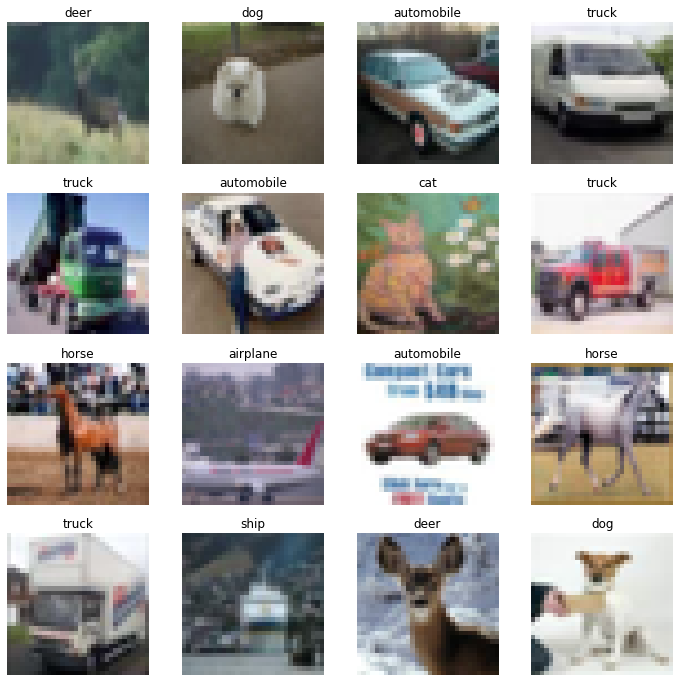

In [ ]:
# visualizing random images from the training set
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12,12))

for ax in axs.reshape(-1):
    idx = np.random.randint(len(X_train))
    ax.set_title(class_names[np.squeeze(y_train)[idx]])
    ax.axis('off')
    ax.imshow(X_train[idx], cmap="gray");


In [ ]:
data=pd.DataFrame(y_train.tolist(), columns = ["class_names"])
print('Train Set Class Distribution:\n')
print(data["class_names"].value_counts().sort_index())


Train Set Class Distribution:

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: class_names, dtype: int64


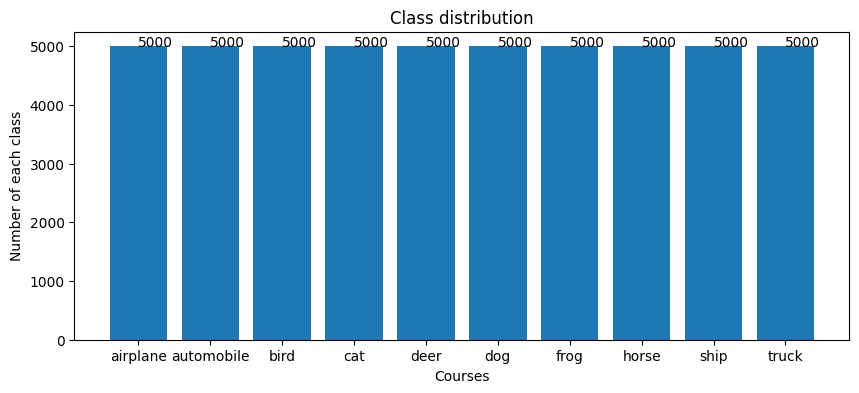

In [ ]:
# importing library
import matplotlib.pyplot as plt
  
plt.figure(figsize=(10,4))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])
        
# creating data on which bar chart will be plot
x = class_names
y = data["class_names"].value_counts()

# making the bar chart on the data
plt.bar(x, y)

# calling the function to add value labels
addlabels(x, y)

# giving title to the plot
plt.title("Class distribution")

# giving X and Y labels
plt.xlabel("Courses")
plt.ylabel("Number of each class")

# visualizing the plot
plt.show()

#### There is a uniform distribution between the 10 classes. Hence there is no bias towards a particular class

# Data Preprocessing
    Pixel Normalization / Rescaling for X_train(to bring the pixel values down to range -1 to 1
    Convert class vector (integers) to binary class matrix for y_train to be used in CGAN (conditional GAN) as each node in the input layer represents a class

In [ ]:
# preprocessing function on images and labels
def preprocessing_func(x, y):
    # pixel normalization
    x = x.astype('float32')
    x /= 127.5
    x -= 1

    y = to_categorical(y=y, num_classes=10)

    return x, y

X_train, y_train = preprocessing_func(X_train, y_train)
X_test, y_test = preprocessing_func(X_test, y_test)

for i in [X_train, y_train, X_test, y_test]:
    print("Shape:", i.shape)
    print("Data Type:", i.dtype)
    print("Class:", type(i))
    print('Max Value:', i.max())
    print('Min Value:', i.min())
    print("---")

Shape: (50000, 32, 32, 3)
Data Type: float32
Class: <class 'numpy.ndarray'>
Max Value: 1.0
Min Value: -1.0
---
Shape: (50000, 10)
Data Type: float32
Class: <class 'numpy.ndarray'>
Max Value: 1.0
Min Value: 0.0
---
Shape: (10000, 32, 32, 3)
Data Type: float32
Class: <class 'numpy.ndarray'>
Max Value: 1.0
Min Value: -1.0
---
Shape: (10000, 10)
Data Type: float32
Class: <class 'numpy.ndarray'>
Max Value: 1.0
Min Value: 0.0
---


# Prepare ImageDataGenerator for data augmentation

## Use ImageDataGenerator 
-  rotation_range (Degree range for random rotations)
-  horizontal_flip (Randomly flip inputs horizontally)
-  width_shift_range (Range for random horizontal shifts)
-  height_shift_range (Range for random vertical shifts)

I decided not to Augment the dataset too much as the augmented data distribution can be quite different from the original one, affecting the generator and discriminator in a GAN

### Advantages
- For the generator, data augmentation helps to increase the diversity of the generated samples, making the model more robust to different variations of the input data.
- For the discriminator, data augmentation helps to increase the robustness of the model by providing it with more diverse examples during training. This, in turn, helps the discriminator to better distinguish between real and fake samples.

In [ ]:
# Data Augmentation
# Adding data augmentation for creating more images
# Divide train and validation set 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Configuration for creating new images
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.2, 
    height_shift_range=0.2
)

train_datagen.fit(X_train)

### Adding the Augmented data to the default data

In [ ]:
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=60000):
    X_train_aug = np.concatenate((X_train, X_batch))
    y_train_aug = np.concatenate((y_train, y_batch))
    break
print(X_train_aug.shape)
print(y_train_aug.shape)

(100000, 32, 32, 3)
(100000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


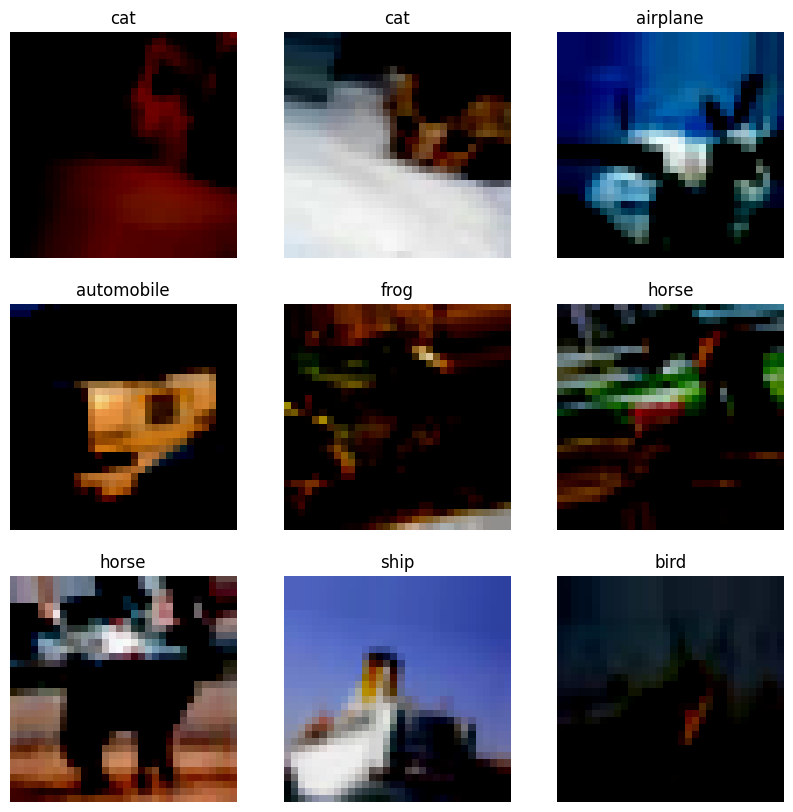

In [ ]:

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(y_batch[i])])
    plt.imshow(tf.squeeze(X_batch[i]))
    plt.axis("off")

# Base Gan Model (Self-Built)

- A generator network meant to generate 28x28x1 images.
- A discriminator network meant to classify 28x28x1 images into two classes ("fake" and "real").

# Building Generator Model
    A type of deep learning model for generative tasks by transforming a random noise vector into a high-dimensional data sample through multiple layers of transformations. The generator is trained in collaboration with a discriminator, which tries to distinguish the generated data from the real data.

# Model Architecture 
- Conv2D layer with 64 filters, a 5x5 kernel size, and a stride of (2, 2) for down-sampling the image. It has 'same' padding.
- Dropout layer with a rate of 0.3, which is used for regularization and to prevent overfitting.
- LeakyReLU activation layer with an alpha value of 0.2, which is a type of activation function that allows for a small gradient for negative input values.
- BatchNormalization layer, which normalizes the activations of the previous layer across a batch.
- Flatten layer, which is used to flatten the multi-dimensional tensors from the previous layer into a 1D tensor.
- Dense layer with a single unit and a sigmoid activation, which is used to predict the probability of the image being real (1) or fake (0).

In [15]:
def generator_model():

    model = keras.Sequential([

        keras.layers.Dense(4*4*1024, input_shape=[128, ]),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.Reshape((4, 4, 1024)),

        keras.layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding="same", activation="tanh")
    
    ], name='generator')
    
    return model

generator_model().summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 512)        20

# Visualising the Generator Model

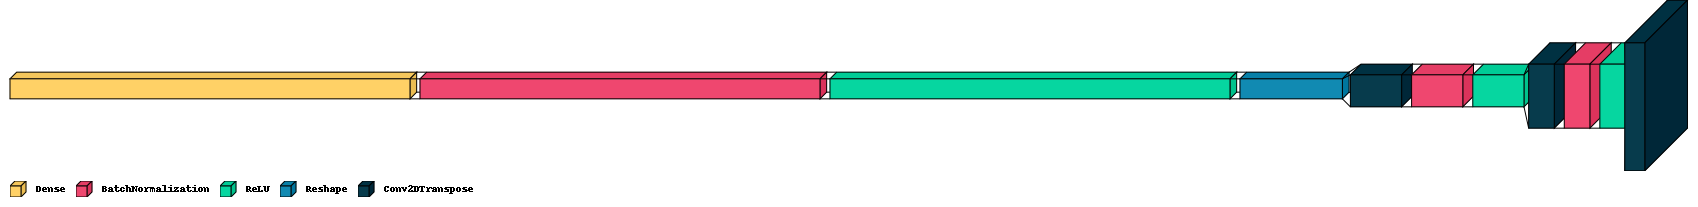

In [ ]:
visualkeras.layered_view(generator_model(), legend=True)

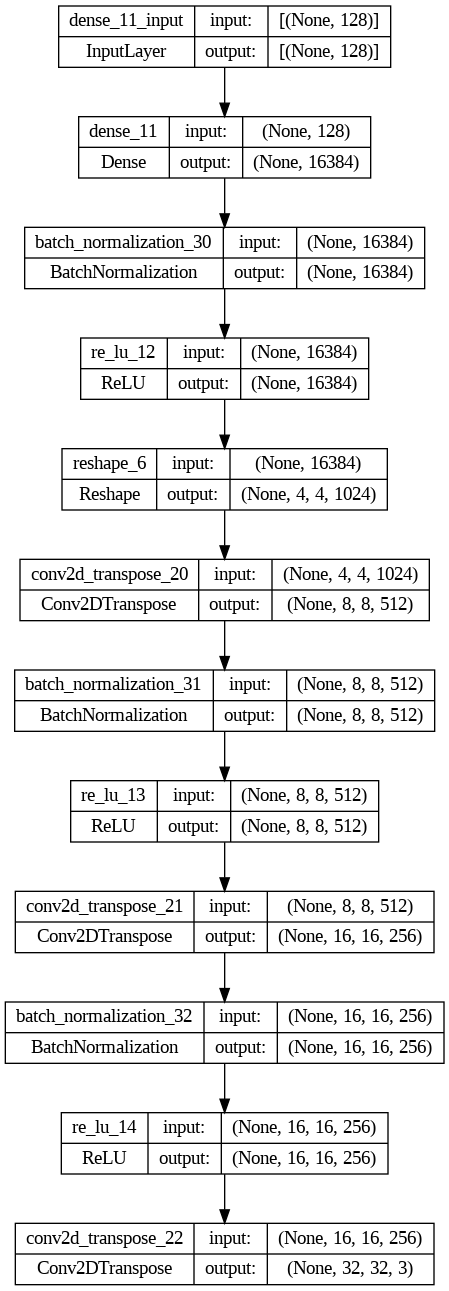

In [ ]:
plot_model(generator_model(), show_shapes=True)

# Building Discrimator Model
    A type of deep learning model for generative tasks to provide feedback to the generator on how to improve the generated data. The generator and discriminator are trained simultaneously in a two-player minimax game, where the generator tries to generate realistic data that fool the discriminator, and the discriminator tries to correctly classify the data as real or fake.

# Model Architecture
- 5 Conv2D layers that perform convolution on the input image to learn features, with a kernel size of (5, 5), stride of (2, 2) and padding of "same".
- Dropout layers to prevent overfitting by randomly dropping out some neurons during training.
- BatchNormalization layers to normalize the activations of the previous layer for each batch, to speed up and stabilize the training.
- LeakyReLU activation function with alpha=0.2 to introduce non-linearity in the model.
- Flatten layer to convert the high-dimensional feature maps from the last Conv2D layer into a one-dimensional feature vector.
- Dense layer with a single output node and a sigmoid activation function, to output a binary classification of the image being real or fake.

In [16]:
def discriminator_model():

    model = keras.Sequential([
        
        keras.layers.Conv2D(64, (5, 5), strides=(2, 2), input_shape=(32, 32, 3), padding="same"),
        keras.layers.Dropout(0.3),
        keras.layers.LeakyReLU(alpha=0.2),

        keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LeakyReLU(alpha=0.2),
                              
        keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LeakyReLU(alpha=0.2),
                              
        keras.layers.Conv2D(512, (5, 5), strides=(2, 2), padding="same"),
        keras.layers.Dropout(0.4),
        keras.layers.LeakyReLU(alpha=0.2),

        keras.layers.Flatten(),
        keras.layers.Dense(1, activation="sigmoid")
    ], name='discriminator')

    return model

discriminator_model().summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                     

# Visualising the Discrimator Model

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


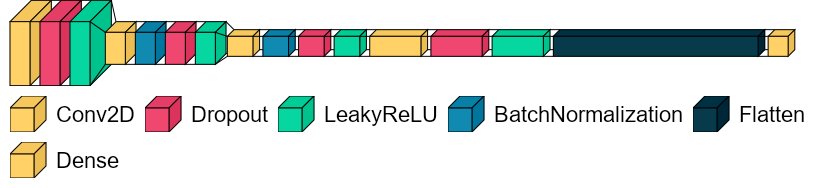

In [ ]:
font = ImageFont.truetype("arial.ttf", 22)
visualkeras.layered_view(discriminator_model(), legend=True, font=font)

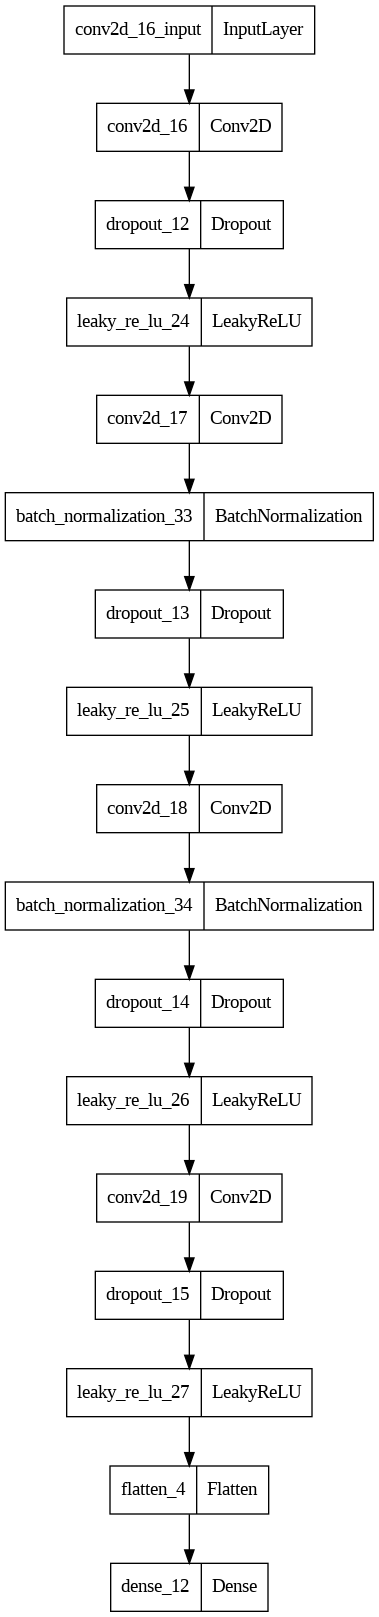

In [ ]:
plot_model(discriminator_model())

### A feature-complete GAN class, overriding compile() to use its own signature, and implementing the entire GAN algorithm in train_step:

In [ ]:
# Referenced from:
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example
tf.config.run_functions_eagerly(True)
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name='generator_loss')
        self.disc_loss_tracker = keras.metrics.Mean(name='discriminator_loss')
        self.kl = tf.keras.metrics.KLDivergence()
        self.acc_tracker = keras.metrics.Mean(name='acc.')
        
    def compile(self, d_optimizer, g_optimizer, loss_fn, acc_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.acc_fn= acc_fn

    def train_step(self, real_images):
        epoch_start = time.time()
        
        ### TRAINING DISCRIMINATOR
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        generated_images = tf.cast(generated_images, dtype = tf.float64)
        real_images = tf.cast(real_images, dtype = tf.float64)
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        original_labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions1 = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions1)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        ### TRAINING GENERATOR
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            predictions2 = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions2)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        # Monitor Loss
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_loss_tracker.update_state(g_loss)
        self.kl.update_state(y_true=real_images, y_pred=generated_images)

        acc = self.acc_fn(original_labels, predictions1)
        self.acc_tracker.update_state(acc)
        
        return {
            "d_loss": self.disc_loss_tracker.result(), 
            "g_loss": self.gen_loss_tracker.result(), 
            "KL Divergence": self.kl.result(),
            "acc.": self.acc_tracker.result()*100
        }

###  A simple custom callback that logs:
    Customize the behavior of a Keras model during training, evaluation

- When each epoch starts & ends
- When each training batch starts & ends
- Defines the plot func
- Save weights and plots images every n epochs
- Plots images at the start and ending of training

In [ ]:
# Custom callback to monitor the Generator at every n epoch
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    def __init__(self, num_img, latent_dim, patience, vmin, vmax):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.constant_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator(self.constant_latent_vector)

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.show()
        
    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                #save model weights to Img/Base_Gan Folder
                name='Img/Base_Gan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after finishing training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')

In [ ]:
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=15, latent_dim=128, patience=10, vmin=-1, vmax=1),
]

In [ ]:
def BASEGAN_model():
    """
    Creates and returns the GAN, gnerator and discriminator models
    :return: GAN, gnerator and discriminator models
    """
    
    gan = GAN(
        discriminator=discriminator_model(),
        generator=generator_model(), 
        latent_dim=128
    )
    # Compiling with Optimizer and Loss Function
    gan.compile(
        d_optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(),
        acc_fn=keras.metrics.BinaryAccuracy()
    )
    
    return gan

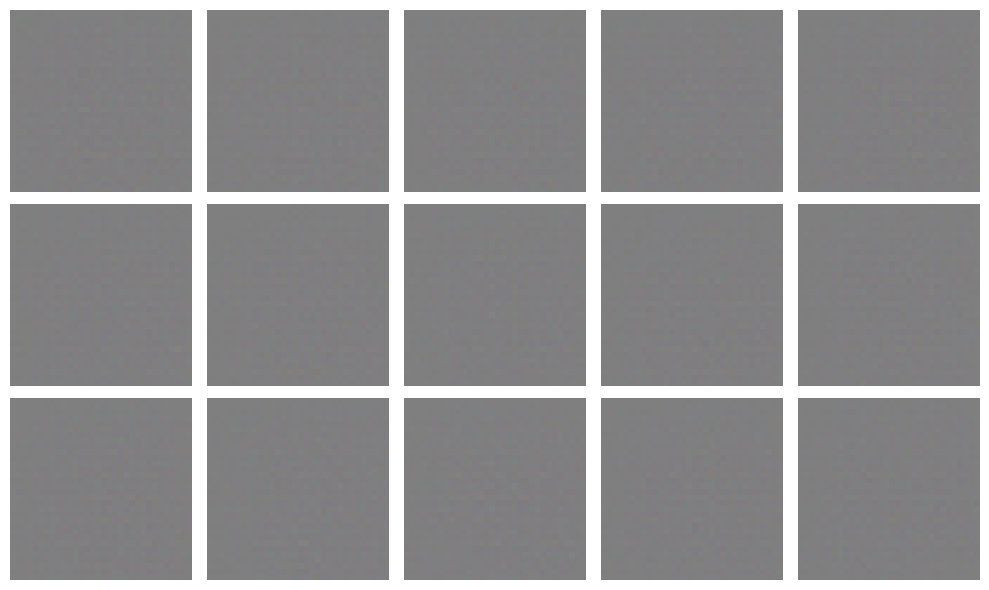

Generator Checkpoint - Img/Base_Gan/generator-epoch-0.h5
Epoch 1/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.9743 - g_loss: 2.2873 - KL Divergence: 5.3090 - acc.: 74.1074
Epoch 2/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.4335 - g_loss: 2.0786 - KL Divergence: 5.1294 - acc.: 80.9487
Epoch 3/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.5328 - g_loss: 1.5822 - KL Divergence: 5.1955 - acc.: 73.3129
Epoch 4/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.5144 - g_loss: 1.4204 - KL Divergence: 4.8318 - acc.: 73.2812
Epoch 5/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.5673 - g_loss: 1.7322 - KL Divergence: 4.9834 - acc.: 69.4986
Epoch 6/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.5684 - g_loss: 1.6381 - KL Divergence: 4.8289 - acc.: 69.0753
Epoch 7/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.5419

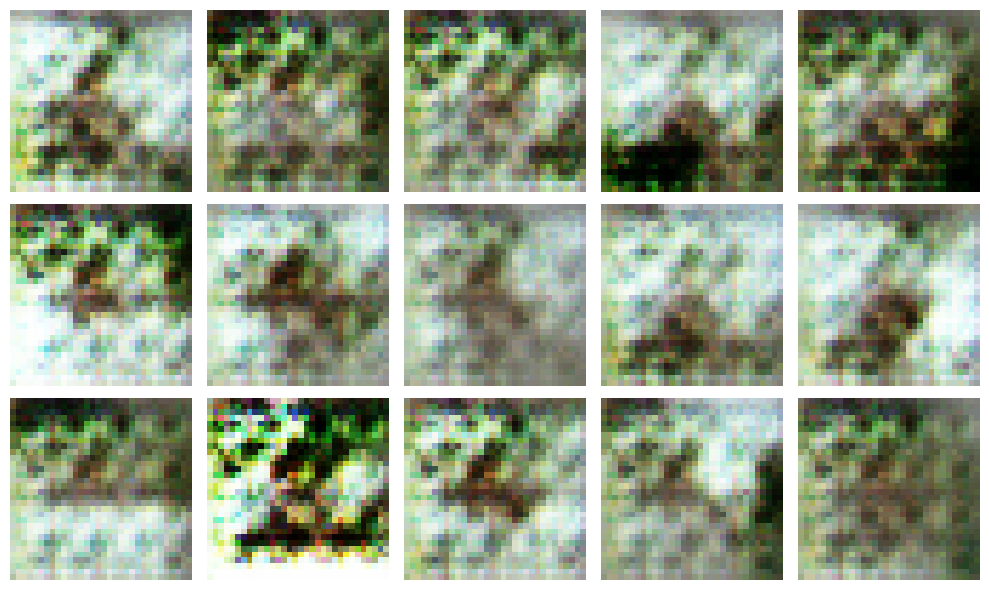

Generator Checkpoint - Img/Base_Gan/generator-epoch-10.h5
Epoch 11/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.8423 - g_loss: 1.1294 - KL Divergence: 4.9413 - acc.: 50.5502
Epoch 12/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6991 - g_loss: 0.9187 - KL Divergence: 5.0756 - acc.: 55.7307
Epoch 13/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.7034 - g_loss: 0.9134 - KL Divergence: 5.0673 - acc.: 55.8212
Epoch 14/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6826 - g_loss: 0.9449 - KL Divergence: 5.2172 - acc.: 57.8573
Epoch 15/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6979 - g_loss: 0.8399 - KL Divergence: 5.1153 - acc.: 54.1361
Epoch 16/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6856 - g_loss: 0.8449 - KL Divergence: 5.1216 - acc.: 55.3115
Epoch 17/150
391/391 [==============================] - 18s 46ms/step - d_loss

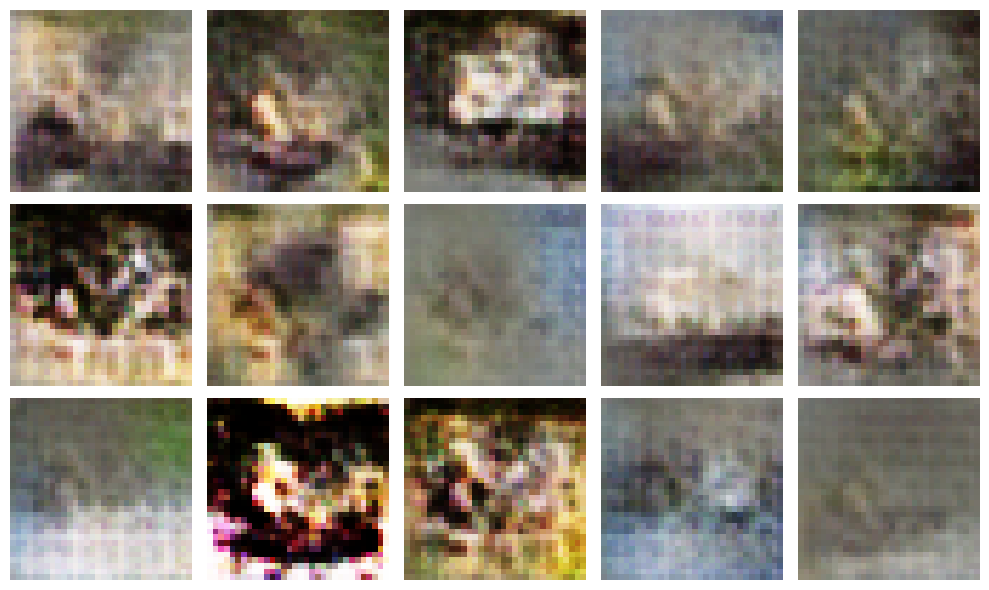

Generator Checkpoint - Img/Base_Gan/generator-epoch-20.h5
Epoch 21/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6912 - g_loss: 0.7554 - KL Divergence: 5.0350 - acc.: 53.7114
Epoch 22/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6962 - g_loss: 0.7332 - KL Divergence: 4.9905 - acc.: 52.1885
Epoch 23/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6935 - g_loss: 0.7349 - KL Divergence: 4.9249 - acc.: 52.8012
Epoch 24/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6934 - g_loss: 0.7249 - KL Divergence: 4.8790 - acc.: 52.9699
Epoch 25/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6953 - g_loss: 0.7250 - KL Divergence: 4.9796 - acc.: 51.7786
Epoch 26/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6943 - g_loss: 0.7175 - KL Divergence: 4.9569 - acc.: 52.3063
Epoch 27/150
391/391 [==============================] - 18s 45ms/step - d_loss

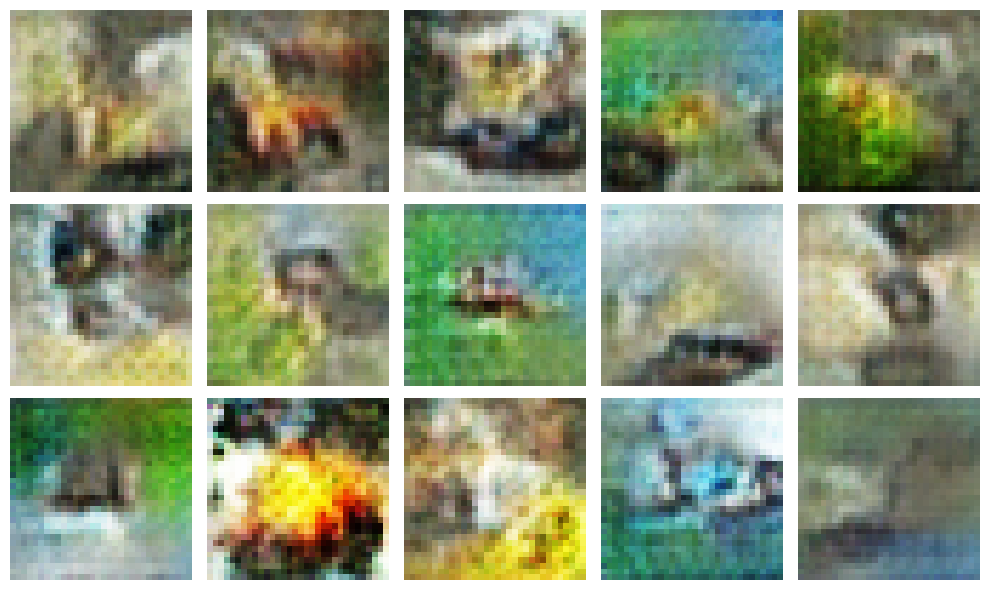

Generator Checkpoint - Img/Base_Gan/generator-epoch-30.h5
Epoch 31/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6920 - g_loss: 0.7068 - KL Divergence: 4.8665 - acc.: 51.9177
Epoch 32/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6978 - g_loss: 0.7200 - KL Divergence: 4.8894 - acc.: 51.9426
Epoch 33/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6921 - g_loss: 0.7054 - KL Divergence: 4.8950 - acc.: 51.8060
Epoch 34/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6936 - g_loss: 0.7198 - KL Divergence: 4.8577 - acc.: 51.7310
Epoch 35/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6918 - g_loss: 0.7109 - KL Divergence: 4.8192 - acc.: 51.8016
Epoch 36/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6903 - g_loss: 0.7160 - KL Divergence: 4.8622 - acc.: 52.6234
Epoch 37/150
391/391 [==============================] - 18s 45ms/step - d_loss

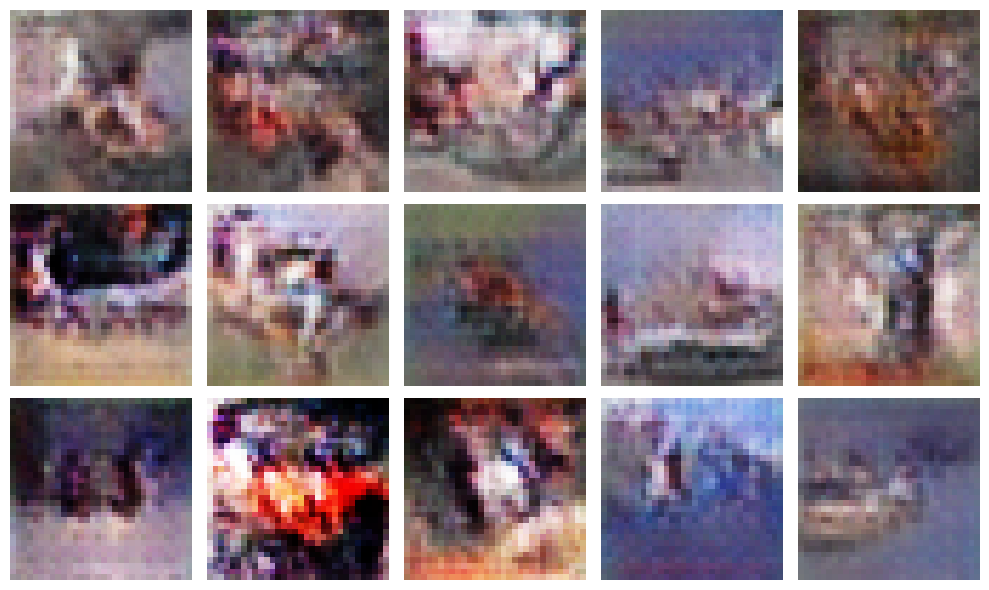

Generator Checkpoint - Img/Base_Gan/generator-epoch-40.h5
Epoch 41/150
391/391 [==============================] - 17s 45ms/step - d_loss: 0.6856 - g_loss: 0.7084 - KL Divergence: 4.9712 - acc.: 53.4577
Epoch 42/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6861 - g_loss: 0.7213 - KL Divergence: 4.8894 - acc.: 53.4026
Epoch 43/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6849 - g_loss: 0.7303 - KL Divergence: 4.8797 - acc.: 53.5456
Epoch 44/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6838 - g_loss: 0.7350 - KL Divergence: 4.9063 - acc.: 54.1168
Epoch 45/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6829 - g_loss: 0.7223 - KL Divergence: 4.8690 - acc.: 54.2078
Epoch 46/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6831 - g_loss: 0.7346 - KL Divergence: 4.8684 - acc.: 54.2683
Epoch 47/150
391/391 [==============================] - 18s 46ms/step - d_loss

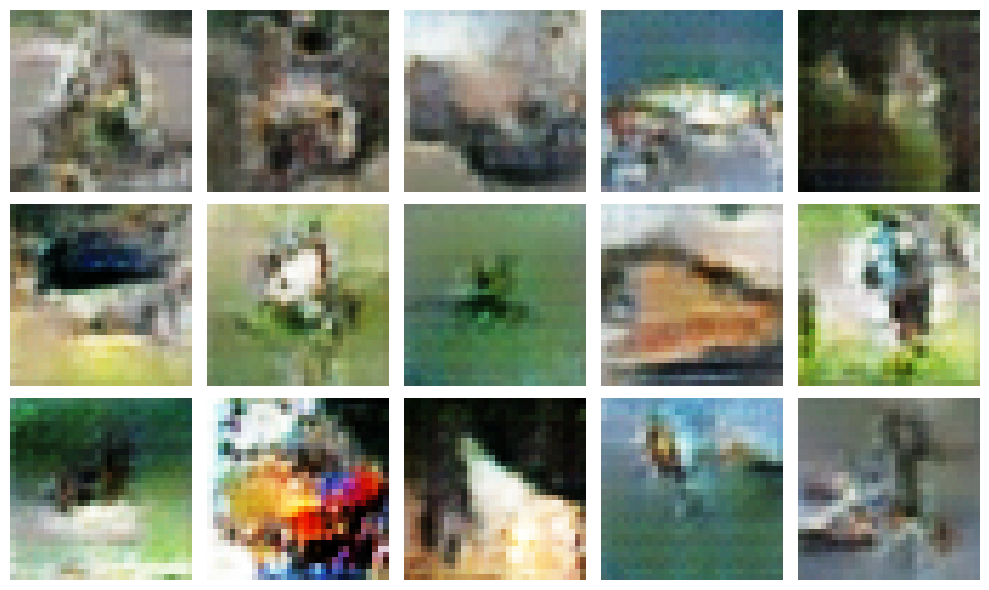

Generator Checkpoint - Img/Base_Gan/generator-epoch-50.h5
Epoch 51/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6742 - g_loss: 0.7483 - KL Divergence: 4.8885 - acc.: 56.2551
Epoch 52/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6722 - g_loss: 0.7596 - KL Divergence: 4.9294 - acc.: 56.8943
Epoch 53/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6658 - g_loss: 0.7706 - KL Divergence: 5.0189 - acc.: 57.9041
Epoch 54/150
391/391 [==============================] - 18s 46ms/step - d_loss: 0.6651 - g_loss: 0.7832 - KL Divergence: 4.9190 - acc.: 58.1541
Epoch 55/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6593 - g_loss: 0.7897 - KL Divergence: 4.9970 - acc.: 59.1804
Epoch 56/150
391/391 [==============================] - 18s 45ms/step - d_loss: 0.6554 - g_loss: 0.8051 - KL Divergence: 5.0273 - acc.: 59.8127
Epoch 57/150
391/391 [==============================] - 18s 45ms/step - d_loss

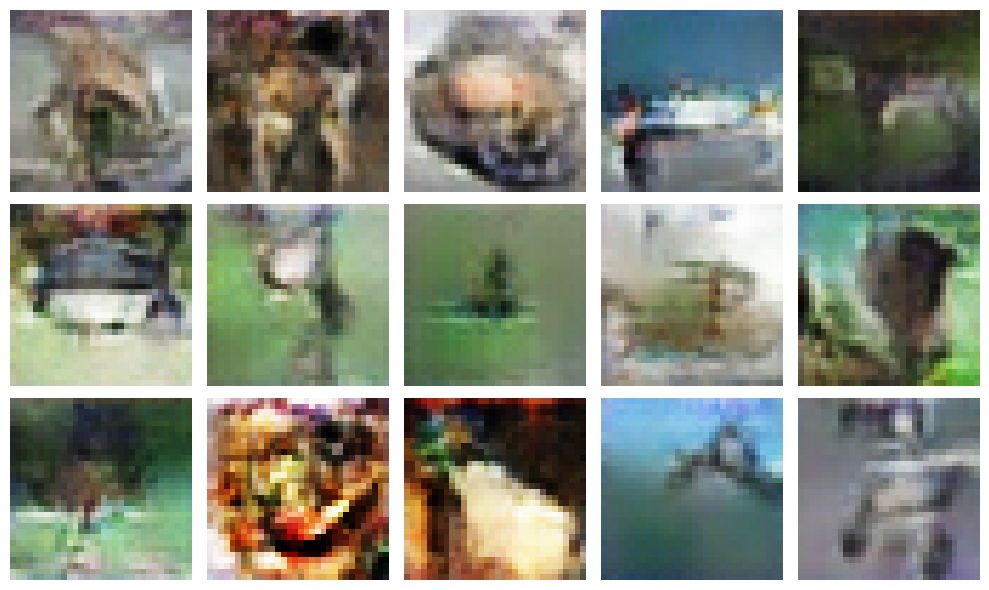

Generator Checkpoint - Img/Base_Gan/generator-epoch-60.h5
Epoch 61/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.6202 - g_loss: 0.9033 - KL Divergence: 4.9836 - acc.: 64.2841
Epoch 62/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.6104 - g_loss: 0.9129 - KL Divergence: 5.0555 - acc.: 65.5591
Epoch 63/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.6032 - g_loss: 0.9491 - KL Divergence: 5.0248 - acc.: 66.0112
Epoch 64/150
391/391 [==============================] - 17s 42ms/step - d_loss: 0.5903 - g_loss: 0.9872 - KL Divergence: 5.0620 - acc.: 67.2988
Epoch 65/150
391/391 [==============================] - 17s 42ms/step - d_loss: 0.5819 - g_loss: 1.0062 - KL Divergence: 5.0545 - acc.: 68.0650
Epoch 66/150
391/391 [==============================] - 17s 42ms/step - d_loss: 0.5708 - g_loss: 1.0247 - KL Divergence: 5.1123 - acc.: 69.2844
Epoch 67/150
391/391 [==============================] - 17s 43ms/step - d_loss

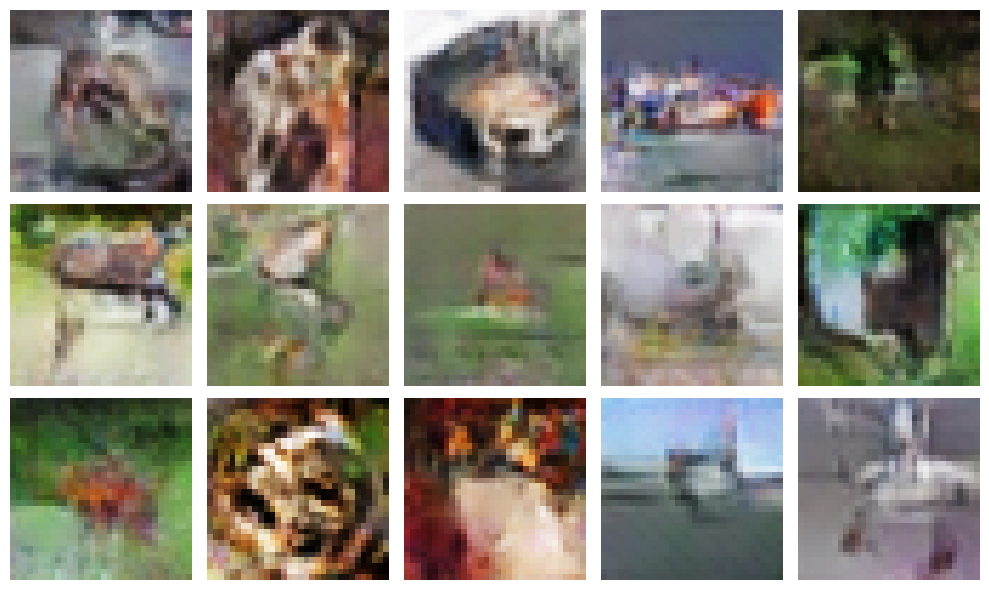

Generator Checkpoint - Img/Base_Gan/generator-epoch-70.h5
Epoch 71/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.5082 - g_loss: 1.1989 - KL Divergence: 5.1579 - acc.: 73.7907
Epoch 72/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.5012 - g_loss: 1.2291 - KL Divergence: 5.2178 - acc.: 74.4463
Epoch 73/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.4861 - g_loss: 1.2944 - KL Divergence: 5.2628 - acc.: 75.4679
Epoch 74/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.4747 - g_loss: 1.3337 - KL Divergence: 5.2409 - acc.: 76.2953
Epoch 75/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.4635 - g_loss: 1.3658 - KL Divergence: 5.2057 - acc.: 77.1268
Epoch 76/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.4497 - g_loss: 1.4119 - KL Divergence: 5.2406 - acc.: 78.2034
Epoch 77/150
391/391 [==============================] - 16s 42ms/step - d_loss

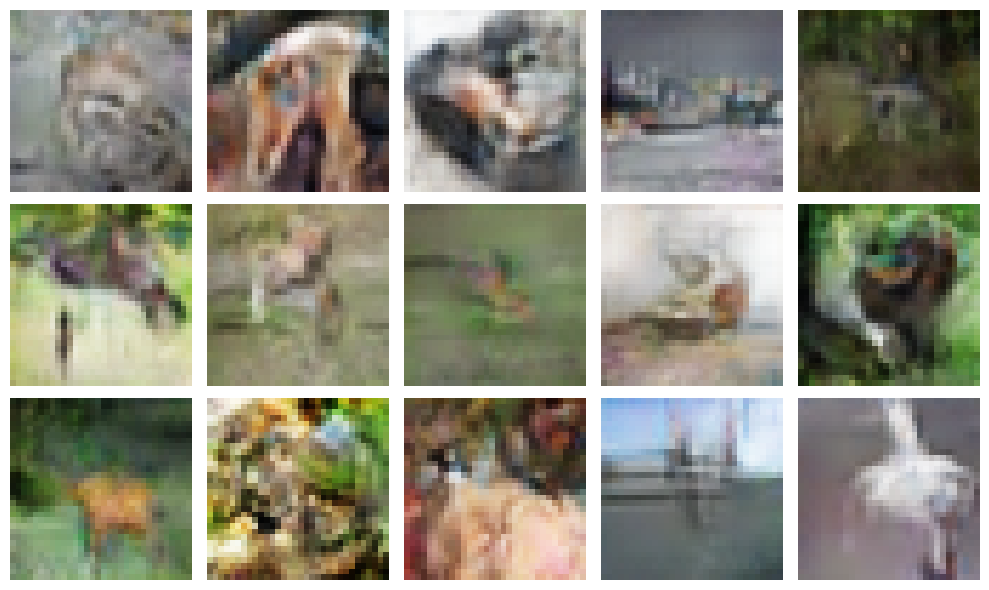

Generator Checkpoint - Img/Base_Gan/generator-epoch-80.h5
Epoch 81/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3916 - g_loss: 1.6558 - KL Divergence: 5.3638 - acc.: 81.4678
Epoch 82/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3754 - g_loss: 1.7299 - KL Divergence: 5.3996 - acc.: 82.2397
Epoch 83/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3641 - g_loss: 1.7868 - KL Divergence: 5.3932 - acc.: 82.9857
Epoch 84/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3457 - g_loss: 1.8525 - KL Divergence: 5.4590 - acc.: 83.9648
Epoch 85/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3377 - g_loss: 1.8884 - KL Divergence: 5.4778 - acc.: 84.2196
Epoch 86/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.3296 - g_loss: 1.9561 - KL Divergence: 5.4349 - acc.: 84.8497
Epoch 87/150
391/391 [==============================] - 17s 43ms/step - d_loss

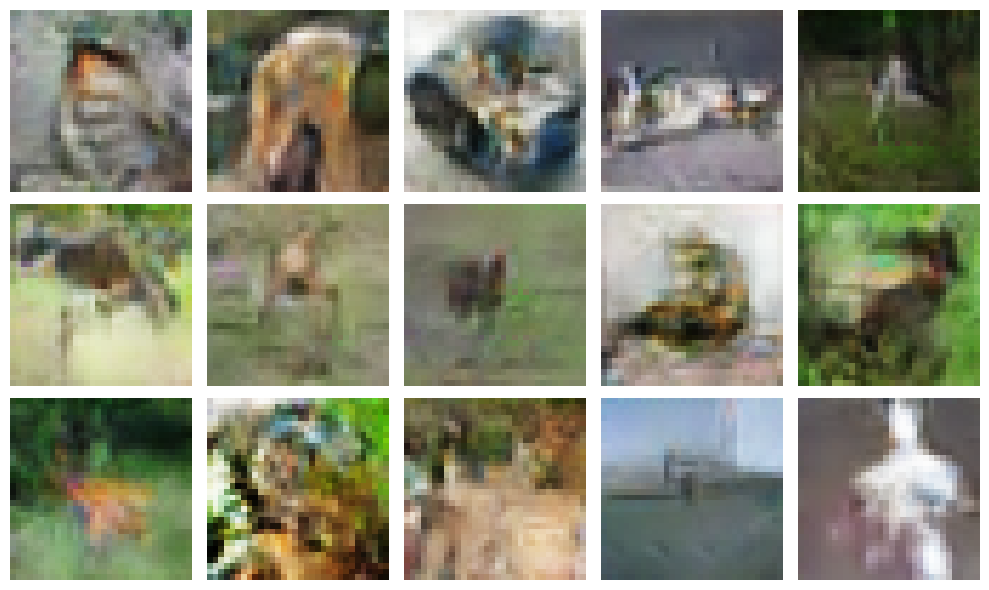

Generator Checkpoint - Img/Base_Gan/generator-epoch-90.h5
Epoch 91/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.2745 - g_loss: 2.1252 - KL Divergence: 5.5421 - acc.: 87.6836
Epoch 92/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.2683 - g_loss: 2.2097 - KL Divergence: 5.5324 - acc.: 87.7384
Epoch 93/150
391/391 [==============================] - 17s 42ms/step - d_loss: 0.2625 - g_loss: 2.2726 - KL Divergence: 5.5466 - acc.: 87.8850
Epoch 94/150
391/391 [==============================] - 16s 42ms/step - d_loss: 0.2533 - g_loss: 2.3631 - KL Divergence: 5.6133 - acc.: 88.1971
Epoch 95/150
391/391 [==============================] - 16s 42ms/step - d_loss: 0.2431 - g_loss: 2.4338 - KL Divergence: 5.6385 - acc.: 88.6767
Epoch 96/150
391/391 [==============================] - 16s 41ms/step - d_loss: 0.2344 - g_loss: 2.5213 - KL Divergence: 5.7242 - acc.: 89.0589
Epoch 97/150
391/391 [==============================] - 16s 42ms/step - d_loss

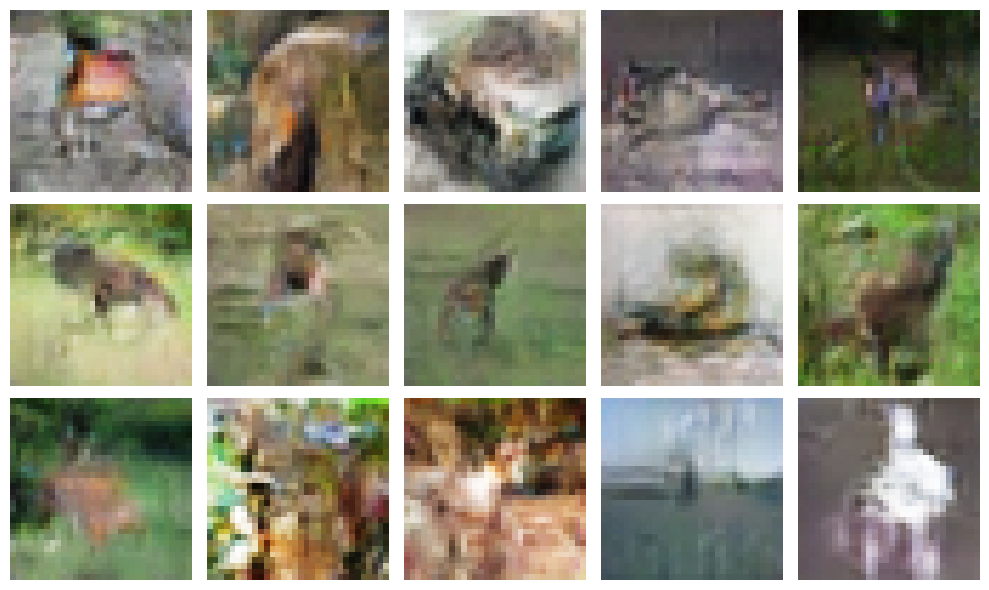

Generator Checkpoint - Img/Base_Gan/generator-epoch-100.h5
Epoch 101/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1969 - g_loss: 2.8197 - KL Divergence: 5.6883 - acc.: 90.0956
Epoch 102/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1820 - g_loss: 2.9270 - KL Divergence: 5.7603 - acc.: 90.6691
Epoch 103/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1758 - g_loss: 2.9901 - KL Divergence: 5.6770 - acc.: 90.7988
Epoch 104/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1693 - g_loss: 3.0514 - KL Divergence: 5.7586 - acc.: 90.5726
Epoch 105/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1606 - g_loss: 3.0802 - KL Divergence: 5.7823 - acc.: 90.5471
Epoch 106/150
391/391 [==============================] - 16s 41ms/step - d_loss: 0.5049 - g_loss: 2.8022 - KL Divergence: 5.5436 - acc.: 84.6745
Epoch 107/150
391/391 [==============================] - 16s 42ms/step 

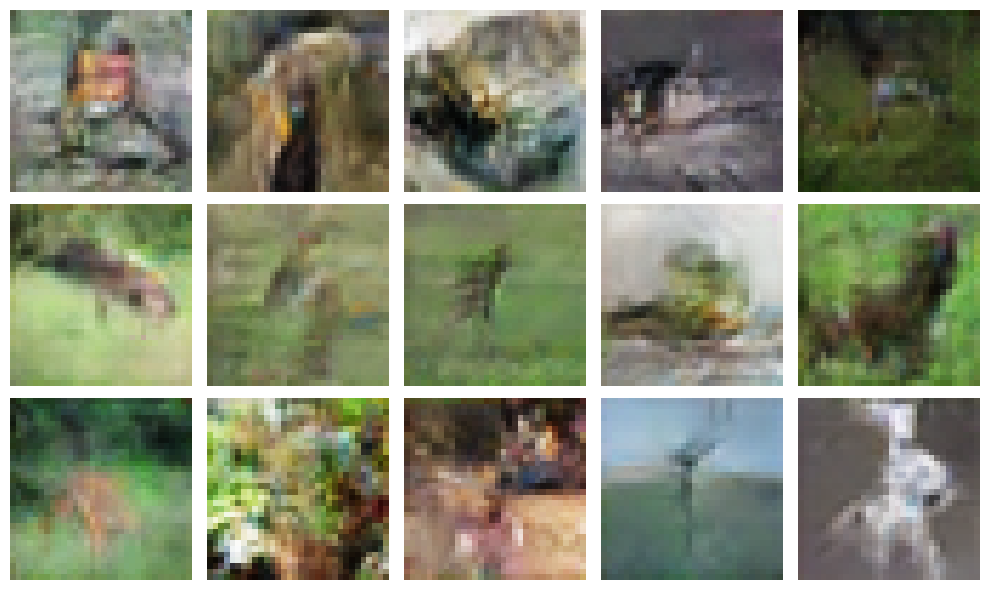

Generator Checkpoint - Img/Base_Gan/generator-epoch-110.h5
Epoch 111/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.1125 - g_loss: 3.3766 - KL Divergence: 5.8074 - acc.: 91.4061
Epoch 112/150
391/391 [==============================] - 17s 42ms/step - d_loss: 0.1144 - g_loss: 3.4444 - KL Divergence: 5.7650 - acc.: 90.9032
Epoch 113/150
391/391 [==============================] - 16s 42ms/step - d_loss: 0.1047 - g_loss: 3.4002 - KL Divergence: 5.8020 - acc.: 91.0056
Epoch 114/150
391/391 [==============================] - 16s 42ms/step - d_loss: 0.1203 - g_loss: 3.4986 - KL Divergence: 5.7934 - acc.: 90.6938
Epoch 115/150
391/391 [==============================] - 16s 41ms/step - d_loss: 0.1021 - g_loss: 3.4746 - KL Divergence: 5.8337 - acc.: 91.4574
Epoch 116/150
391/391 [==============================] - 16s 41ms/step - d_loss: 0.0809 - g_loss: 3.5540 - KL Divergence: 5.7748 - acc.: 90.9677
Epoch 117/150
391/391 [==============================] - 16s 42ms/step 

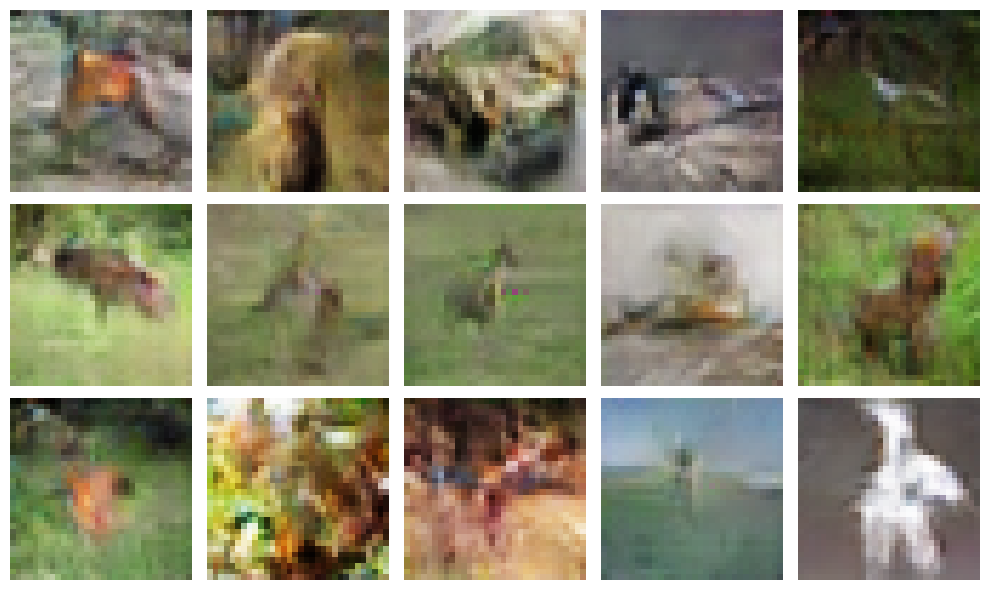

Generator Checkpoint - Img/Base_Gan/generator-epoch-120.h5
Epoch 121/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.0540 - g_loss: 3.6859 - KL Divergence: 5.7712 - acc.: 91.8415
Epoch 122/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.0210 - g_loss: 3.7976 - KL Divergence: 5.8265 - acc.: 91.1600
Epoch 123/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.0859 - g_loss: 3.8011 - KL Divergence: 5.7535 - acc.: 90.3678
Epoch 124/150
391/391 [==============================] - 17s 43ms/step - d_loss: 0.0917 - g_loss: 3.8246 - KL Divergence: 5.7921 - acc.: 89.9671
Epoch 125/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.0490 - g_loss: 3.9059 - KL Divergence: 5.8474 - acc.: 90.1045
Epoch 126/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.0949 - g_loss: 3.9562 - KL Divergence: 5.8050 - acc.: 89.6665
Epoch 127/150
391/391 [==============================] - 17s 43ms/ste

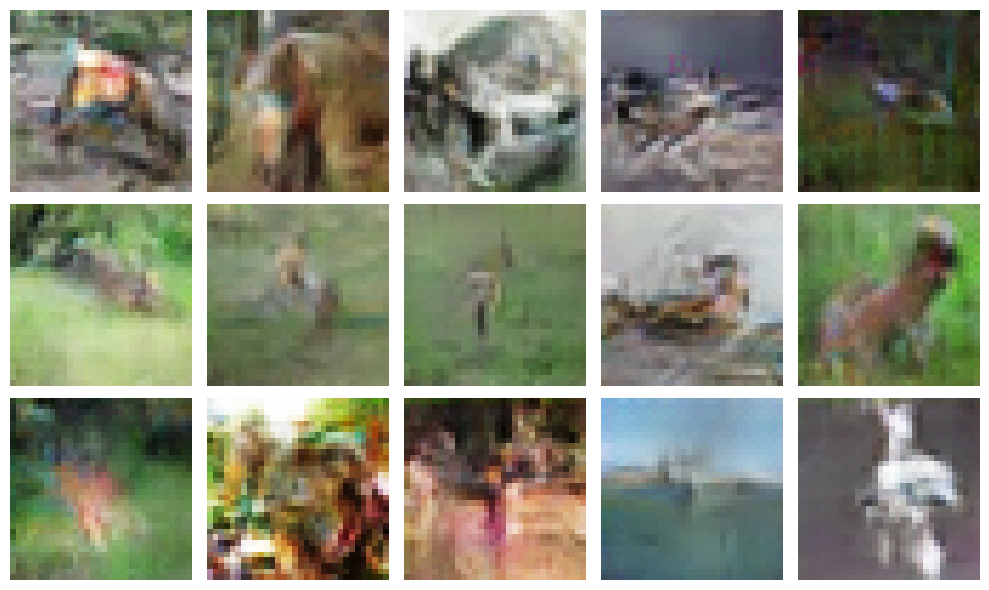

Generator Checkpoint - Img/Base_Gan/generator-epoch-130.h5
Epoch 131/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.0421 - g_loss: 4.1212 - KL Divergence: 5.7551 - acc.: 89.7388
Epoch 132/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.0570 - g_loss: 4.0806 - KL Divergence: 5.7315 - acc.: 88.9375
Epoch 133/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.1158 - g_loss: 3.9993 - KL Divergence: 5.7089 - acc.: 88.5233
Epoch 134/150
391/391 [==============================] - 17s 42ms/step - d_loss: -0.1040 - g_loss: 4.3133 - KL Divergence: 5.6723 - acc.: 87.3366
Epoch 135/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.2450 - g_loss: 4.2786 - KL Divergence: 5.7610 - acc.: 86.4180
Epoch 136/150
391/391 [==============================] - 17s 43ms/step - d_loss: -0.3719 - g_loss: 4.3715 - KL Divergence: 5.7231 - acc.: 87.6852
Epoch 137/150
391/391 [==============================] - 17s 42ms

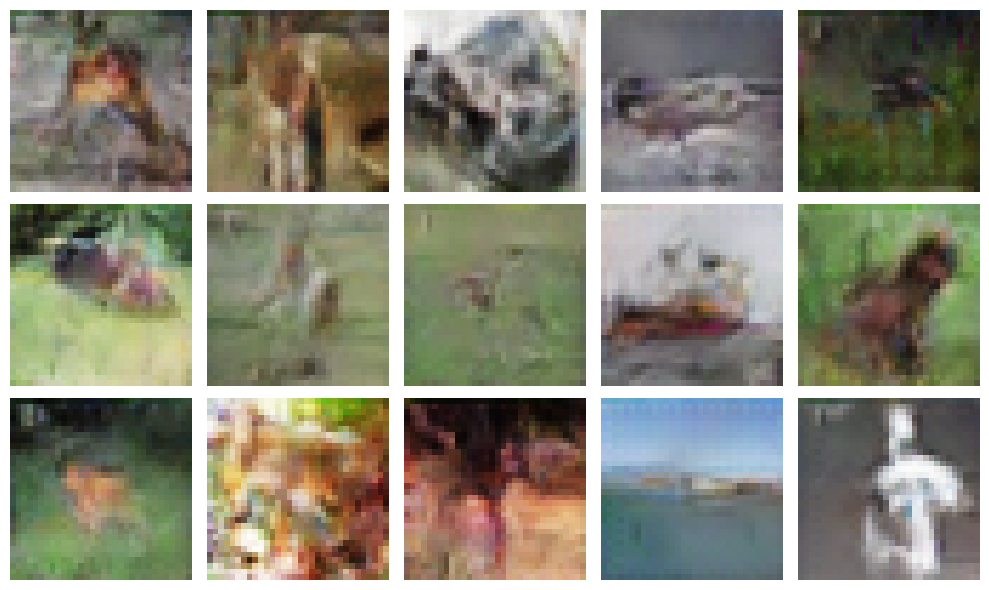

Generator Checkpoint - Img/Base_Gan/generator-epoch-140.h5
Epoch 141/150
391/391 [==============================] - 17s 42ms/step - d_loss: -1.0303 - g_loss: 4.4899 - KL Divergence: 5.5634 - acc.: 85.9499
Epoch 142/150
391/391 [==============================] - 16s 42ms/step - d_loss: -0.1068 - g_loss: 4.4792 - KL Divergence: 5.4304 - acc.: 85.1829
Epoch 143/150
391/391 [==============================] - 16s 42ms/step - d_loss: -0.3320 - g_loss: 4.4619 - KL Divergence: 5.4455 - acc.: 83.2932
Epoch 144/150
391/391 [==============================] - 16s 42ms/step - d_loss: 1.0403 - g_loss: 4.7142 - KL Divergence: 5.2573 - acc.: 78.9860
Epoch 145/150
391/391 [==============================] - 16s 41ms/step - d_loss: -0.2383 - g_loss: 3.9562 - KL Divergence: 5.5604 - acc.: 85.8205
Epoch 146/150
391/391 [==============================] - 16s 42ms/step - d_loss: -0.7585 - g_loss: 4.1535 - KL Divergence: 5.5641 - acc.: 87.0327
Epoch 147/150
391/391 [==============================] - 16s 41ms/

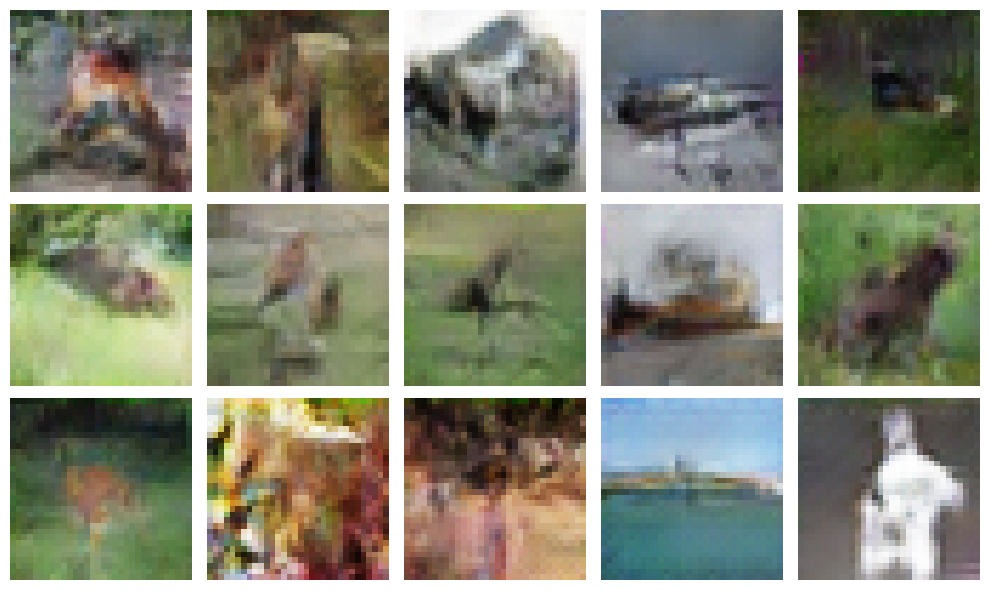

Generator Checkpoint - Img/Base_Gan/generator-epoch-Full Train.h5
CPU times: user 43min 8s, sys: 18.7 s, total: 43min 27s
Wall time: 42min 45s


In [ ]:
%%time
# Reseting Graph variables
tf.keras.backend.clear_session()

base_gan = BASEGAN_model()
# Preparing the Dataset with `tf.data`
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size=128, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = base_gan.fit(dataset, epochs=150, use_multiprocessing=True, workers=16, callbacks=callbacks)

# Base GAN Evaluation

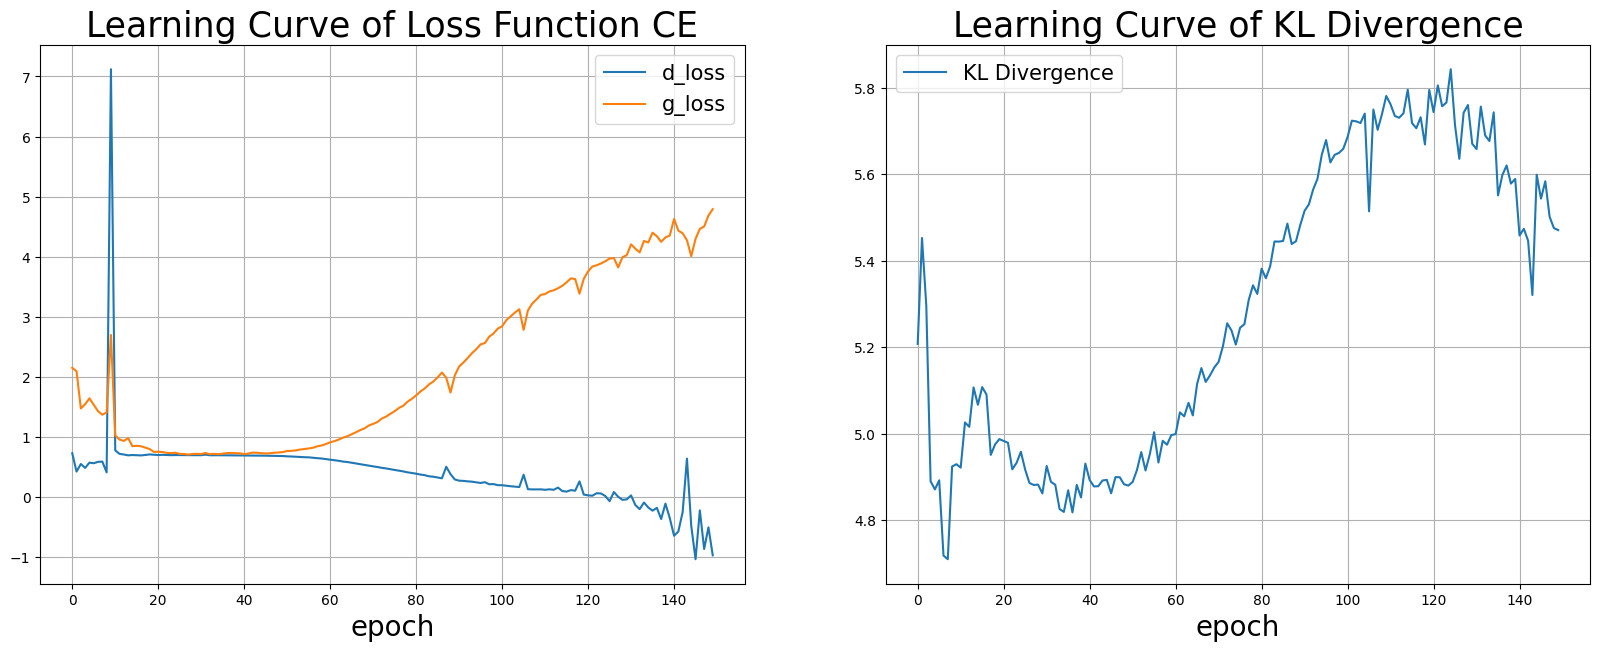

In [ ]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    ax1.plot(history["d_loss"], label="d_loss")
    ax1.plot(history['g_loss'], label="g_loss")
    ax2.plot(history['KL Divergence'], label="KL Divergence")

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);

    ax1.set_title('Learning Curve of Loss Function CE', fontsize=25);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Learning Curve of KL Divergence', fontsize=25);
    ax2.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True);
    
# plotting the learning curves
plot_results(hist.history)

In [ ]:
# Loading Weights for best Generator
saved_weights = 'Img/Base_Gan/generator-epoch-50.h5'
base_gan.generator.load_weights(saved_weights)
base_gan.generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_2 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107712  
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 512)      

## Plotting the best generated images at specific epoch

32/32 [==============================] - 0s 5ms/step
Latent Vector Dim: (1000, 128)	Generated Images Dim: (1000, 32, 32, 3)


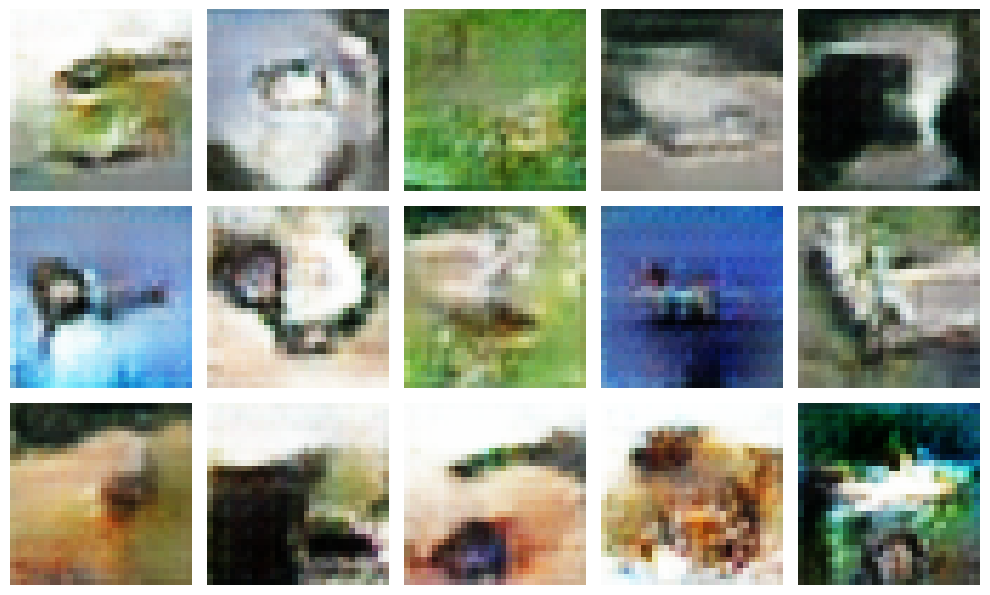

In [ ]:
# Generating Synthetic Images
random_noise = tf.random.normal(shape=(1000, 128))
synthetic_images = base_gan.generator.predict(random_noise)
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 15 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(15):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.axis('off')
plt.show()

# Fréchet Inception Distance
    Tensorflow implementation of the "Fréchet Inception Distance" (FID) between two image distributions, along with a numpy interface. The FID can be used to evaluate generative models by calculating the FID between real and fake data distributions (A lower FID score indicates that the generated images are of higher quality and are more similar to the target data distribution)

In [ ]:
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])
        generated_images = self.GENERATOR(noise)
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape: {}".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
%%time
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=base_gan.generator, train_data=X_train)
fid_score = fid_class.evaluate()

87910968/87910968 [==============================] - 2s 0us/step
Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 71ms/step
Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 72ms/step
Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape: (10240, 2048)
The computed FID score is: 130.93988840441392
CPU times: user 8min 16s, sys: 6min 49s, total: 15min 6s
Wall time: 2min 25s


# Inception Score (IS)
    An objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models.

 - The inception score has a lowest value of 1.0 and a highest value of the number of classes supported by the classification model; in this case, the Inception v3 model supports the 10 classes.
 - Therefore, the highest inception score on this dataset is 10.

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
inception_is = tf.keras.applications.inception_v3.InceptionV3()
def scale_images(images, shape):
    images = tf.image.resize(images, shape, method='nearest')
    return images

def inception_score(images, n_splits = 10, eps = 1e-16):
    # Initialize InceptionV3 model process the images appropriately for the model
    processed_images = preprocess_input(images.astype('float32'))

    # Class Probabilities for images
    scores = list()
    n_part = math.floor(images.shape[0] / n_splits)

    for i in range(n_splits):
        # Retrieve P(y|x)
        start, end = i * n_part, (i+1) * n_part
        subset = scale_images(processed_images[start:end], (299, 299))
        p_yx = inception_is.predict(subset, verbose=0)
        p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
        
        # Calculate the KL Divergence
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

        # Sum over classes
        sum_kl = kl_d.sum(axis=1)

        # Average over classes
        avg_kl = np.mean(sum_kl)

        is_score = np.exp(avg_kl)
        scores.append(is_score)

    avg_is, std_is = np.mean(scores), np.std(scores)
    return avg_is, std_is

In [ ]:
%%time
# one_hot_labels = to_categorical(np.tile(np.arange (10), 1000))
random_noise = tf.random.normal(shape=(10000, 128))

avg_is, std_is= inception_score(base_gan.generator.predict(random_noise))
print('The Average Inception Score is:', avg_is)
print('The Standard Deviation is:', std_is)

313/313 [==============================] - 2s 5ms/step
The Average Inception Score is: 1.0154393
The Standard Deviation is: 0.0007520582
CPU times: user 29.1 s, sys: 7.14 s, total: 36.3 s
Wall time: 28.9 s


# BASE Model with Augmented data

## Initialize GANMonitor to save weights to different folder

In [ ]:
# Custom callback to monitor the Generator at every n epoch
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    # NOTE: only compatible with the GAN class I've set up
    def __init__(self, num_img, latent_dim, patience, vmin, vmax):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.constant_latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator(self.constant_latent_vector)

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.axis('off')
        plt.show()
        
    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                #save model weights to Img/Base_Gan_Aug Folder
                name='Img/Base_Gan_Aug/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after finishing training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')

In [ ]:
from keras.utils import to_categorical
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=15, latent_dim=128, patience=10, vmin=-1, vmax=1),
]

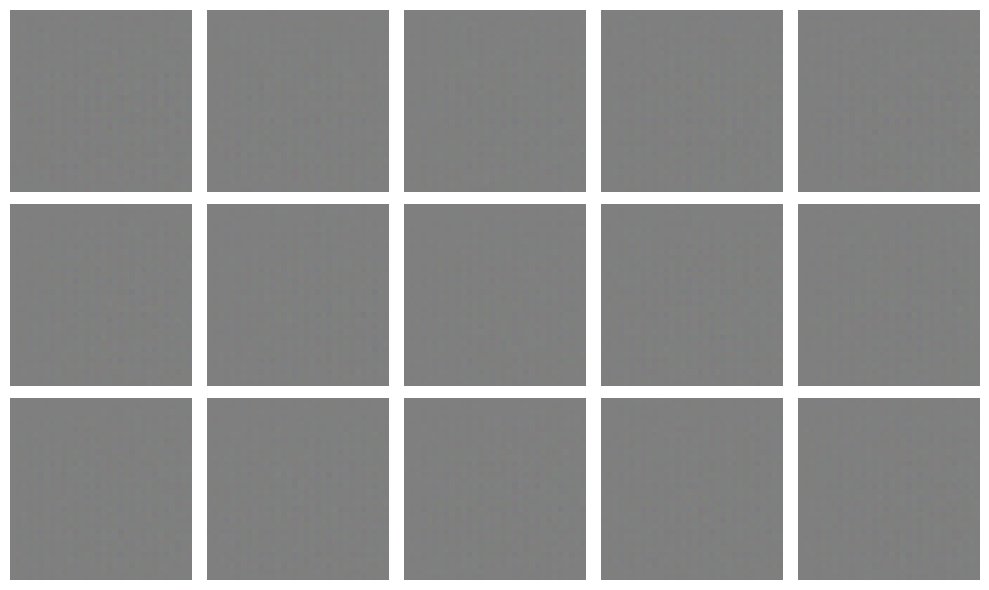

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-0.h5
Epoch 1/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.6419 - g_loss: 2.9248 - KL Divergence: 5.2570 - acc.: 76.8542
Epoch 2/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0.6122 - g_loss: 1.1765 - KL Divergence: 4.9613 - acc.: 66.0172
Epoch 3/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.5069 - g_loss: 1.6109 - KL Divergence: 5.0328 - acc.: 75.6654
Epoch 4/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.5722 - g_loss: 1.2622 - KL Divergence: 5.0945 - acc.: 69.6876
Epoch 5/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.5776 - g_loss: 1.2752 - KL Divergence: 5.0740 - acc.: 69.0573
Epoch 6/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0.5950 - g_loss: 1.1189 - KL Divergence: 4.9953 - acc.: 66.9629
Epoch 7/50
782/782 [==============================] - 33s 43ms/step - d_loss: 0.6149 - 

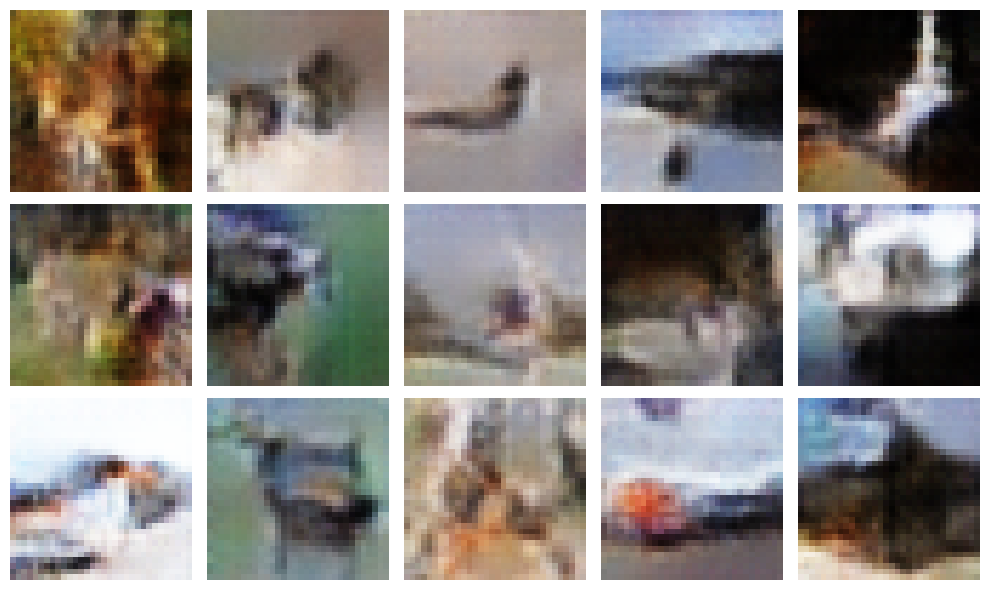

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-10.h5
Epoch 11/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0.6600 - g_loss: 0.8352 - KL Divergence: 4.9666 - acc.: 58.8403
Epoch 12/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.6650 - g_loss: 0.8135 - KL Divergence: 4.9771 - acc.: 57.8366
Epoch 13/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.6653 - g_loss: 0.8120 - KL Divergence: 4.9363 - acc.: 57.9046
Epoch 14/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.6629 - g_loss: 0.8226 - KL Divergence: 4.9897 - acc.: 58.4982
Epoch 15/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.6615 - g_loss: 0.8363 - KL Divergence: 4.9473 - acc.: 58.8244
Epoch 16/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.6583 - g_loss: 0.8379 - KL Divergence: 4.9771 - acc.: 59.4085
Epoch 17/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0

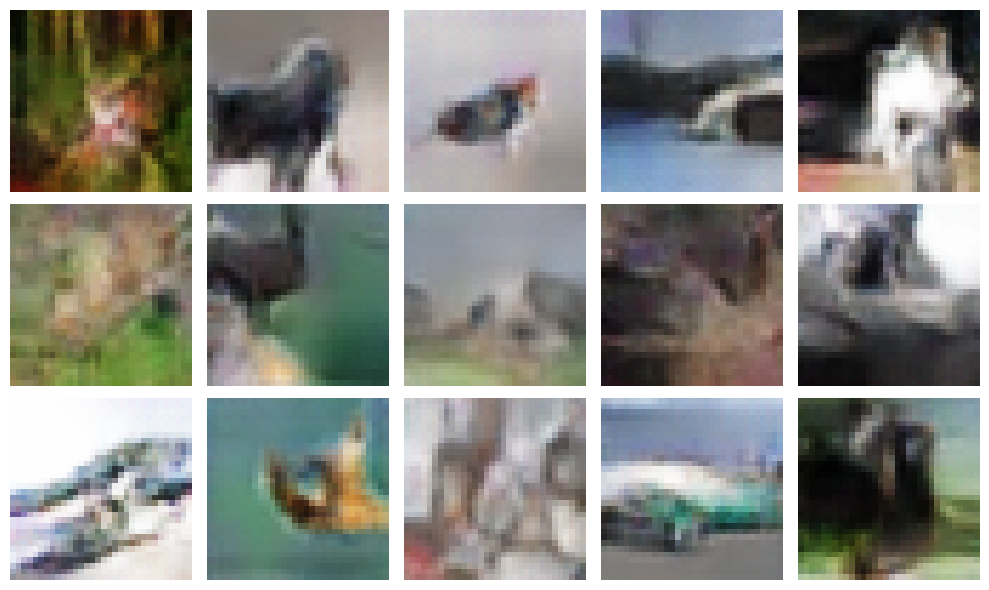

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-20.h5
Epoch 21/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.6224 - g_loss: 0.9590 - KL Divergence: 5.0612 - acc.: 64.2603
Epoch 22/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.6107 - g_loss: 0.9839 - KL Divergence: 5.0144 - acc.: 65.3662
Epoch 23/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.5946 - g_loss: 1.0301 - KL Divergence: 5.0348 - acc.: 66.8833
Epoch 24/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.6195 - g_loss: 0.9228 - KL Divergence: 4.9873 - acc.: 63.9169
Epoch 25/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.5787 - g_loss: 1.0750 - KL Divergence: 5.0818 - acc.: 68.1629
Epoch 26/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.5631 - g_loss: 1.1062 - KL Divergence: 5.0994 - acc.: 69.5781
Epoch 27/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0

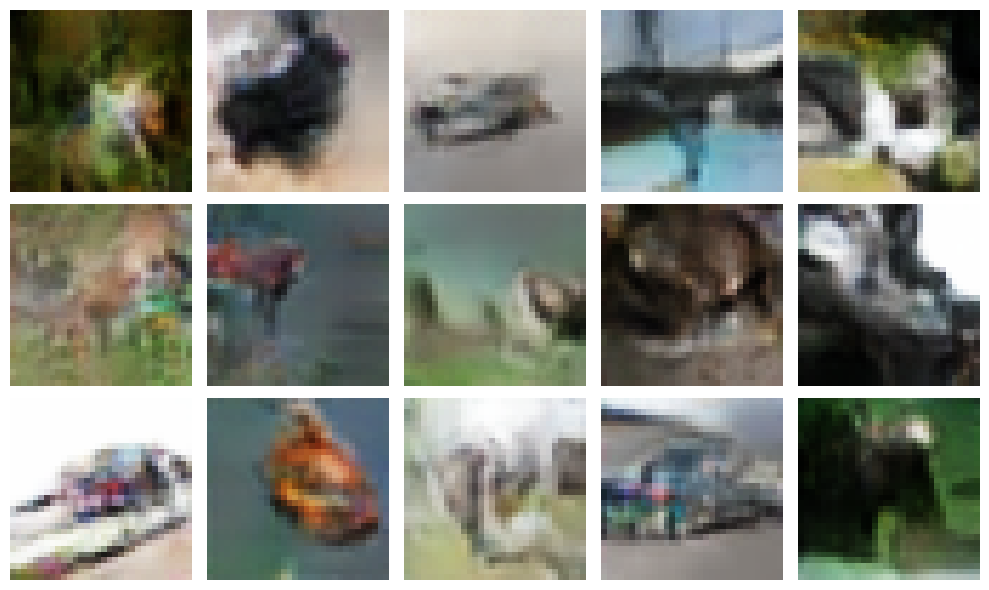

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-30.h5
Epoch 31/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.5117 - g_loss: 1.2866 - KL Divergence: 5.1512 - acc.: 74.0000
Epoch 32/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.4839 - g_loss: 1.3522 - KL Divergence: 5.1741 - acc.: 75.6622
Epoch 33/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.5069 - g_loss: 1.3701 - KL Divergence: 5.1635 - acc.: 74.7746
Epoch 34/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.4606 - g_loss: 1.3861 - KL Divergence: 5.2194 - acc.: 77.3836
Epoch 35/50
782/782 [==============================] - 35s 44ms/step - d_loss: 0.4432 - g_loss: 1.4636 - KL Divergence: 5.2080 - acc.: 78.1553
Epoch 36/50
782/782 [==============================] - 33s 43ms/step - d_loss: 0.4331 - g_loss: 1.5436 - KL Divergence: 5.2290 - acc.: 78.9950
Epoch 37/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0

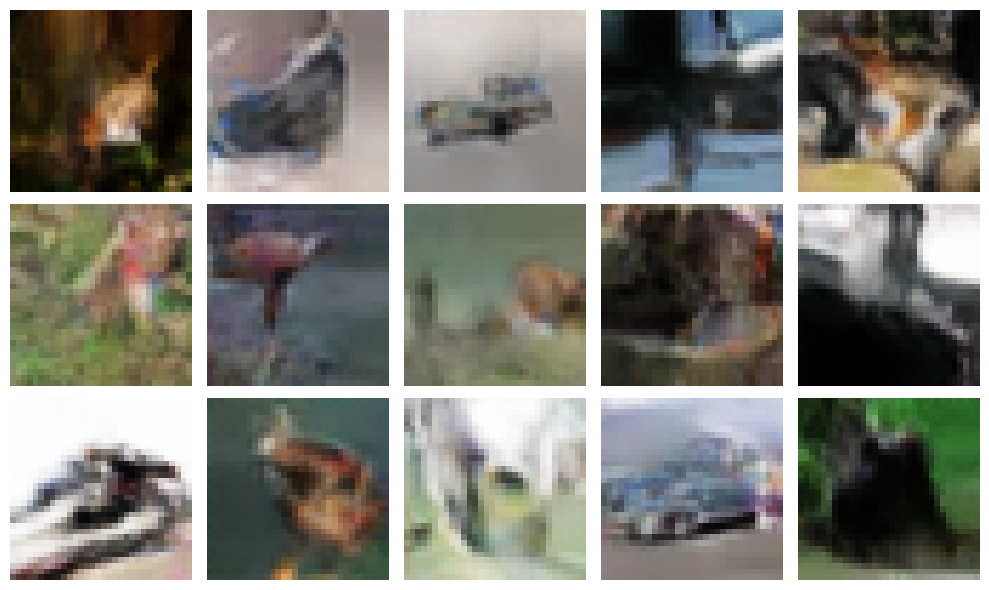

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-40.h5
Epoch 41/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.3752 - g_loss: 1.8187 - KL Divergence: 5.3216 - acc.: 82.2070
Epoch 42/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0.3504 - g_loss: 1.9107 - KL Divergence: 5.3665 - acc.: 83.3391
Epoch 43/50
782/782 [==============================] - 34s 43ms/step - d_loss: 0.3485 - g_loss: 1.9653 - KL Divergence: 5.4099 - acc.: 83.3760
Epoch 44/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.3282 - g_loss: 2.0009 - KL Divergence: 5.4277 - acc.: 84.5660
Epoch 45/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.3379 - g_loss: 2.0454 - KL Divergence: 5.4429 - acc.: 84.2869
Epoch 46/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0.3038 - g_loss: 2.0592 - KL Divergence: 5.4154 - acc.: 85.8020
Epoch 47/50
782/782 [==============================] - 34s 44ms/step - d_loss: 0

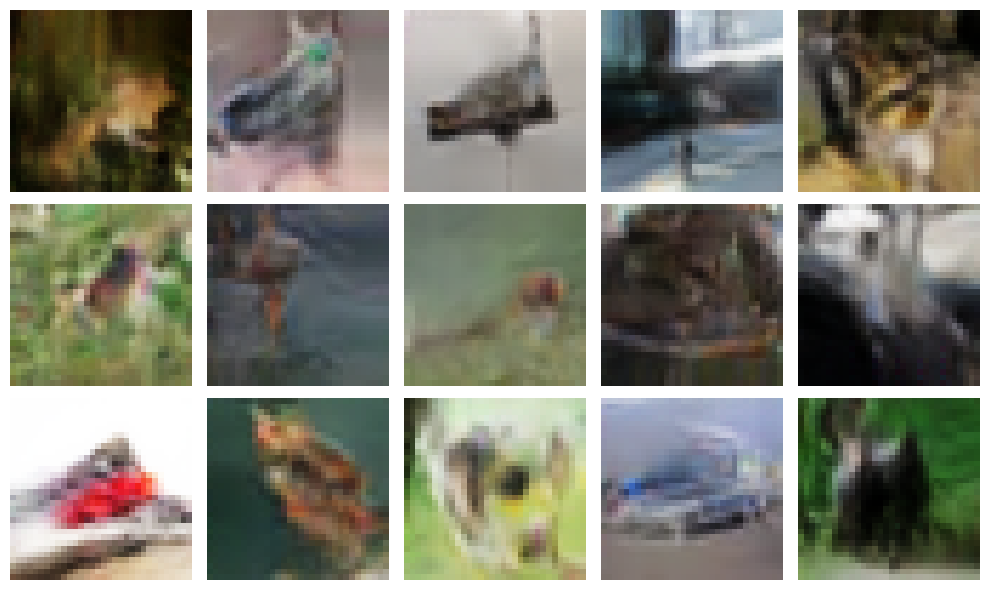

Generator Checkpoint - Img/Base_Gan_Aug/generator-epoch-Full Train.h5
CPU times: user 28min 51s, sys: 10.3 s, total: 29min 1s
Wall time: 28min 36s


In [ ]:
%%time
# Reseting Graph variables
tf.keras.backend.clear_session()

base_gan = BASEGAN_model()
# Preparing the Dataset with `tf.data`
dataset = tf.data.Dataset.from_tensor_slices(X_train_aug)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size=128, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = base_gan.fit(dataset, epochs=50, use_multiprocessing=True, workers=16, callbacks=callbacks)

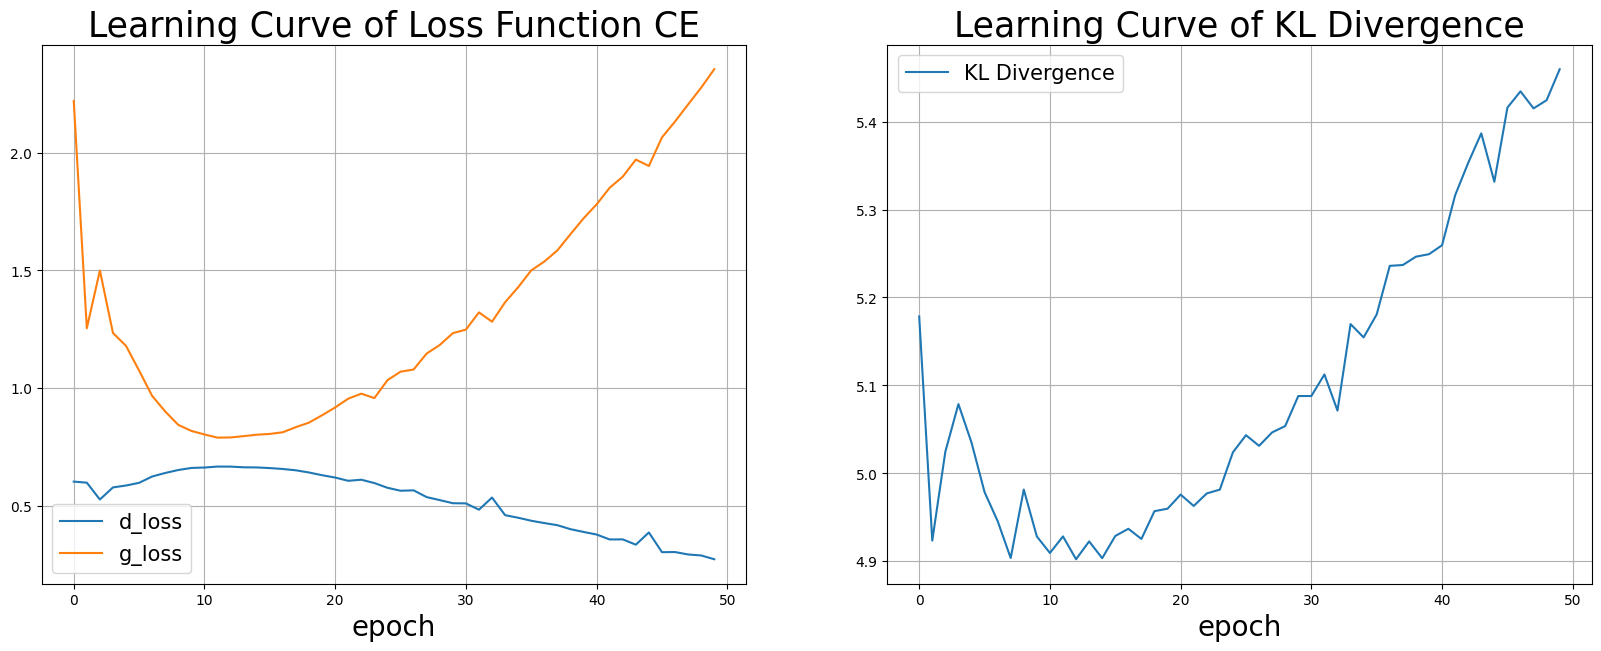

In [ ]:
plot_results(hist.history)

In [ ]:
# Loading Weights for best Generator
saved_weights = 'Img/Base_Gan_Aug/generator-epoch-20.h5'
base_gan.generator.load_weights(saved_weights)
base_gan.generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             2113536   
                                                                 
 batch_normalization_7 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 512)        13107712  
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 512)      

32/32 [==============================] - 0s 5ms/step
Latent Vector Dim: (1000, 128)	Generated Images Dim: (1000, 32, 32, 3)


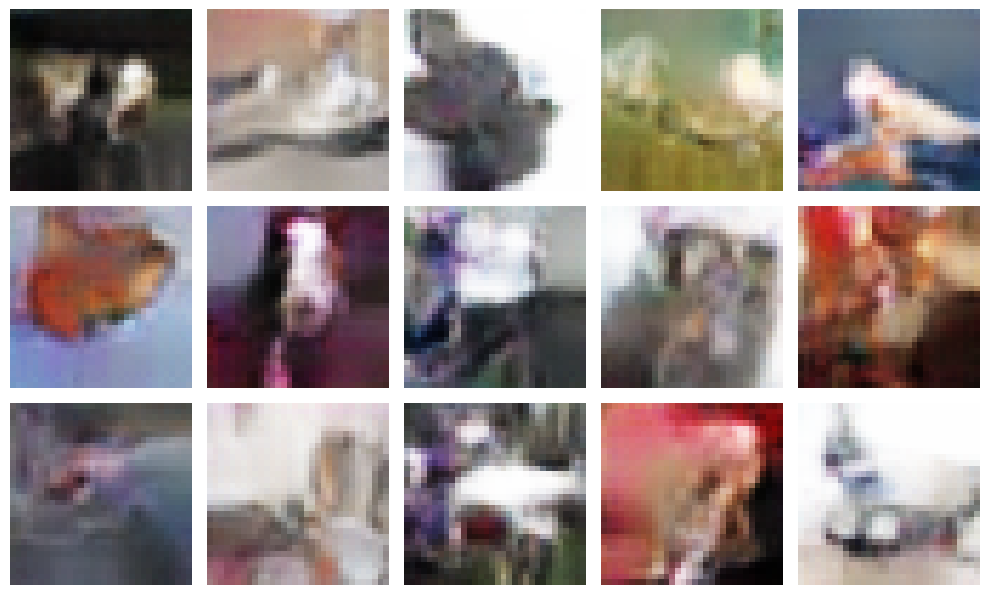

In [ ]:
# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(1000, 128))
synthetic_images = base_gan.generator.predict(random_noise)
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 15 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(15):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.axis('off')
plt.show()

In [ ]:
%%time
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=base_gan.generator, train_data=X_train_aug)
fid_score = fid_class.evaluate()

Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 73ms/step
Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 73ms/step
Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape: (10240, 2048)
The computed FID score is: 115.24401163776662
CPU times: user 7min 59s, sys: 7min 15s, total: 15min 15s
Wall time: 2min 24s


In [ ]:
%%time
# one_hot_labels = to_categorical(np.tile(np.arange (10), 1000))
random_noise = tf.random.normal(shape=(10000, 128))

avg_is, std_is= inception_score(base_gan.generator.predict(random_noise))
print('The Average Inception Score is:', avg_is)
print('The Standard Deviation is:', std_is)

313/313 [==============================] - 2s 5ms/step
The Average Inception Score is: 1.0051639
The Standard Deviation is: 0.00046384952
CPU times: user 28.9 s, sys: 9.3 s, total: 38.2 s
Wall time: 29.6 s


# CGAN (Conditional GAN)
    Conditions the network with additional information such as class labels. It means that during the training, we can pass images to the network with their actual labels

# Conditional Generator

# Model Architechture
- Use of the inverse of convolution, called transposed convolution (Deconvolution), a transformation going in the opposite direction of a normal convolution, to upsample the input feature map to a desired output feature map
- BatchNormalization layers to normalize the activations of the previous layer for each batch, to speed up and stabilize the training
- LeakyReLU activation function with alpha=0.2 to introduce non-linearity in the model
- The input to the generator are the normal distribution z and y
- Concatenate (y, z)
- The last activation is tanh

In [ ]:
from keras.layers import Concatenate
# latent space dimension
z = Input(shape=(128,))

# classes
labels = Input(shape=(10,))

# Generator network
merged_layer = Concatenate()([z, labels])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, labels], outputs=generator, name='generator')
# prints a summary representation of your model
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 138)          0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 2048)         284672      ['concatenate_3[0][0]']  

# Visualising the Generator Model

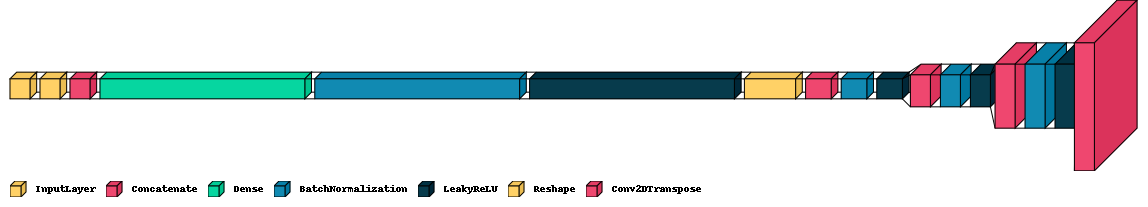

In [ ]:
visualkeras.layered_view(generator, legend=True)

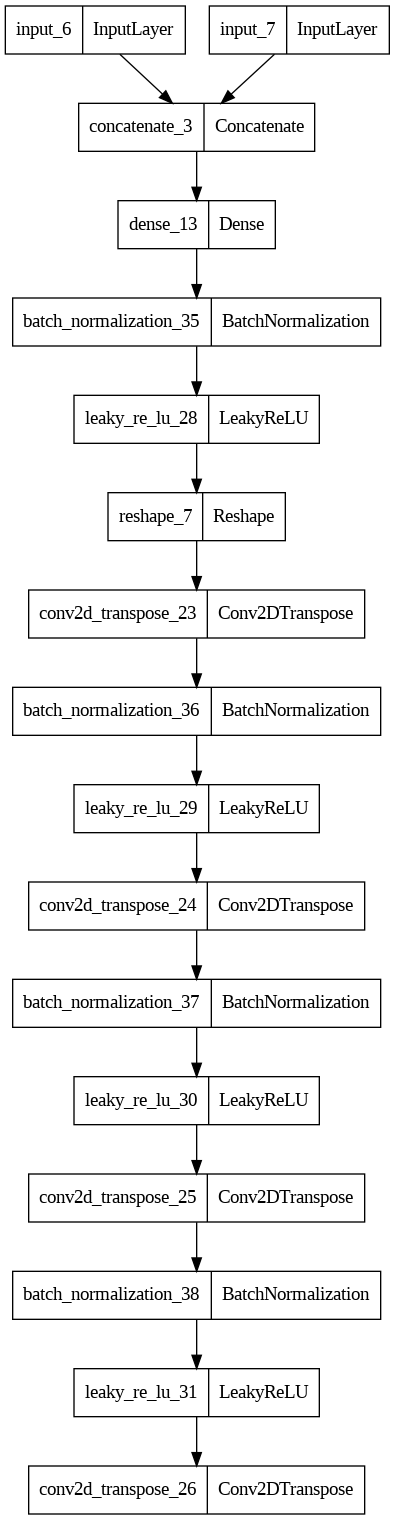

In [ ]:
plot_model(generator)

# Conditional Discriminator

# Model Architecture
- Use of Convolutional neural network
- BatchNormalization layers to normalize the activations of the previous layer for each batch, to speed up and stabilize the training
- LeakyReLU activation function with alpha=0.1 to introduce non-linearity in the model
- The input to the discriminator are x and y
- Concatenate (y,x)
- The last activation is sigmoid

In [ ]:
# input image
img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 16, 16, 64)   4864        ['input_8[0][0]']                
                                                                                                  
 batch_normalization_39 (BatchN  (None, 16, 16, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 leaky_re_lu_32 (LeakyReLU)     (None, 16, 16, 64)   0           ['batch_normalization

# Visualising the Discriminator Model

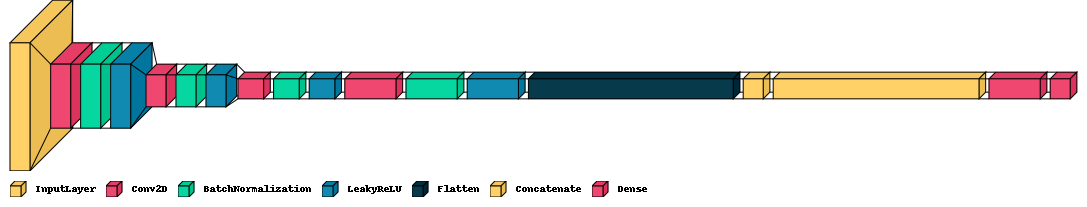

In [ ]:
visualkeras.layered_view(discriminator, legend=True)

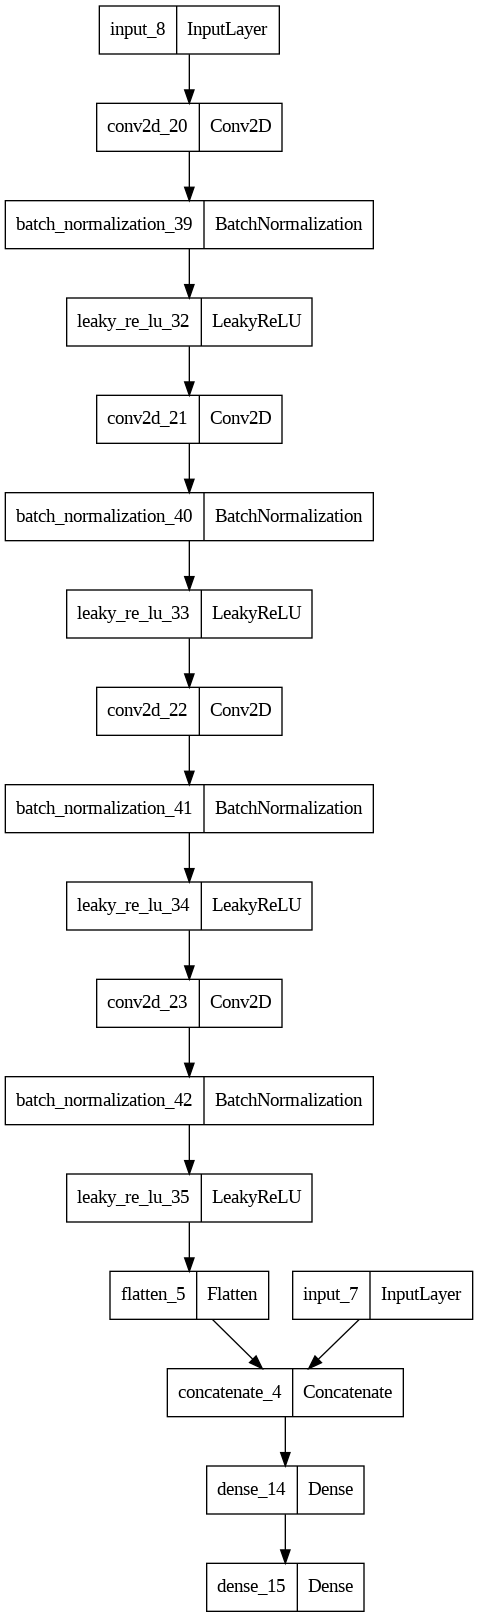

In [ ]:
plot_model(discriminator)

# Training
    Add a d_xy_tracker and d_g_zy_tracker
    Change the training function, as the conditional generator takes in 2 inputs (latent vector z and condition y, which is the classes)

In [ ]:
## Code Source: https://github.com/keras-team/keras-io/blob/master/examples/generative/conditional_gan.py
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()
        self.acc_tracker = keras.metrics.Mean(name='acc.')

    def compile(self, d_optimizer, g_optimizer, loss_fn, acc_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.acc_fn= acc_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )
        
        original_labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

        # Train the discriminator.
        with tf.GradientTape() as tape:
            prediction1 = self.discriminator([combined_images, combined_condition])
            d_loss = self.loss_fn(labels, prediction1)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Computing D(x|y)
        d_xy = tf.math.reduce_mean(prediction1)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            prediction2 = self.discriminator([fake_images, condition])        
            g_loss = self.loss_fn(misleading_labels, prediction2)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Computing D(G(z|y))
        d_g_zy = tf.math.reduce_mean(prediction2)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.d_xy_tracker.update_state(d_xy)
        self.d_g_zy_tracker.update_state(d_g_zy)
        self.kl.update_state(real_images, fake_images)
        acc = self.acc_fn(original_labels, prediction1)
        self.acc_tracker.update_state(acc)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "D(x|y)": self.d_xy_tracker.result(),
            "D(G(z|y))": self.d_g_zy_tracker.result(),
            "KL Divergence": self.kl.result(),
            "acc.": self.acc_tracker.result()*100
        }

## Initialize GANMonitor to save weights to different folder

In [ ]:
# Custom callback to display generated images every n epochs and after training
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    def __init__(self, num_img, latent_dim, patience, vmin, vmax):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax


        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_names[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                #save model weights to Img/C_Gan Folder
                name='Img/C_Gan/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')

In [ ]:
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=10, vmin=-1, vmax=1),
]

In [ ]:
def CGAN_model():
    """
    Creates and returns the GAN, gnerator and discriminator models
    :return: GAN, gnerator and discriminator models
    """
    
    gan = ConditionalGAN(
        discriminator=discriminator, 
        generator=generator, 
        latent_dim=128
    )
    # Compiling with Optimizer and Loss Function
    gan.compile(
        d_optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(),
        acc_fn=keras.metrics.BinaryAccuracy()
    )
    return gan

2023-02-05 07:33:12.363865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-05 07:33:12.694771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 1s 1s/step


2023-02-05 07:33:13.244809: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-02-05 07:33:13.244836: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-02-05 07:33:13.244895: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


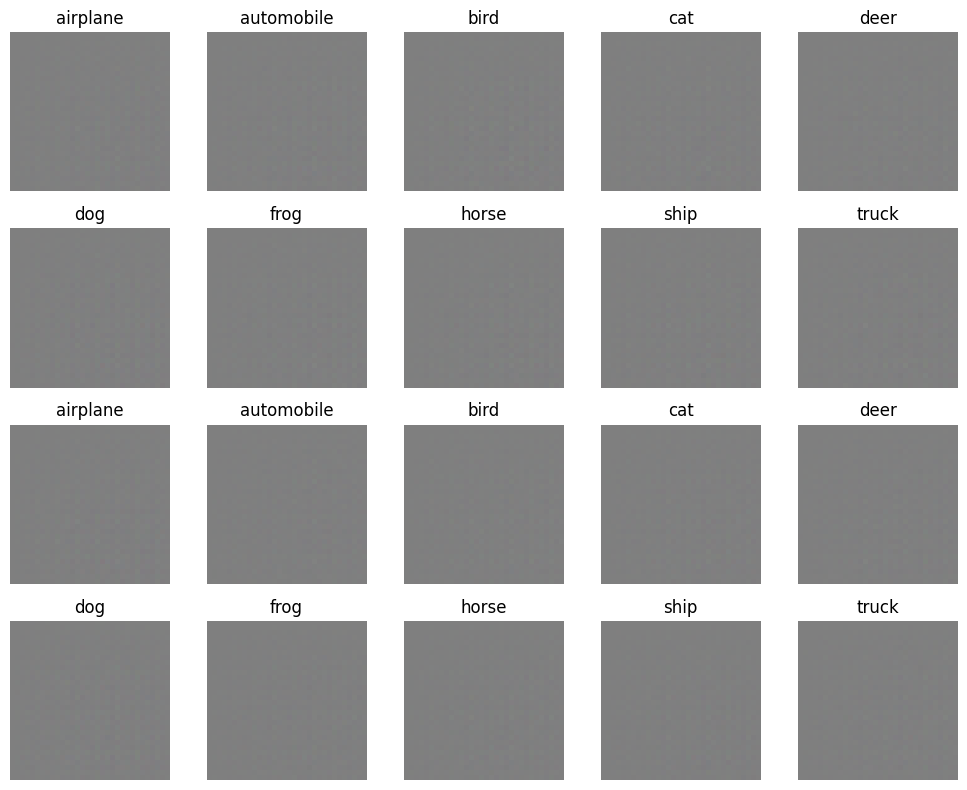

Generator Checkpoint - generator-epoch-0.h5
Epoch 1/150
391/391 [==============================] - 5s 11ms/step - d_loss: 0.4008 - g_loss: 2.1890 - D(x|y): 0.5856 - D(G(z|y)): 0.2078 - KL Divergence: 5.4421 - acc.: 84.1257
Epoch 2/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2025 - g_loss: 4.1216 - D(x|y): 0.4930 - D(G(z|y)): 0.0312 - KL Divergence: 5.8508 - acc.: 92.7018
Epoch 3/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1469 - g_loss: 4.9735 - D(x|y): 0.4998 - D(G(z|y)): 0.0190 - KL Divergence: 5.5824 - acc.: 95.5971
Epoch 4/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1200 - g_loss: 5.0273 - D(x|y): 0.4998 - D(G(z|y)): 0.0167 - KL Divergence: 5.0497 - acc.: 96.0672
Epoch 5/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1329 - g_loss: 4.7565 - D(x|y): 0.5013 - D(G(z|y)): 0.0183 - KL Divergence: 5.3205 - acc.: 95.5552
Epoch 6/150
391/391 [==============================] - 4s 10m

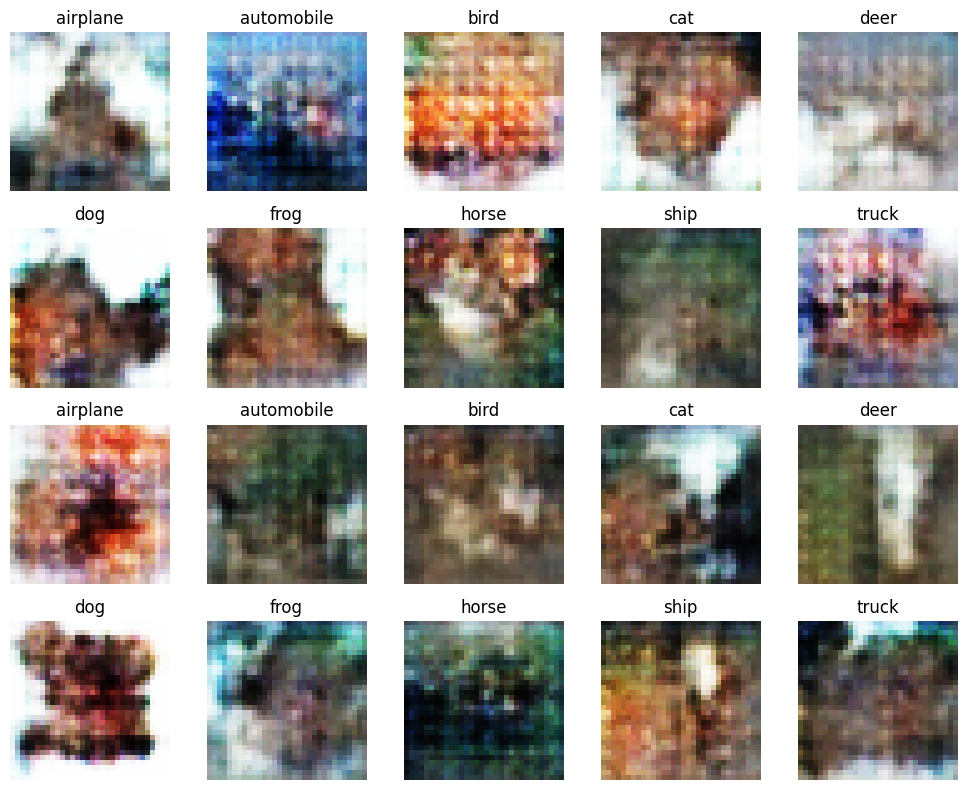

Generator Checkpoint - generator-epoch-10.h5
Epoch 11/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.2170 - g_loss: 3.6254 - D(x|y): 0.5009 - D(G(z|y)): 0.0664 - KL Divergence: 4.4938 - acc.: 91.1541
Epoch 12/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.2217 - g_loss: 3.6176 - D(x|y): 0.4996 - D(G(z|y)): 0.0733 - KL Divergence: 4.8031 - acc.: 91.0568
Epoch 13/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2204 - g_loss: 3.5625 - D(x|y): 0.4997 - D(G(z|y)): 0.0797 - KL Divergence: 4.5279 - acc.: 90.9394
Epoch 14/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2297 - g_loss: 3.4329 - D(x|y): 0.5008 - D(G(z|y)): 0.0876 - KL Divergence: 4.3786 - acc.: 90.5470
Epoch 15/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2359 - g_loss: 3.3241 - D(x|y): 0.5006 - D(G(z|y)): 0.0991 - KL Divergence: 4.4867 - acc.: 90.4453
Epoch 16/150
391/391 [==============================] -

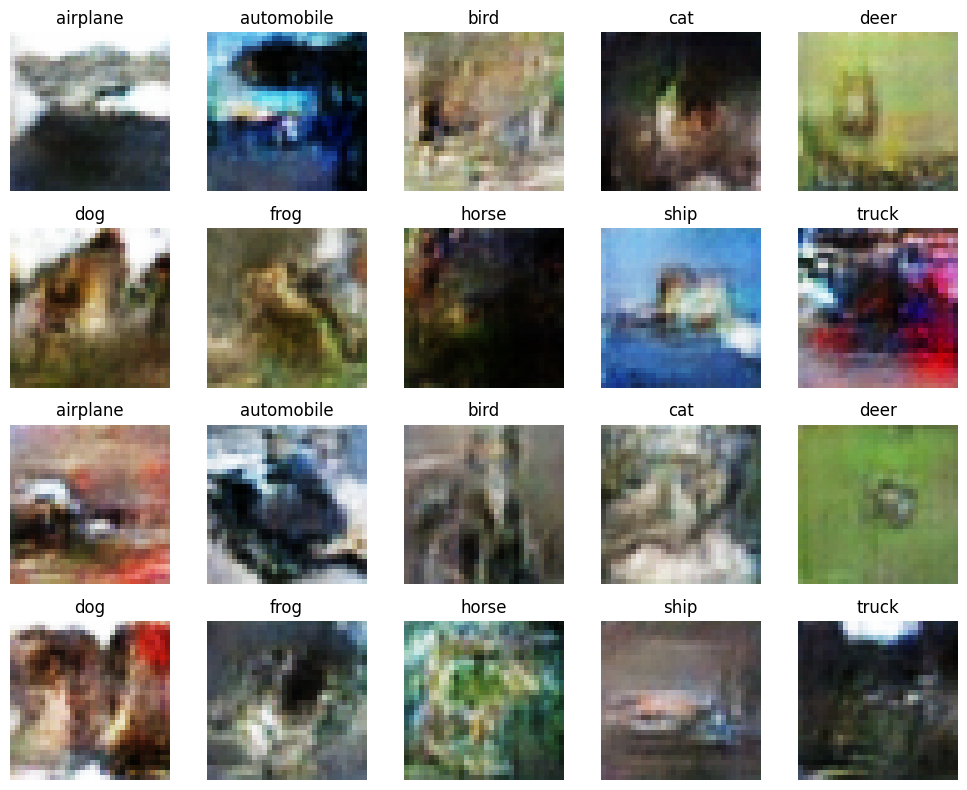

Generator Checkpoint - generator-epoch-20.h5
Epoch 21/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2397 - g_loss: 3.3123 - D(x|y): 0.5012 - D(G(z|y)): 0.1116 - KL Divergence: 4.7930 - acc.: 90.1202
Epoch 22/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.2783 - g_loss: 3.1076 - D(x|y): 0.5006 - D(G(z|y)): 0.1341 - KL Divergence: 4.7630 - acc.: 88.5607
Epoch 23/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.2155 - g_loss: 3.5020 - D(x|y): 0.5002 - D(G(z|y)): 0.1067 - KL Divergence: 4.8883 - acc.: 90.9626
Epoch 24/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2100 - g_loss: 3.6552 - D(x|y): 0.5010 - D(G(z|y)): 0.1030 - KL Divergence: 4.7622 - acc.: 91.3735
Epoch 25/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.2204 - g_loss: 3.6083 - D(x|y): 0.4997 - D(G(z|y)): 0.1112 - KL Divergence: 4.8670 - acc.: 91.1502
Epoch 26/150
391/391 [==============================] -

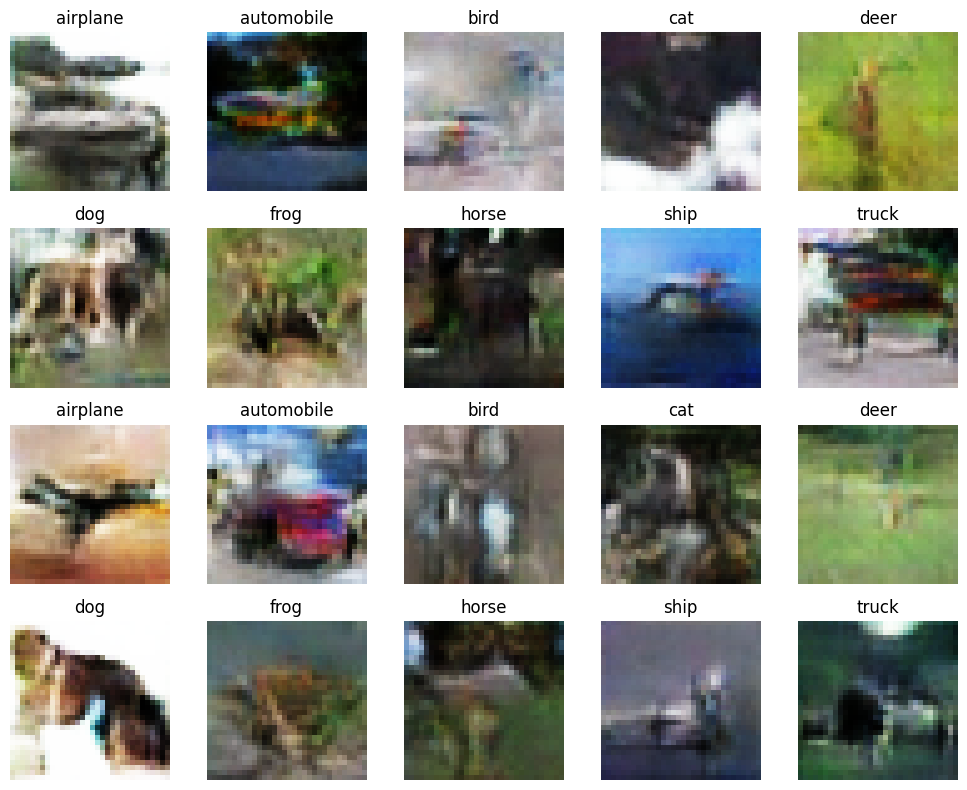

Generator Checkpoint - generator-epoch-30.h5
Epoch 31/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1513 - g_loss: 4.6703 - D(x|y): 0.5005 - D(G(z|y)): 0.0775 - KL Divergence: 4.7521 - acc.: 93.9846
Epoch 32/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.1475 - g_loss: 4.7820 - D(x|y): 0.5002 - D(G(z|y)): 0.0740 - KL Divergence: 4.7553 - acc.: 94.2038
Epoch 33/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1377 - g_loss: 4.8799 - D(x|y): 0.5008 - D(G(z|y)): 0.0722 - KL Divergence: 4.5738 - acc.: 94.7392
Epoch 34/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.3162 - g_loss: 3.8688 - D(x|y): 0.5003 - D(G(z|y)): 0.1858 - KL Divergence: 4.6980 - acc.: 83.8661
Epoch 35/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.4581 - g_loss: 2.2071 - D(x|y): 0.4977 - D(G(z|y)): 0.2970 - KL Divergence: 4.6821 - acc.: 75.9056
Epoch 36/150
391/391 [==============================] -

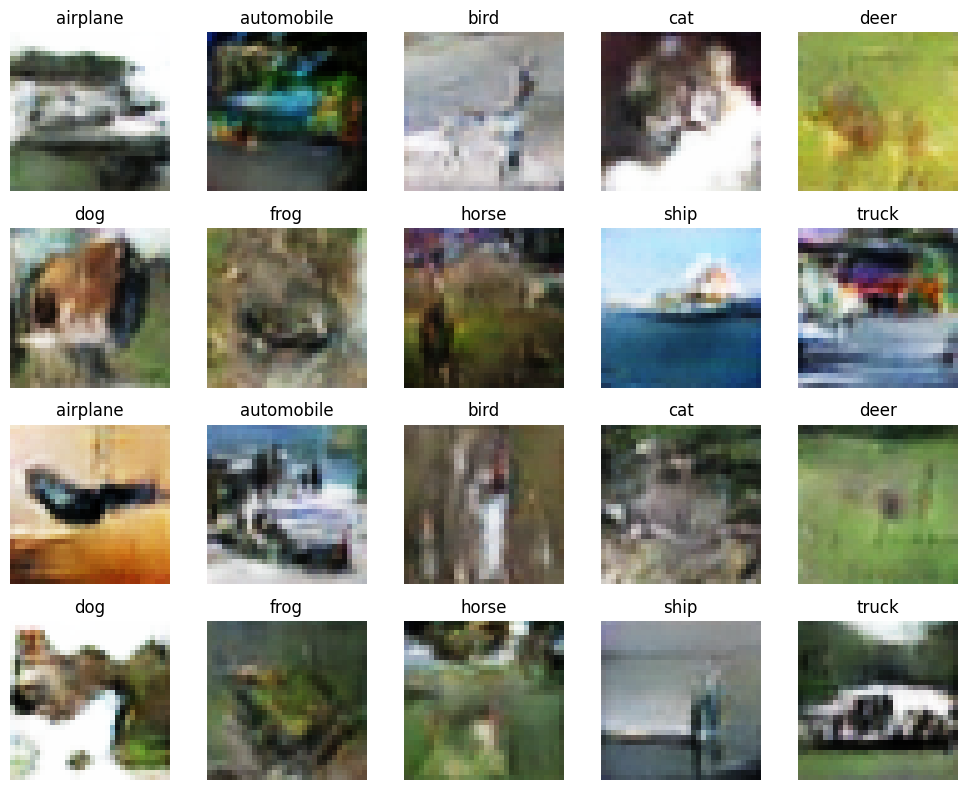

Generator Checkpoint - generator-epoch-40.h5
Epoch 41/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1202 - g_loss: 5.7839 - D(x|y): 0.5006 - D(G(z|y)): 0.0601 - KL Divergence: 4.5230 - acc.: 95.4390
Epoch 42/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1210 - g_loss: 5.7805 - D(x|y): 0.5002 - D(G(z|y)): 0.0624 - KL Divergence: 4.6269 - acc.: 95.5336
Epoch 43/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1076 - g_loss: 6.1770 - D(x|y): 0.5001 - D(G(z|y)): 0.0564 - KL Divergence: 4.5588 - acc.: 95.9266
Epoch 44/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1086 - g_loss: 6.1376 - D(x|y): 0.4999 - D(G(z|y)): 0.0564 - KL Divergence: 4.5601 - acc.: 95.7926
Epoch 45/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.1158 - g_loss: 6.1751 - D(x|y): 0.5001 - D(G(z|y)): 0.0596 - KL Divergence: 4.5162 - acc.: 95.5297
Epoch 46/150
391/391 [==============================] -

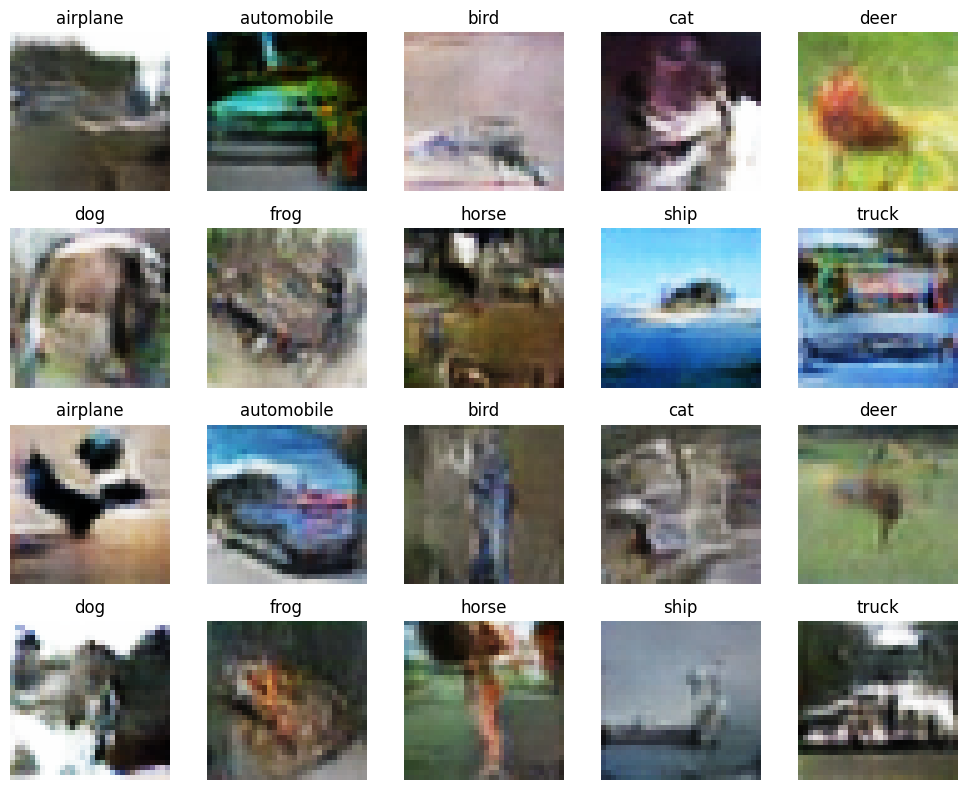

Generator Checkpoint - generator-epoch-50.h5
Epoch 51/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0923 - g_loss: 6.8215 - D(x|y): 0.4999 - D(G(z|y)): 0.0494 - KL Divergence: 4.4705 - acc.: 96.5452
Epoch 52/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0990 - g_loss: 6.7140 - D(x|y): 0.5003 - D(G(z|y)): 0.0521 - KL Divergence: 4.4366 - acc.: 96.2708
Epoch 53/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0947 - g_loss: 6.9120 - D(x|y): 0.5007 - D(G(z|y)): 0.0476 - KL Divergence: 4.5543 - acc.: 96.5168
Epoch 54/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0896 - g_loss: 7.0133 - D(x|y): 0.4999 - D(G(z|y)): 0.0474 - KL Divergence: 4.5778 - acc.: 96.6700
Epoch 55/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0896 - g_loss: 7.0639 - D(x|y): 0.5004 - D(G(z|y)): 0.0464 - KL Divergence: 4.4431 - acc.: 96.6893
Epoch 56/150
391/391 [==============================] -

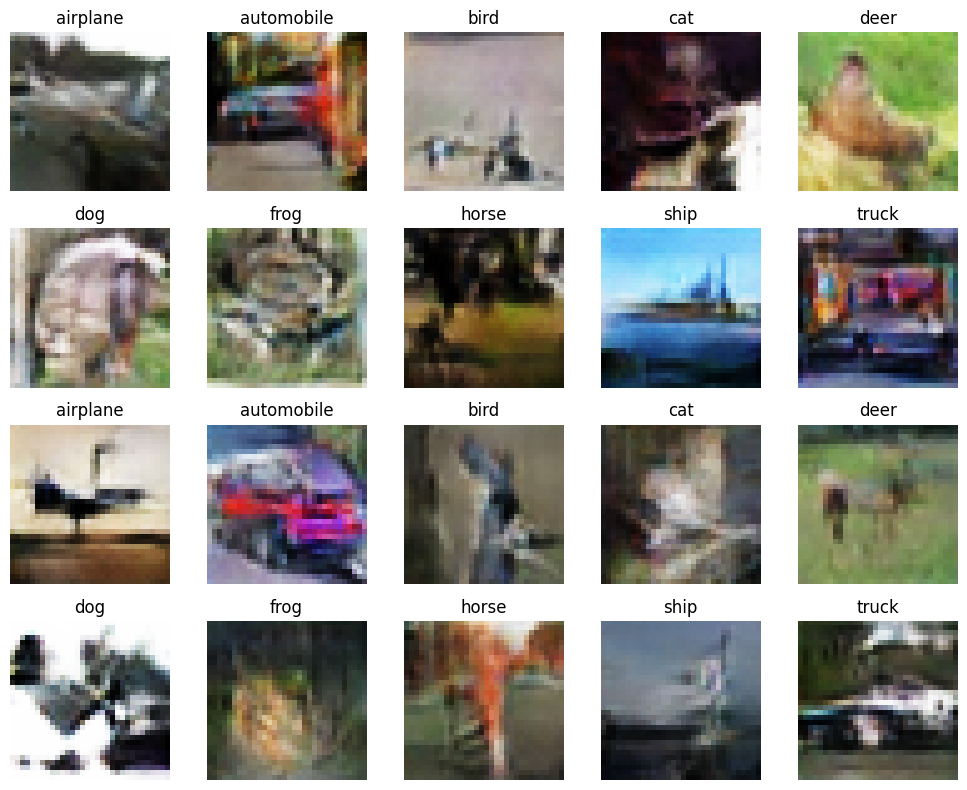

Generator Checkpoint - generator-epoch-60.h5
Epoch 61/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0811 - g_loss: 7.5071 - D(x|y): 0.5000 - D(G(z|y)): 0.0419 - KL Divergence: 4.7036 - acc.: 97.0809
Epoch 62/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0866 - g_loss: 7.3183 - D(x|y): 0.4998 - D(G(z|y)): 0.0455 - KL Divergence: 4.6874 - acc.: 96.7243
Epoch 63/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0860 - g_loss: 7.4289 - D(x|y): 0.5002 - D(G(z|y)): 0.0442 - KL Divergence: 4.6350 - acc.: 96.7646
Epoch 64/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0833 - g_loss: 7.6560 - D(x|y): 0.5004 - D(G(z|y)): 0.0439 - KL Divergence: 4.6568 - acc.: 96.9091
Epoch 65/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0789 - g_loss: 7.7166 - D(x|y): 0.5005 - D(G(z|y)): 0.0406 - KL Divergence: 4.5774 - acc.: 97.1554
Epoch 66/150
391/391 [==============================] -

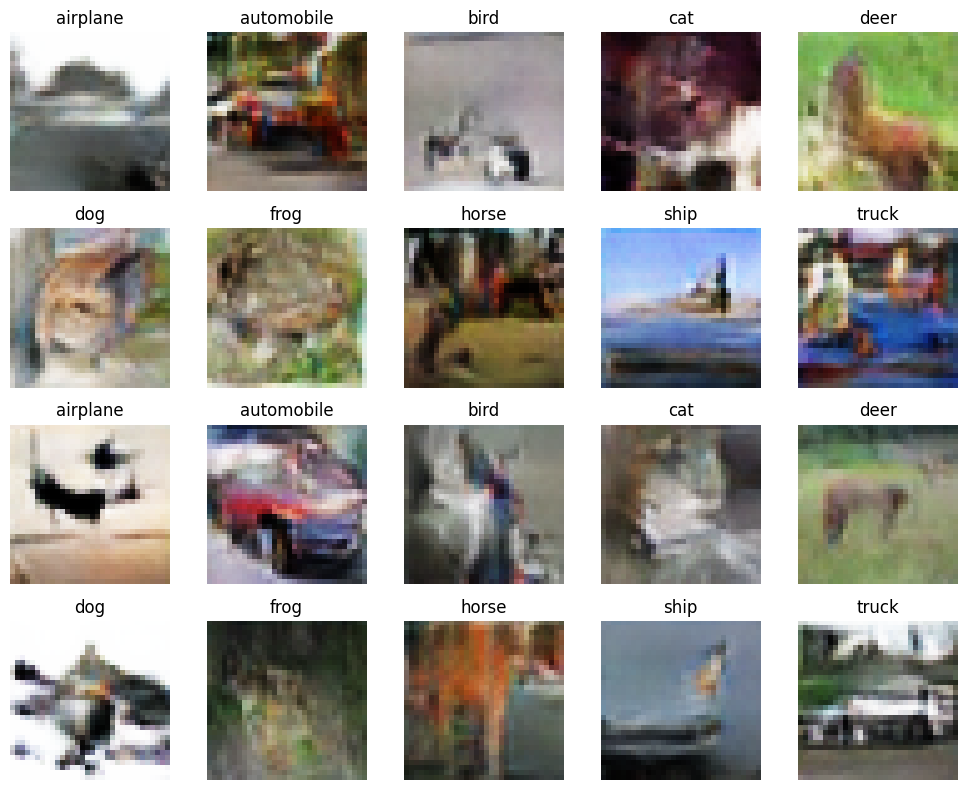

Generator Checkpoint - generator-epoch-70.h5
Epoch 71/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0810 - g_loss: 7.9021 - D(x|y): 0.4998 - D(G(z|y)): 0.0398 - KL Divergence: 4.5202 - acc.: 96.9947
Epoch 72/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0768 - g_loss: 8.0649 - D(x|y): 0.5001 - D(G(z|y)): 0.0377 - KL Divergence: 4.5998 - acc.: 97.2168
Epoch 73/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0784 - g_loss: 8.0550 - D(x|y): 0.5002 - D(G(z|y)): 0.0385 - KL Divergence: 4.6394 - acc.: 97.0308
Epoch 74/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0736 - g_loss: 7.9075 - D(x|y): 0.5004 - D(G(z|y)): 0.0392 - KL Divergence: 4.5776 - acc.: 97.2720
Epoch 75/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0706 - g_loss: 8.2007 - D(x|y): 0.5001 - D(G(z|y)): 0.0380 - KL Divergence: 4.5899 - acc.: 97.4698
Epoch 76/150
391/391 [==============================] -

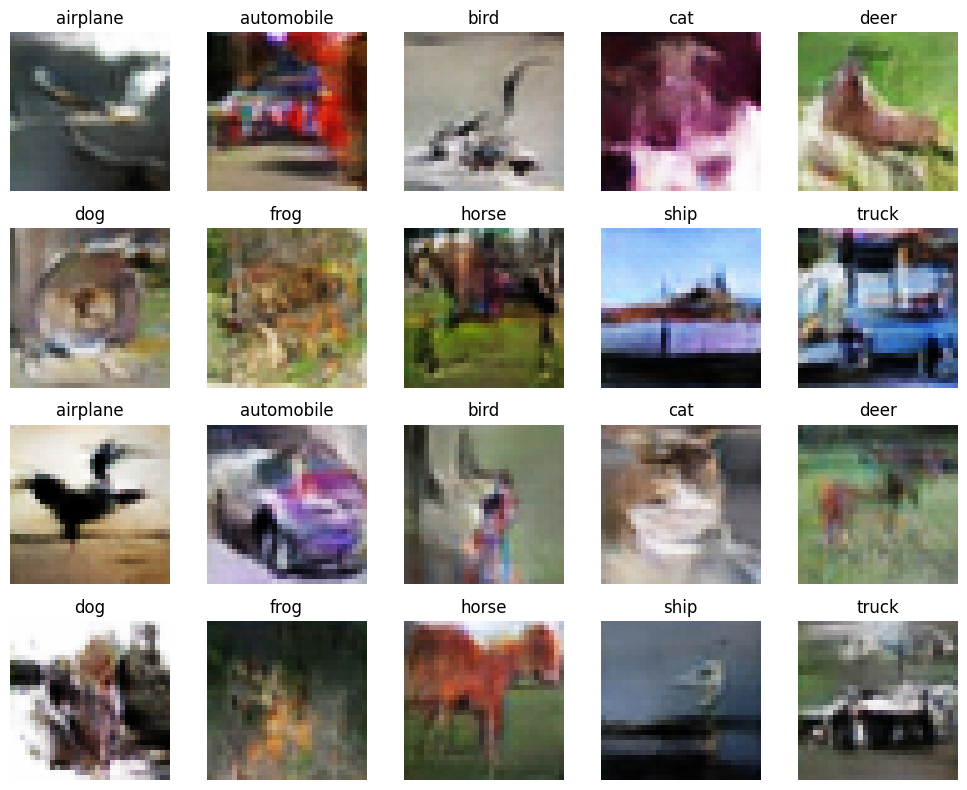

Generator Checkpoint - generator-epoch-80.h5
Epoch 81/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0659 - g_loss: 8.5294 - D(x|y): 0.5004 - D(G(z|y)): 0.0353 - KL Divergence: 4.5542 - acc.: 97.6136
Epoch 82/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0726 - g_loss: 8.4242 - D(x|y): 0.5005 - D(G(z|y)): 0.0368 - KL Divergence: 4.5415 - acc.: 97.4277
Epoch 83/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0644 - g_loss: 8.5986 - D(x|y): 0.5001 - D(G(z|y)): 0.0350 - KL Divergence: 4.4796 - acc.: 97.5932
Epoch 84/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0728 - g_loss: 8.5425 - D(x|y): 0.5003 - D(G(z|y)): 0.0358 - KL Divergence: 4.4381 - acc.: 97.2852
Epoch 85/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0692 - g_loss: 8.5812 - D(x|y): 0.5004 - D(G(z|y)): 0.0361 - KL Divergence: 4.4700 - acc.: 97.4672
Epoch 86/150
391/391 [==============================] -

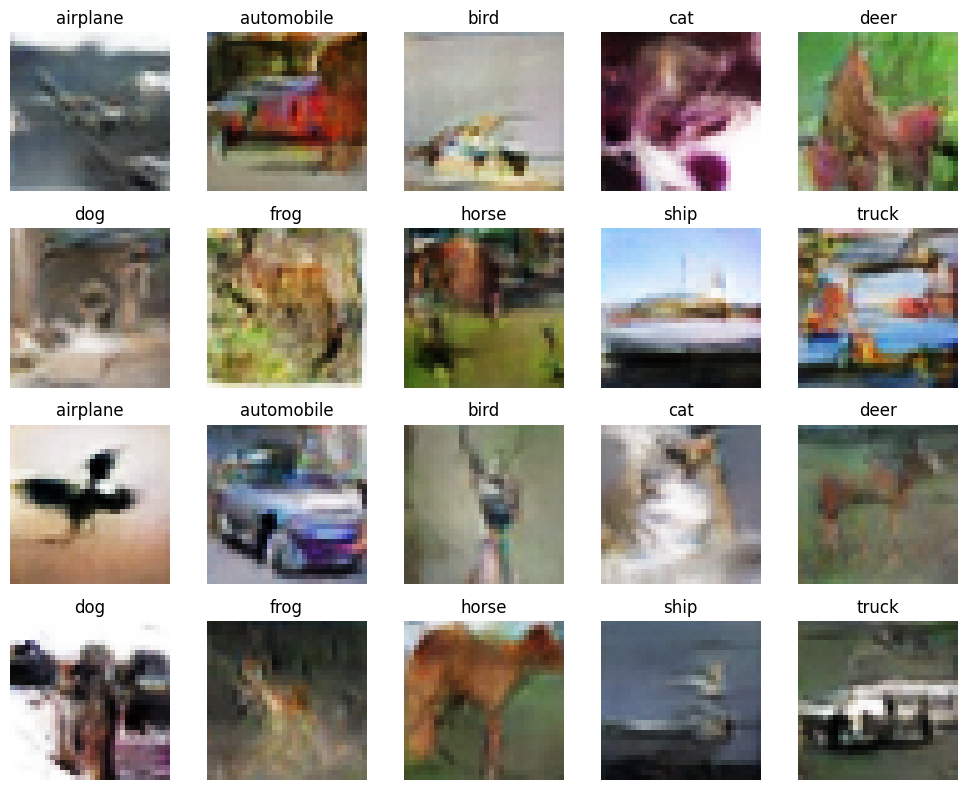

Generator Checkpoint - generator-epoch-90.h5
Epoch 91/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0620 - g_loss: 8.8407 - D(x|y): 0.5003 - D(G(z|y)): 0.0317 - KL Divergence: 4.5458 - acc.: 97.7459
Epoch 92/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0593 - g_loss: 8.9936 - D(x|y): 0.5005 - D(G(z|y)): 0.0315 - KL Divergence: 4.4705 - acc.: 97.8558
Epoch 93/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0566 - g_loss: 8.8288 - D(x|y): 0.5001 - D(G(z|y)): 0.0306 - KL Divergence: 4.5137 - acc.: 97.9072
Epoch 94/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0591 - g_loss: 8.9791 - D(x|y): 0.5002 - D(G(z|y)): 0.0324 - KL Divergence: 4.5170 - acc.: 97.8847
Epoch 95/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0613 - g_loss: 9.2351 - D(x|y): 0.5002 - D(G(z|y)): 0.0310 - KL Divergence: 4.6385 - acc.: 97.7291
Epoch 96/150
391/391 [==============================] -

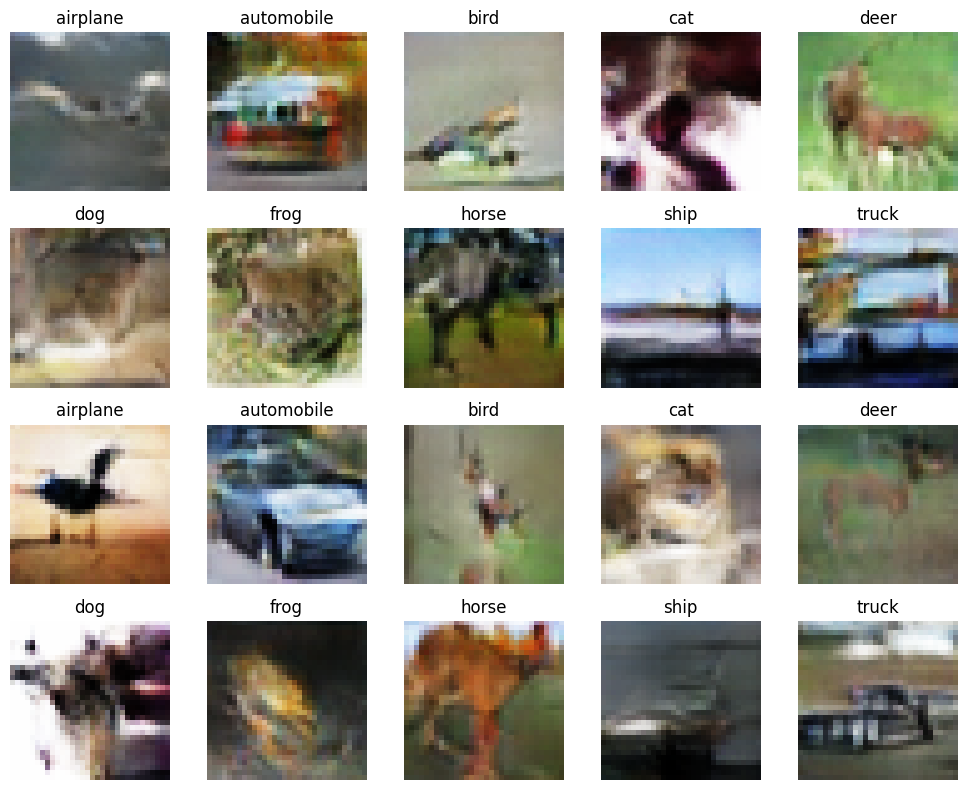

Generator Checkpoint - generator-epoch-100.h5
Epoch 101/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0552 - g_loss: 9.3038 - D(x|y): 0.4996 - D(G(z|y)): 0.0277 - KL Divergence: 4.4153 - acc.: 97.9962
Epoch 102/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0570 - g_loss: 9.2806 - D(x|y): 0.5002 - D(G(z|y)): 0.0295 - KL Divergence: 4.3717 - acc.: 97.9393
Epoch 103/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0560 - g_loss: 9.3196 - D(x|y): 0.4999 - D(G(z|y)): 0.0299 - KL Divergence: 4.3157 - acc.: 97.9730
Epoch 104/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0554 - g_loss: 9.3481 - D(x|y): 0.5005 - D(G(z|y)): 0.0276 - KL Divergence: 4.4128 - acc.: 98.0101
Epoch 105/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0542 - g_loss: 9.3670 - D(x|y): 0.5002 - D(G(z|y)): 0.0289 - KL Divergence: 4.6414 - acc.: 98.0429
Epoch 106/150
391/391 [==========================

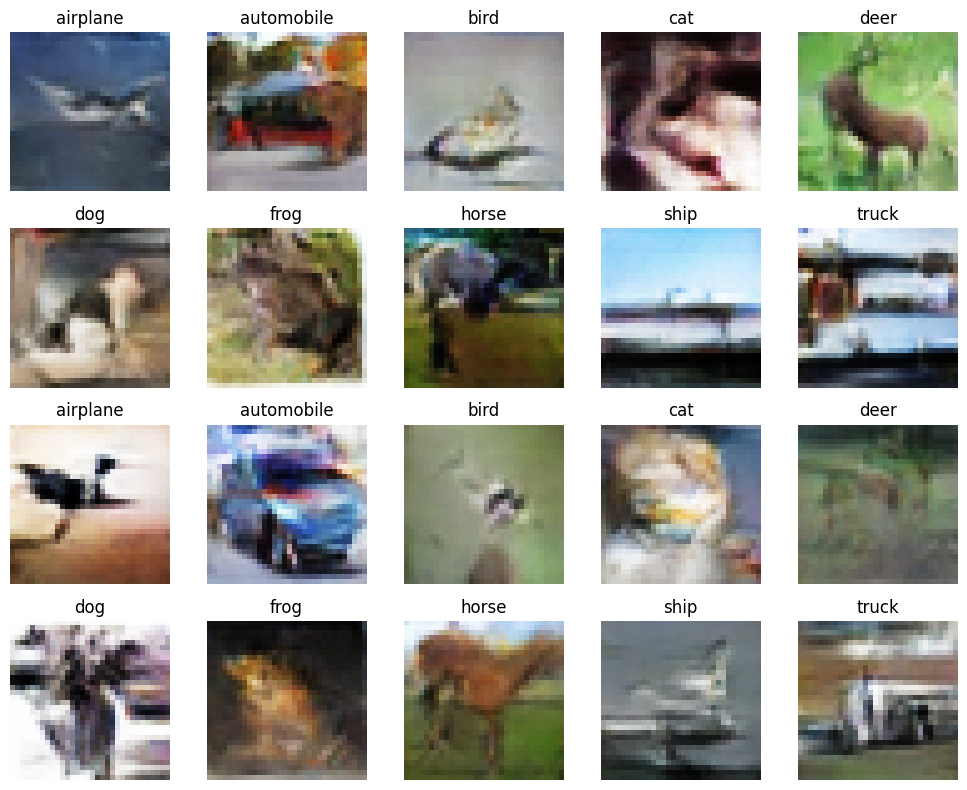

Generator Checkpoint - generator-epoch-110.h5
Epoch 111/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0513 - g_loss: 9.7573 - D(x|y): 0.5003 - D(G(z|y)): 0.0256 - KL Divergence: 4.3382 - acc.: 98.2009
Epoch 112/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0520 - g_loss: 9.8625 - D(x|y): 0.4998 - D(G(z|y)): 0.0252 - KL Divergence: 4.4662 - acc.: 98.1437
Epoch 113/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0506 - g_loss: 9.6393 - D(x|y): 0.5000 - D(G(z|y)): 0.0264 - KL Divergence: 4.3812 - acc.: 98.2099
Epoch 114/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0474 - g_loss: 9.7042 - D(x|y): 0.5002 - D(G(z|y)): 0.0261 - KL Divergence: 4.5147 - acc.: 98.2944
Epoch 115/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0494 - g_loss: 9.9512 - D(x|y): 0.5002 - D(G(z|y)): 0.0254 - KL Divergence: 4.4714 - acc.: 98.2335
Epoch 116/150
391/391 [==========================

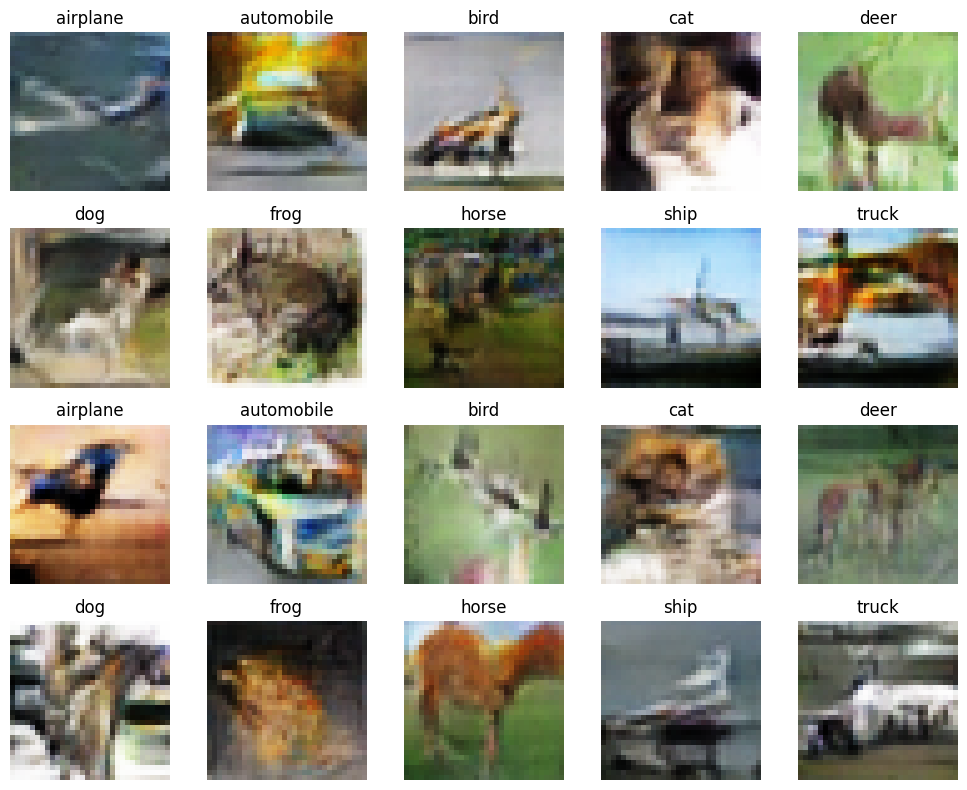

Generator Checkpoint - generator-epoch-120.h5
Epoch 121/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0464 - g_loss: 10.0126 - D(x|y): 0.5001 - D(G(z|y)): 0.0251 - KL Divergence: 4.4691 - acc.: 98.3690
Epoch 122/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0441 - g_loss: 9.8787 - D(x|y): 0.5003 - D(G(z|y)): 0.0236 - KL Divergence: 4.3144 - acc.: 98.4366
Epoch 123/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0435 - g_loss: 10.1492 - D(x|y): 0.4998 - D(G(z|y)): 0.0233 - KL Divergence: 4.4405 - acc.: 98.4039
Epoch 124/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0470 - g_loss: 9.9704 - D(x|y): 0.5002 - D(G(z|y)): 0.0234 - KL Divergence: 4.3652 - acc.: 98.3171
Epoch 125/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0437 - g_loss: 10.1931 - D(x|y): 0.5001 - D(G(z|y)): 0.0239 - KL Divergence: 4.4650 - acc.: 98.4139
Epoch 126/150
391/391 [=======================

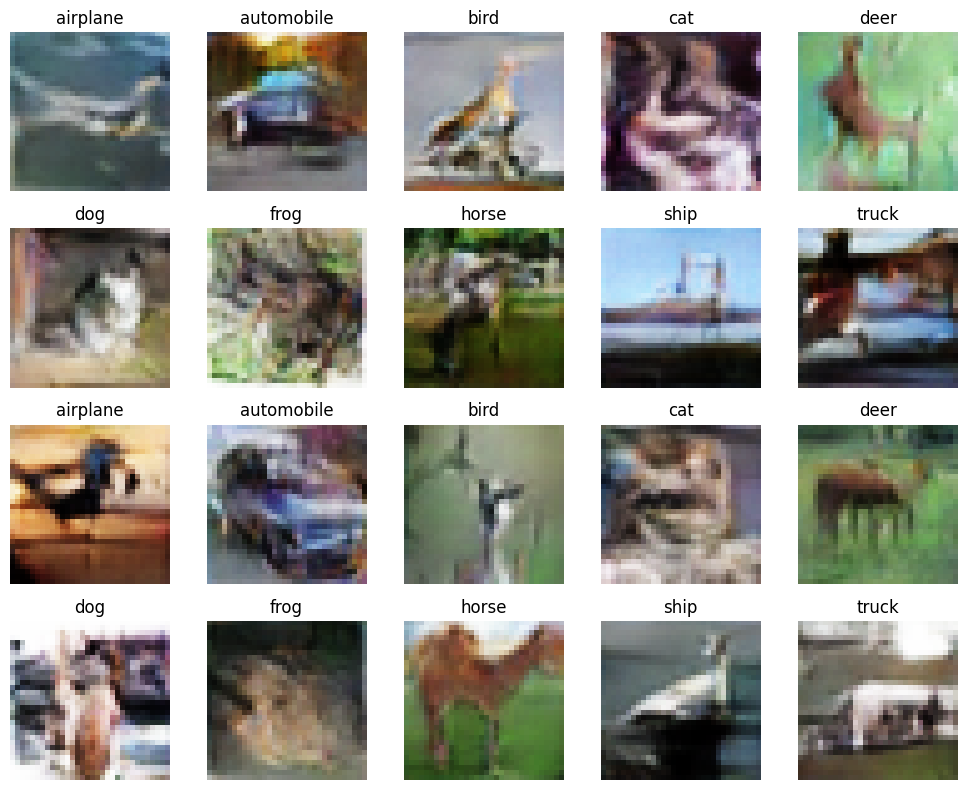

Generator Checkpoint - generator-epoch-130.h5
Epoch 131/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0450 - g_loss: 10.2750 - D(x|y): 0.5004 - D(G(z|y)): 0.0235 - KL Divergence: 4.6068 - acc.: 98.3956
Epoch 132/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0432 - g_loss: 10.3073 - D(x|y): 0.5000 - D(G(z|y)): 0.0222 - KL Divergence: 4.6828 - acc.: 98.4264
Epoch 133/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0452 - g_loss: 10.3310 - D(x|y): 0.5001 - D(G(z|y)): 0.0225 - KL Divergence: 4.5485 - acc.: 98.3986
Epoch 134/150
391/391 [==============================] - 4s 11ms/step - d_loss: 0.0434 - g_loss: 10.2082 - D(x|y): 0.5004 - D(G(z|y)): 0.0221 - KL Divergence: 4.7227 - acc.: 98.4962
Epoch 135/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0426 - g_loss: 10.2875 - D(x|y): 0.5000 - D(G(z|y)): 0.0209 - KL Divergence: 4.5337 - acc.: 98.4887
Epoch 136/150
391/391 [=====================

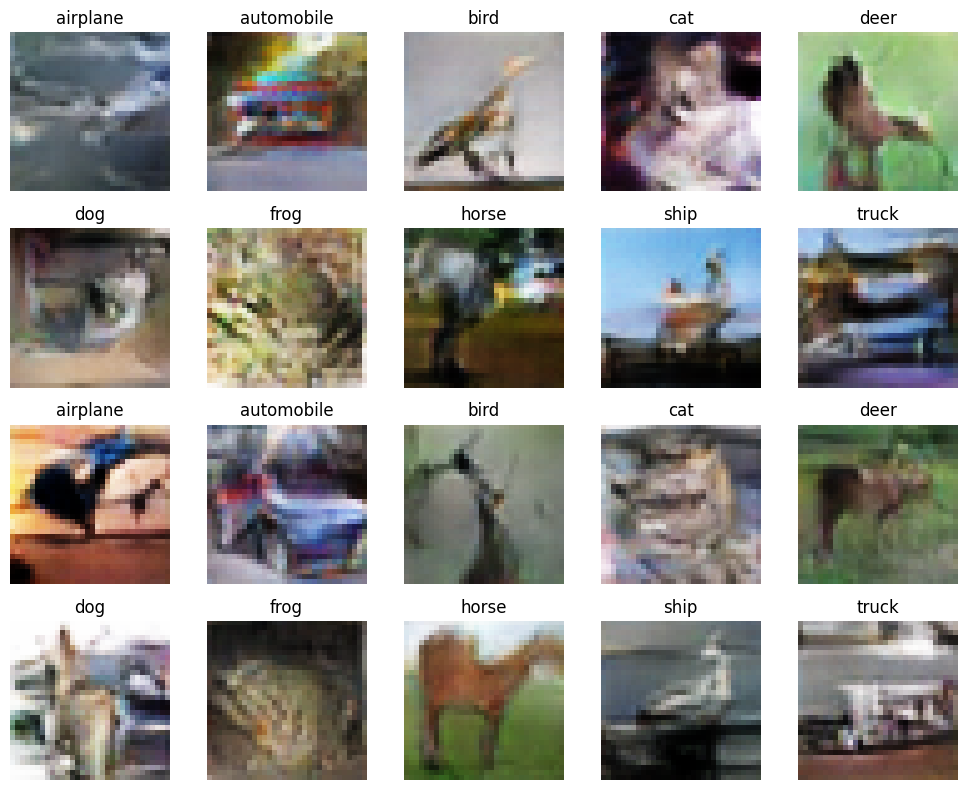

Generator Checkpoint - generator-epoch-140.h5
Epoch 141/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0397 - g_loss: 10.6565 - D(x|y): 0.5001 - D(G(z|y)): 0.0195 - KL Divergence: 4.5737 - acc.: 98.5663
Epoch 142/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0380 - g_loss: 10.7144 - D(x|y): 0.5004 - D(G(z|y)): 0.0198 - KL Divergence: 4.6096 - acc.: 98.6858
Epoch 143/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0391 - g_loss: 10.5820 - D(x|y): 0.4998 - D(G(z|y)): 0.0192 - KL Divergence: 4.6127 - acc.: 98.6092
Epoch 144/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0412 - g_loss: 10.7497 - D(x|y): 0.4999 - D(G(z|y)): 0.0189 - KL Divergence: 4.6731 - acc.: 98.5105
Epoch 145/150
391/391 [==============================] - 4s 10ms/step - d_loss: 0.0365 - g_loss: 10.9082 - D(x|y): 0.5003 - D(G(z|y)): 0.0200 - KL Divergence: 4.6238 - acc.: 98.6143
Epoch 146/150
391/391 [=====================

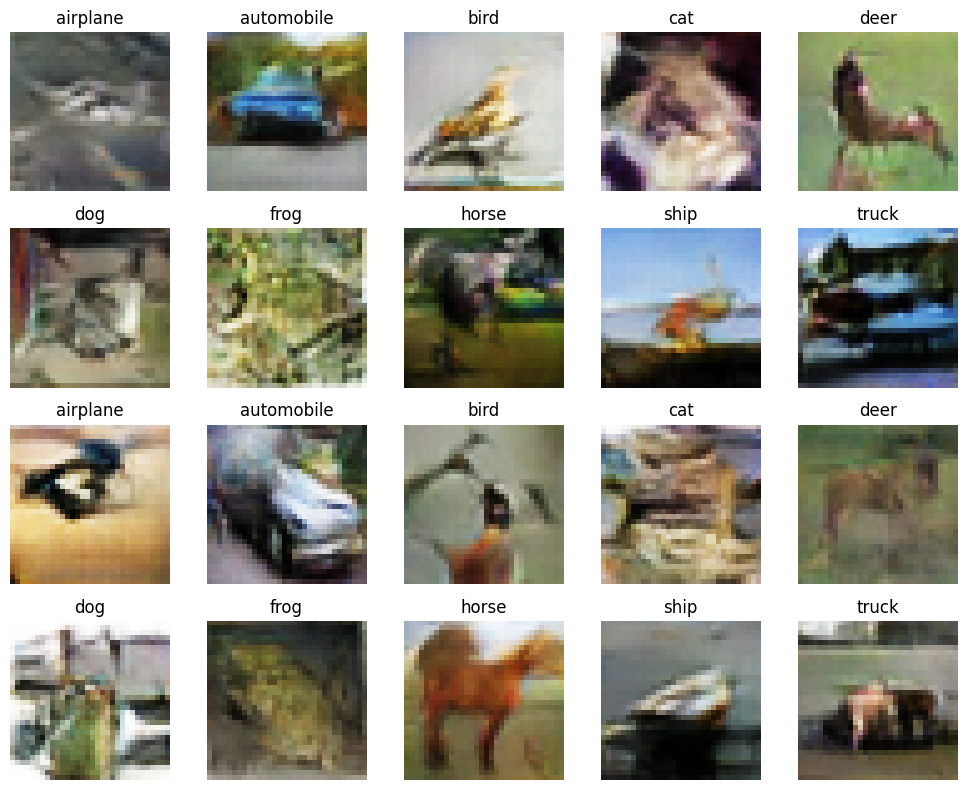

Generator Checkpoint - generator-epoch-Full Train.h5
CPU times: user 10min 47s, sys: 31.1 s, total: 11min 18s
Wall time: 10min 27s


In [ ]:
%%time
# Reseting Graph variables
tf.keras.backend.clear_session()

c_gan=CGAN_model()
# Preparing the Dataset with `tf.data`
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = c_gan.fit(dataset, epochs=150, use_multiprocessing=True, workers=16, callbacks=callbacks)

# CGAN Evaluation

In [ ]:
# Loading Weights for best Generator
saved_weights = 'Img/C_Gan/generator-epoch-100.h5'
c_gan.generator.load_weights(saved_weights)
c_gan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 138)          0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 2048)         284672      ['concatenate_6[0][0]']  

32/32 [==============================] - 0s 6ms/step
Latent Vector Dim: (1024, 128)	Generated Images Dim: (1024, 32, 32, 3)


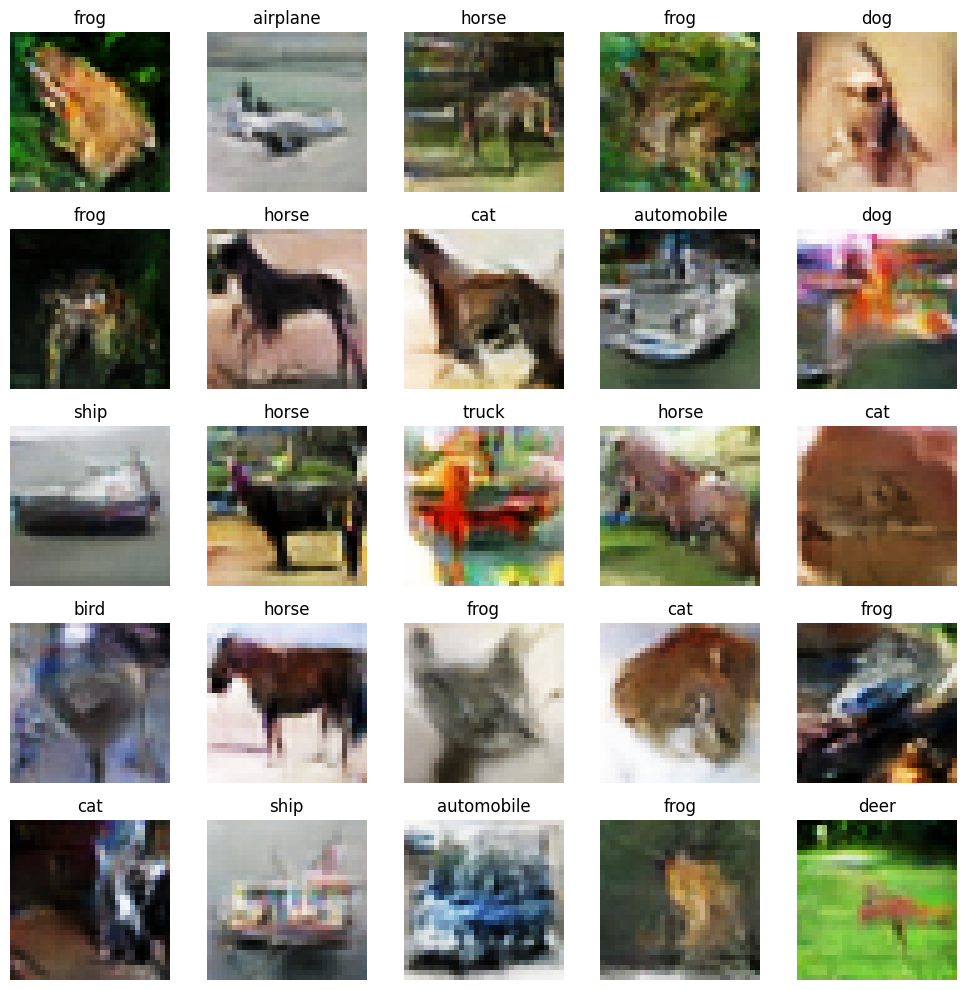

In [ ]:
# generating labels
labels = np.random.randint(low=0, high=10, size=1024)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(1024, 128))

synthetic_images = gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_names[labels[rand_idx]])
    ax.axis('off')
plt.show()

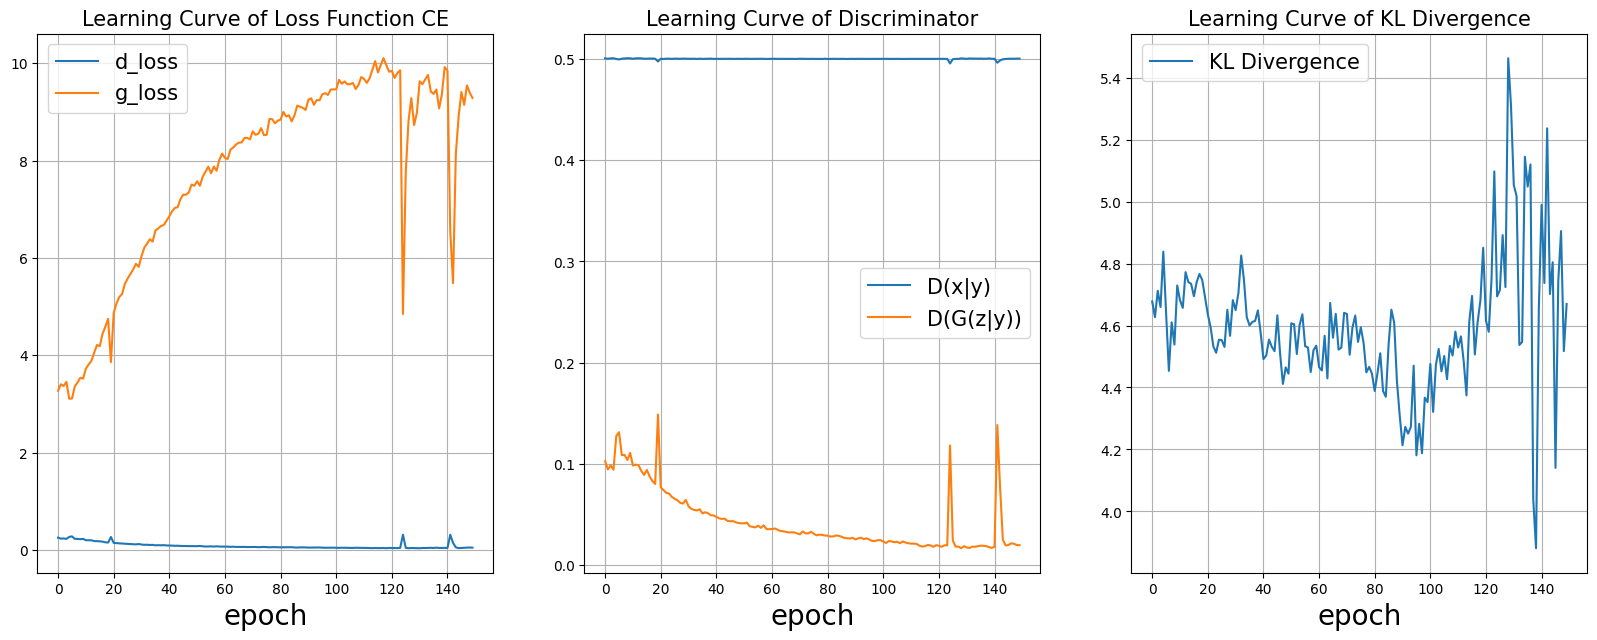

In [ ]:
# function to plot the learning curves
def plot_results(history):
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

    ax1.plot(history['d_loss'], label='d_loss')
    ax1.plot(history['g_loss'], label='g_loss')
    ax2.plot(history['D(x|y)'], label='D(x|y)')
    ax2.plot(history['D(G(z|y))'], label='D(G(z|y))')
    ax3.plot(history['KL Divergence'], label='KL Divergence')

    ax1.legend(fontsize=15);
    ax2.legend(fontsize=15);
    ax3.legend(fontsize=15);

    ax1.set_title('Learning Curve of Loss Function CE', fontsize=15);
    ax1.set_xlabel("epoch", fontsize=20);
    ax2.set_title('Learning Curve of Discriminator', fontsize=15);
    ax2.set_xlabel("epoch", fontsize=20);
    ax3.set_title('Learning Curve of KL Divergence', fontsize=15);
    ax3.set_xlabel("epoch", fontsize=20);

    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True);
    
# plotting the learning curves
plot_results(hist.history)

## Initialize the FID function with additional information(class label) for CGAN

# Fréchet Inception Distance
    Tensorflow implementation of the "Fréchet Inception Distance" (FID) between two image distributions, along with a numpy interface. The FID can be used to evaluate generative models by calculating the FID between real and fake data distributions (A lower FID score indicates that the generated images are of higher quality and are more similar to the target data distribution)

In [ ]:
class GAN_FID:
    def __init__(self, batch_size, latent_dim, sample_size, buffer_size):
        # setting Hyperparameters
        self.BATCH_SIZE = batch_size
        self.LATENT_DIM = latent_dim
        self.SAMPLE_SIZE = sample_size
        self.BUFFER_SIZE = buffer_size

        # setting Constants
        self.INCEPTION_SHAPE = (299, 299, 3)
        self.INCEPTION = InceptionV3(include_top=False, pooling='avg', input_shape=self.INCEPTION_SHAPE)
        self.AUTO = tf.data.AUTOTUNE

    # method to set generator and training data
    def fit(self, generator, train_data):
        # setting generative model and original data used for training 
        self.GENERATOR = generator
        self.train_data = train_data

        # Preparing Real Images
        trainloader = tf.data.Dataset.from_tensor_slices((self.train_data))
        trainloader = (
            trainloader
            .shuffle(self.BUFFER_SIZE)
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.trainloader = trainloader

        # Generate and prepare Synthetic Images (Fake)
        rand_labels = np.random.randint(low=0, high=10, size=self.SAMPLE_SIZE)
        rand_labels = to_categorical(rand_labels)
        noise = tf.random.normal([self.SAMPLE_SIZE, self.LATENT_DIM])

        generated_images = self.GENERATOR([noise, rand_labels])
        genloader = tf.data.Dataset.from_tensor_slices(generated_images)
        genloader = (
            genloader
            .map(self.__resize_and_preprocess, num_parallel_calls=self.AUTO)
            .batch(self.BATCH_SIZE, num_parallel_calls=self.AUTO)
            .prefetch(self.AUTO)
        )
        self.genloader = genloader

        # prepare embeddings
        count = math.ceil(self.SAMPLE_SIZE/self.BATCH_SIZE)

        ## compute embeddings for real images
        print("Computing Real Image Embeddings")
        self.real_image_embeddings = self.__compute_embeddings(self.trainloader, count)

        ## compute embeddings for generated images
        print("Computing Generated Image Embeddings")
        self.generated_image_embeddings = self.__compute_embeddings(self.genloader, count)
        assert self.real_image_embeddings.shape == self.generated_image_embeddings.shape, "Embeddings are not of the same size"
        print("Computed Embeddings\tReal Images Embedding Shape: {}\tGenerated Images Embedding Shape".format(
            self.real_image_embeddings.shape, 
            self.generated_image_embeddings.shape
        ))
    
    # method to produce evaluation results
    @tf.autograph.experimental.do_not_convert
    def evaluate(self):
        # calculate Frechet Inception Distance
        fid = self.__calculate_fid(self.real_image_embeddings, self.generated_image_embeddings)
        print('The computed FID score is:', fid)

        return fid

    # method to generate embeddings from inception model 
    def __compute_embeddings(self, dataloader, count):
        image_embeddings = []
        for _ in tqdm(range(count)):
            images = next(iter(dataloader))
            embeddings = self.INCEPTION.predict(images)
            image_embeddings.extend(embeddings)
        return np.array(image_embeddings)

    ## STATIC METHODS: these methods knows nothing about the class
    # static method to prepare the data before computing Inception Embeddings
    @staticmethod
    def __resize_and_preprocess(image):
        # image *= 255.0 # original image are scaled to [0, 1], scaling back to [0, 255]
        image -= -1
        image /= (1 - (-1))
        image *= 255.

        # .preprocess_input() expects an image of scale [0, 255]
        image = preprocess_input(image)
        # inception model expects an image of shape (None, 299, 299, 3)
        image = tf.image.resize(image, (299, 299), method='nearest')
        return image

    # static method to calculate frechet inception distance based on embeddings
    @staticmethod 
    def __calculate_fid(real_embeddings, generated_embeddings):
        # calculate mean and covariance statistics
        mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
        mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings, rowvar=False)
        # calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)
        # calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))
        # check and correct imaginary numbers from sqrt
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        # calculate score
        fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        return fid

In [ ]:
%%time
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=c_gan.generator, train_data=X_train)
fid_score = fid_class.evaluate()

Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 70ms/step
Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 80ms/step
Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape
The computed FID score is: 91.3267677846793
CPU times: user 8min 8s, sys: 7min 16s, total: 15min 25s
Wall time: 2min 24s


# Inception Score (IS)
    An objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models.

 - The inception score has a lowest value of 1.0 and a highest value of the number of classes supported by the classification model; in this case, the Inception v3 model supports the 10 classes.
 - Therefore, the highest inception score on this dataset is 10.

In [ ]:
inception_is = tf.keras.applications.inception_v3.InceptionV3()
def scale_images(images, shape):
    return tf.image.resize(images, shape, method='nearest')

def inception_score(images, n_splits = 10, eps = 1e-16):
    ## Preprocess image to [0, 255]
    images += 1
    images *= 127.5

    ## Initialize InceptionV3 model process the images appropriately for the model
    processed_images = preprocess_input(images.astype('float32'))

    ## Class Probabilities for images
    scores = list()
    n_part = math.floor(images.shape[0] / n_splits)

    for i in range(n_splits):
        # Retrieve P(y|x)
        start, end = i * n_part, (i+1) * n_part
        subset = scale_images(processed_images[start:end], (299, 299))
        p_yx = inception_is.predict(subset, verbose=0)
        p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
        
        # Calculate the KL Divergence
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # Sum over classes
        sum_kl = kl_d.sum(axis=1)
        # Average over classes
        avg_kl = np.mean(sum_kl)

        is_score = np.exp(avg_kl)
        scores.append(is_score)

    avg_is, std_is = np.mean(scores), np.std(scores)
    return avg_is, std_is

In [ ]:
%%time
one_hot_labels = to_categorical(np.tile(np.arange(10), 1000))
random_noise = tf.random.normal(shape=(10000, 128))

avg_is, std_is= inception_score(c_gan.generator.predict([random_noise, one_hot_labels]))
print('The Average Inception Score is:', avg_is)
print('The Standard Deviation is:', std_is)

313/313 [==============================] - 2s 6ms/step
The Average Inception Score is: 6.5049376
The Standard Deviation is: 0.19938922
CPU times: user 30.2 s, sys: 7.95 s, total: 38.1 s
Wall time: 30 s


# CGAN with Data Augmentation

## Initialize GANMonitor to save weights to different folder

In [ ]:
# Custom callback to display generated images every n epochs and after training
class GANMonitor(keras.callbacks.Callback):
    # class GANMontor
    # - num_img: number of images generated using matplotlib figure
    # - latent_dim: dimensions of noise latent vector passed into the generator
    # - patience: number of epochs to generate images
    # - vmin: minumum scaling factor, a
    # - vmax: maximum scaling factor, b
    def __init__(self, num_img, latent_dim, patience, vmin, vmax):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax


        # making the latent vec
        self.latent_noise_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    # method to generate images and display them as matplotlib figure
    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict([self.latent_noise_vector, self.conditions])

        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)

        # Generate Matplotlib Figure
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_names[i%10])
            ax.axis('off')
        plt.show()

    # method to save generator's weights
    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                #save model weights to Img/C_Gan_Aug Folder
                name='Img/C_Gan_Aug/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    # generate a plot every n epochs
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    # generate a plot after training
    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')

In [ ]:
# List of Callback Functions
callbacks = [
    GANMonitor(num_img=20, latent_dim=128, patience=10, vmin=-1, vmax=1),
]

1/1 [==============================] - 0s 38ms/step


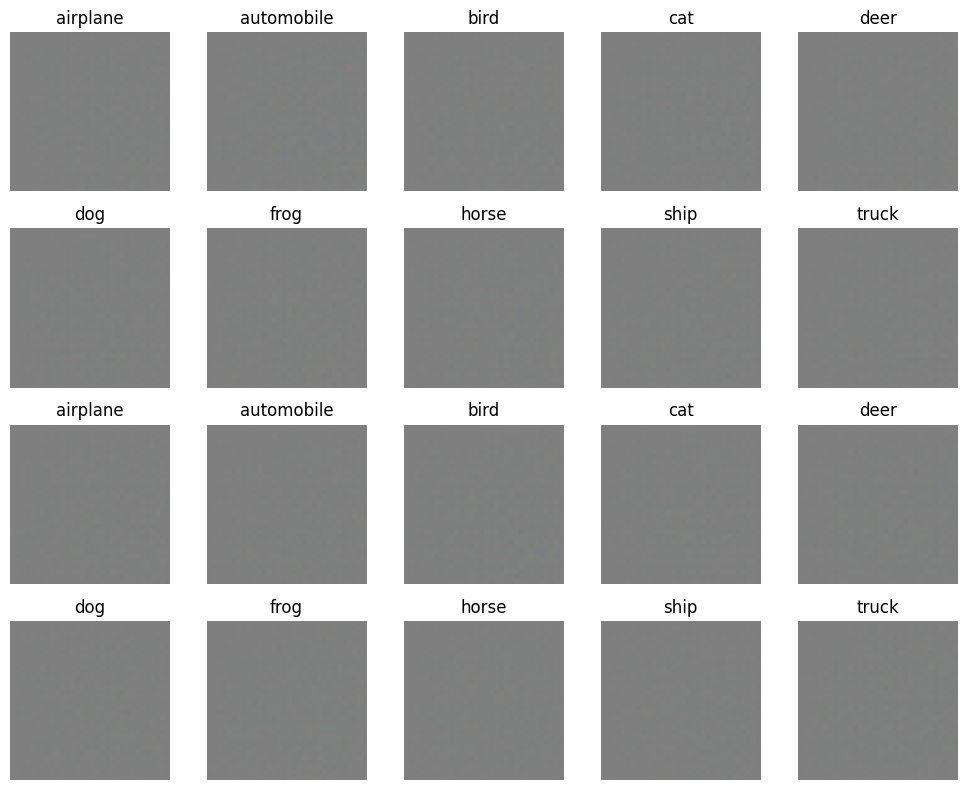

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-0.h5
Epoch 1/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.4429 - g_loss: 2.5387 - D(x|y): 0.5521 - D(G(z|y)): 0.1553 - KL Divergence: 5.7565 - acc.: 85.3378
Epoch 2/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.2268 - g_loss: 4.0805 - D(x|y): 0.4978 - D(G(z|y)): 0.0362 - KL Divergence: 5.2729 - acc.: 92.5233
Epoch 3/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1207 - g_loss: 4.8656 - D(x|y): 0.5011 - D(G(z|y)): 0.0175 - KL Divergence: 6.6554 - acc.: 96.1550
Epoch 4/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1730 - g_loss: 4.1679 - D(x|y): 0.4992 - D(G(z|y)): 0.0314 - KL Divergence: 6.1330 - acc.: 93.7840
Epoch 5/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1932 - g_loss: 3.9710 - D(x|y): 0.5007 - D(G(z|y)): 0.0365 - KL Divergence: 4.8685 - acc.: 92.4378
Epoch 6/110
782/782 [=====================

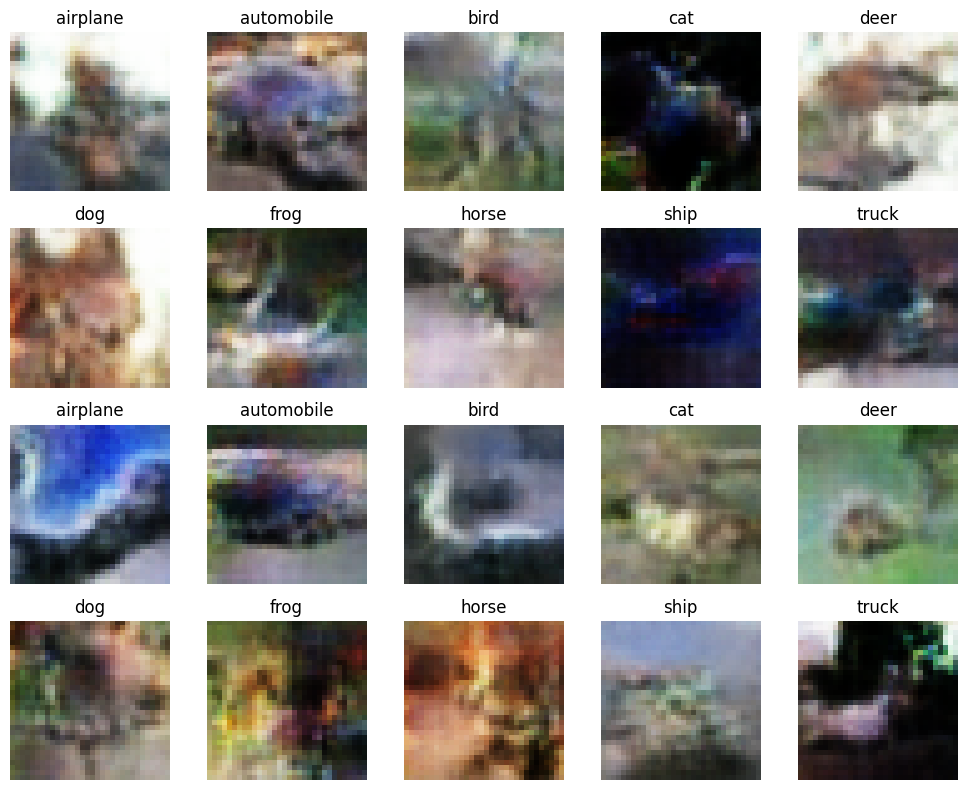

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-10.h5
Epoch 11/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.3139 - g_loss: 2.6090 - D(x|y): 0.4987 - D(G(z|y)): 0.1520 - KL Divergence: 4.7461 - acc.: 86.3732
Epoch 12/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.2859 - g_loss: 2.8246 - D(x|y): 0.4998 - D(G(z|y)): 0.1368 - KL Divergence: 4.6307 - acc.: 87.7171
Epoch 13/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.2699 - g_loss: 2.9046 - D(x|y): 0.5000 - D(G(z|y)): 0.1347 - KL Divergence: 4.6214 - acc.: 88.6575
Epoch 14/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.2475 - g_loss: 3.0483 - D(x|y): 0.4999 - D(G(z|y)): 0.1260 - KL Divergence: 4.7143 - acc.: 89.6077
Epoch 15/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.2310 - g_loss: 3.2604 - D(x|y): 0.5003 - D(G(z|y)): 0.1186 - KL Divergence: 4.6749 - acc.: 90.3923
Epoch 16/110
782/782 [==============

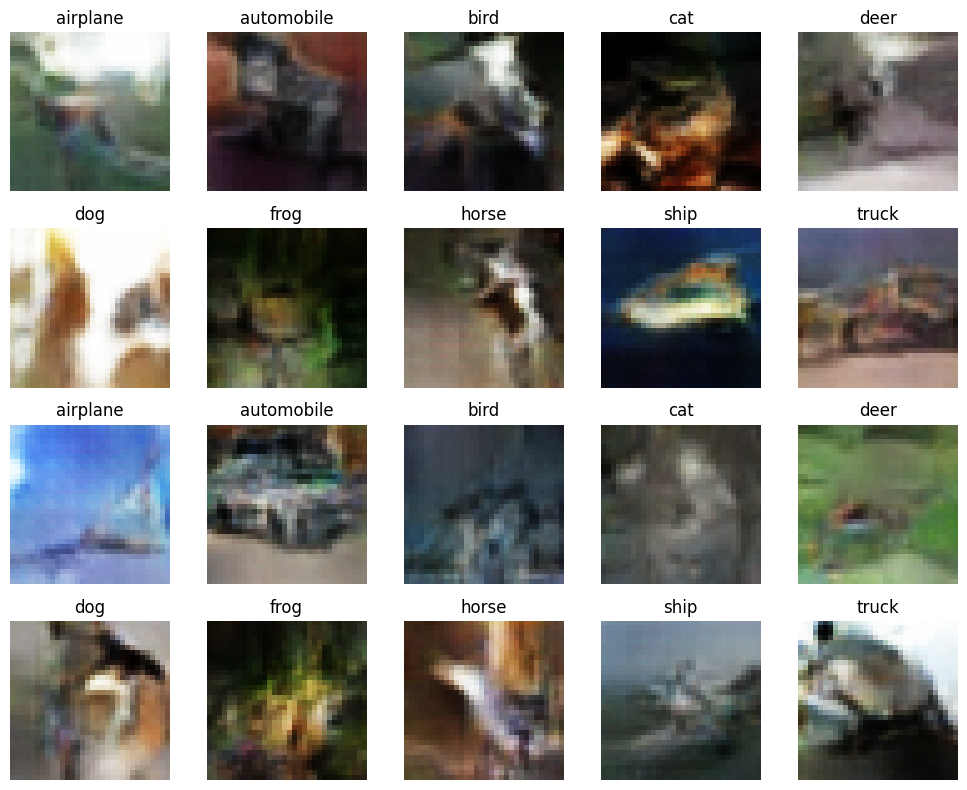

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-20.h5
Epoch 21/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1774 - g_loss: 4.2511 - D(x|y): 0.5019 - D(G(z|y)): 0.0911 - KL Divergence: 4.5752 - acc.: 92.8814
Epoch 22/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1593 - g_loss: 4.4755 - D(x|y): 0.4997 - D(G(z|y)): 0.0825 - KL Divergence: 4.5801 - acc.: 93.6663
Epoch 23/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1497 - g_loss: 4.7205 - D(x|y): 0.5000 - D(G(z|y)): 0.0776 - KL Divergence: 4.5845 - acc.: 93.9891
Epoch 24/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.1523 - g_loss: 4.7499 - D(x|y): 0.4997 - D(G(z|y)): 0.0789 - KL Divergence: 4.6410 - acc.: 94.0105
Epoch 25/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.1358 - g_loss: 5.0386 - D(x|y): 0.4998 - D(G(z|y)): 0.0709 - KL Divergence: 4.5434 - acc.: 94.7635
Epoch 26/110
782/782 [==============

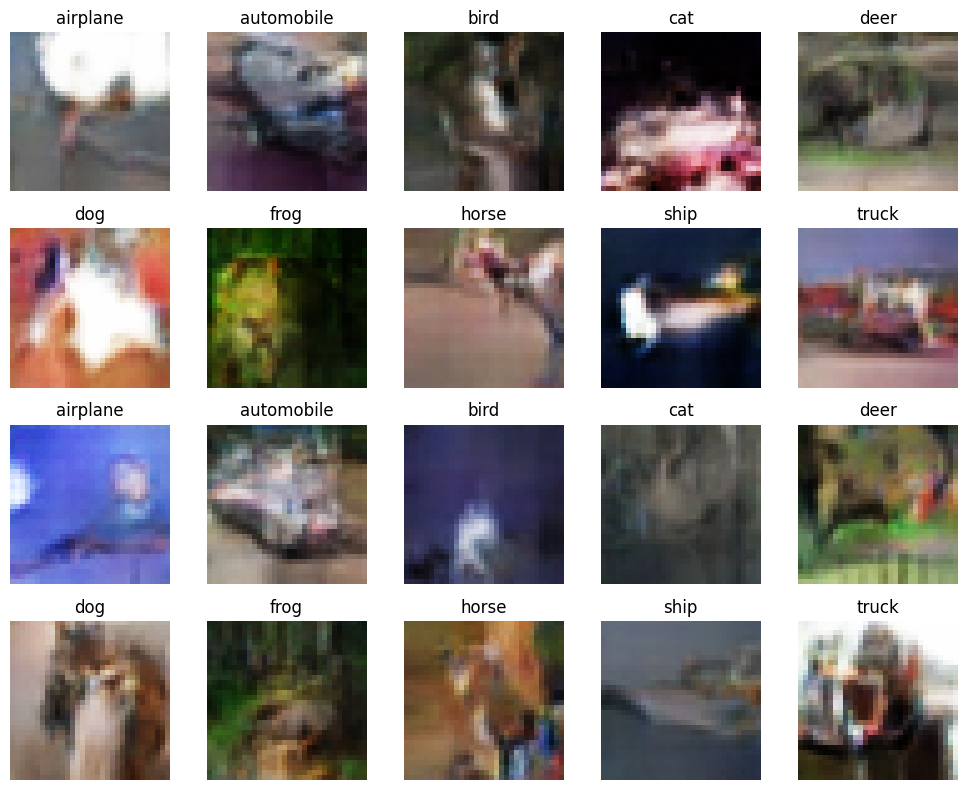

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-30.h5
Epoch 31/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1226 - g_loss: 5.7087 - D(x|y): 0.4999 - D(G(z|y)): 0.0599 - KL Divergence: 4.5928 - acc.: 95.3061
Epoch 32/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1205 - g_loss: 5.7896 - D(x|y): 0.5000 - D(G(z|y)): 0.0617 - KL Divergence: 4.6135 - acc.: 95.3637
Epoch 33/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1906 - g_loss: 4.8511 - D(x|y): 0.5005 - D(G(z|y)): 0.1122 - KL Divergence: 4.7230 - acc.: 91.7341
Epoch 34/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1158 - g_loss: 5.9620 - D(x|y): 0.5002 - D(G(z|y)): 0.0598 - KL Divergence: 4.6501 - acc.: 95.5025
Epoch 35/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.1108 - g_loss: 6.0865 - D(x|y): 0.5004 - D(G(z|y)): 0.0584 - KL Divergence: 4.6383 - acc.: 95.6882
Epoch 36/110
782/782 [==============

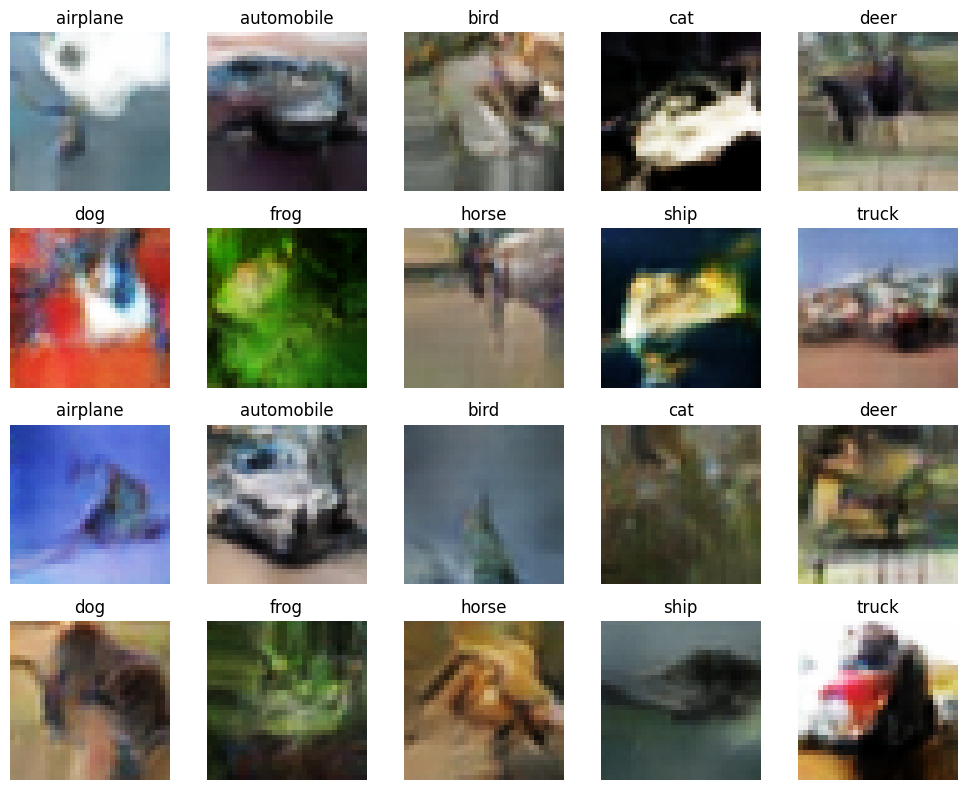

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-40.h5
Epoch 41/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.1033 - g_loss: 6.5322 - D(x|y): 0.5002 - D(G(z|y)): 0.0533 - KL Divergence: 4.4778 - acc.: 96.1058
Epoch 42/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.1011 - g_loss: 6.6065 - D(x|y): 0.5005 - D(G(z|y)): 0.0518 - KL Divergence: 4.5280 - acc.: 96.1398
Epoch 43/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0995 - g_loss: 6.6152 - D(x|y): 0.4999 - D(G(z|y)): 0.0500 - KL Divergence: 4.5314 - acc.: 96.3020
Epoch 44/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0956 - g_loss: 6.7820 - D(x|y): 0.5002 - D(G(z|y)): 0.0496 - KL Divergence: 4.3683 - acc.: 96.4435
Epoch 45/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.1001 - g_loss: 6.7544 - D(x|y): 0.4999 - D(G(z|y)): 0.0509 - KL Divergence: 4.5704 - acc.: 96.1740
Epoch 46/110
782/782 [==============

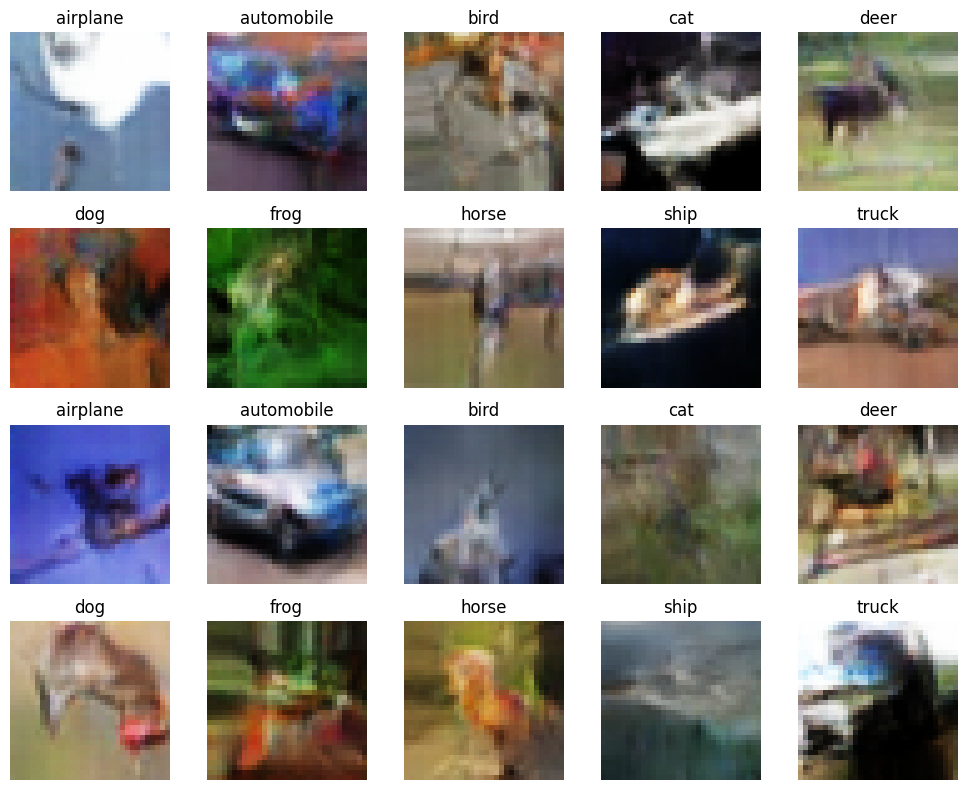

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-50.h5
Epoch 51/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0826 - g_loss: 7.2503 - D(x|y): 0.5001 - D(G(z|y)): 0.0420 - KL Divergence: 4.6205 - acc.: 96.9345
Epoch 52/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0928 - g_loss: 7.1357 - D(x|y): 0.5011 - D(G(z|y)): 0.0448 - KL Divergence: 4.4596 - acc.: 96.5365
Epoch 53/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0826 - g_loss: 7.3617 - D(x|y): 0.5001 - D(G(z|y)): 0.0432 - KL Divergence: 4.6143 - acc.: 96.8756
Epoch 54/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0866 - g_loss: 7.3183 - D(x|y): 0.5001 - D(G(z|y)): 0.0419 - KL Divergence: 4.6350 - acc.: 96.7100
Epoch 55/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0807 - g_loss: 7.4516 - D(x|y): 0.5004 - D(G(z|y)): 0.0405 - KL Divergence: 4.6376 - acc.: 97.0080
Epoch 56/110
782/782 [==============

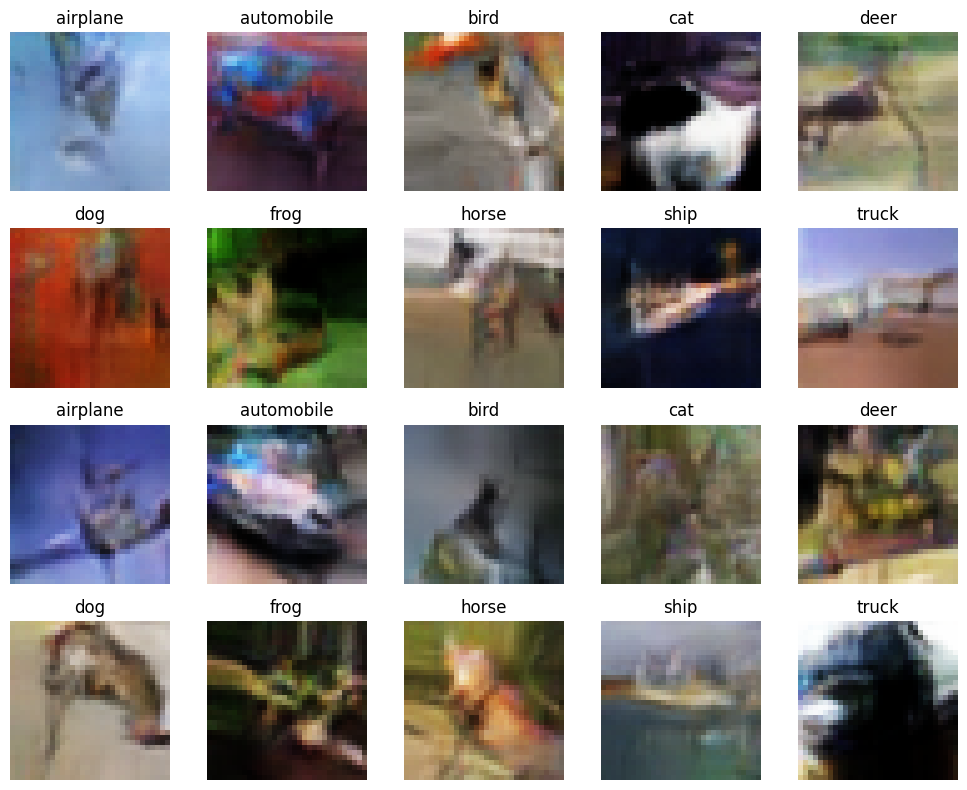

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-60.h5
Epoch 61/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0697 - g_loss: 7.8988 - D(x|y): 0.5003 - D(G(z|y)): 0.0376 - KL Divergence: 4.5623 - acc.: 97.4498
Epoch 62/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.0730 - g_loss: 7.9803 - D(x|y): 0.4999 - D(G(z|y)): 0.0372 - KL Divergence: 4.7035 - acc.: 97.3032
Epoch 63/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.0768 - g_loss: 7.8302 - D(x|y): 0.5001 - D(G(z|y)): 0.0380 - KL Divergence: 4.4585 - acc.: 97.2386
Epoch 64/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0723 - g_loss: 7.9951 - D(x|y): 0.5007 - D(G(z|y)): 0.0359 - KL Divergence: 4.4700 - acc.: 97.3424
Epoch 65/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0746 - g_loss: 7.9132 - D(x|y): 0.5003 - D(G(z|y)): 0.0384 - KL Divergence: 4.5325 - acc.: 97.2657
Epoch 66/110
782/782 [==============

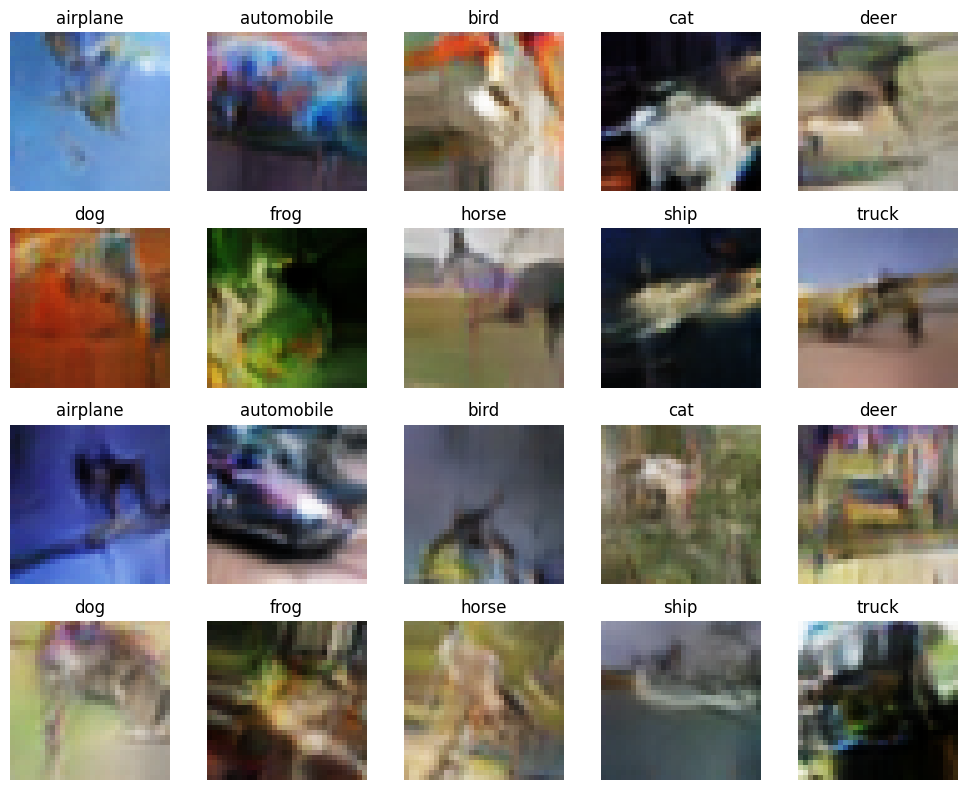

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-70.h5
Epoch 71/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0668 - g_loss: 8.2718 - D(x|y): 0.5002 - D(G(z|y)): 0.0349 - KL Divergence: 4.6495 - acc.: 97.5502
Epoch 72/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0643 - g_loss: 8.3755 - D(x|y): 0.5005 - D(G(z|y)): 0.0318 - KL Divergence: 4.6031 - acc.: 97.7289
Epoch 73/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0668 - g_loss: 8.3216 - D(x|y): 0.5006 - D(G(z|y)): 0.0335 - KL Divergence: 4.6488 - acc.: 97.6410
Epoch 74/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0650 - g_loss: 8.3996 - D(x|y): 0.5002 - D(G(z|y)): 0.0325 - KL Divergence: 4.5719 - acc.: 97.6331
Epoch 75/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.1754 - g_loss: 6.6019 - D(x|y): 0.4988 - D(G(z|y)): 0.0773 - KL Divergence: 4.7040 - acc.: 93.7017
Epoch 76/110
782/782 [==============

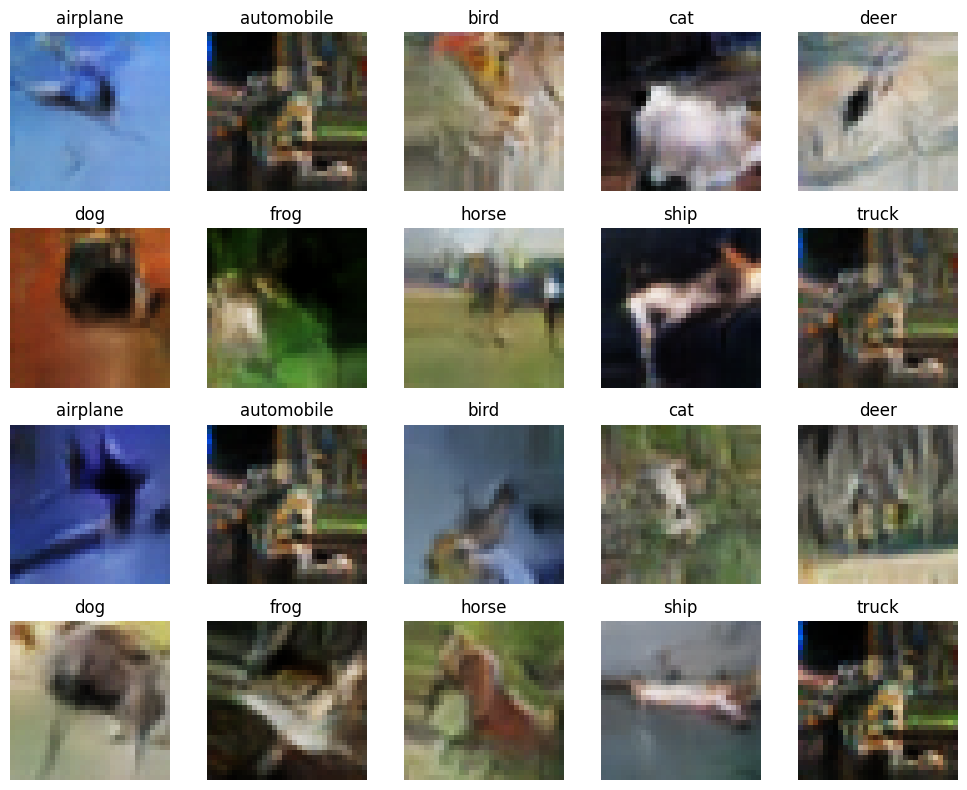

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-80.h5
Epoch 81/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0749 - g_loss: 7.8968 - D(x|y): 0.5002 - D(G(z|y)): 0.0339 - KL Divergence: 4.9981 - acc.: 97.2828
Epoch 82/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0625 - g_loss: 8.2875 - D(x|y): 0.5002 - D(G(z|y)): 0.0292 - KL Divergence: 4.5712 - acc.: 97.7736
Epoch 83/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0780 - g_loss: 8.3449 - D(x|y): 0.4998 - D(G(z|y)): 0.0333 - KL Divergence: 4.2484 - acc.: 97.4627
Epoch 84/110
782/782 [==============================] - 40s 51ms/step - d_loss: 0.0778 - g_loss: 8.2386 - D(x|y): 0.5001 - D(G(z|y)): 0.0334 - KL Divergence: 4.6223 - acc.: 97.2538
Epoch 85/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.0639 - g_loss: 8.2614 - D(x|y): 0.5002 - D(G(z|y)): 0.0294 - KL Divergence: 3.7310 - acc.: 97.7468
Epoch 86/110
782/782 [==============

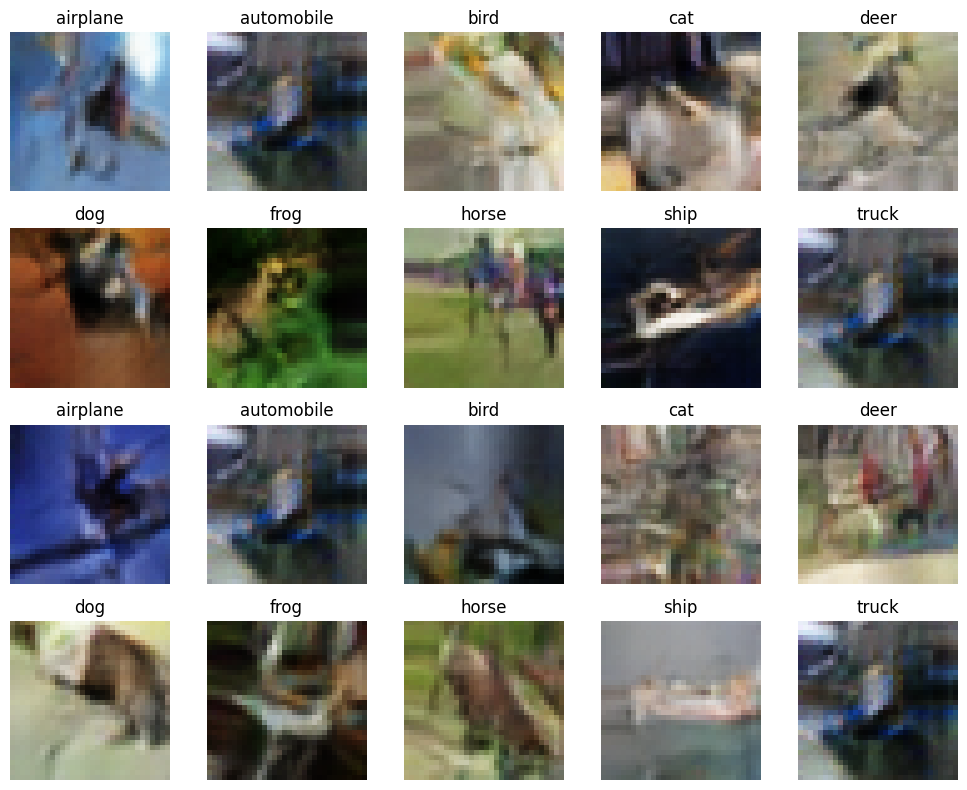

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-90.h5
Epoch 91/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0599 - g_loss: 7.9819 - D(x|y): 0.5007 - D(G(z|y)): 0.0305 - KL Divergence: 5.3183 - acc.: 97.8231
Epoch 92/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0656 - g_loss: 8.6558 - D(x|y): 0.5003 - D(G(z|y)): 0.0292 - KL Divergence: 4.3050 - acc.: 97.6074
Epoch 93/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0704 - g_loss: 8.2516 - D(x|y): 0.5003 - D(G(z|y)): 0.0329 - KL Divergence: 4.1682 - acc.: 97.4647
Epoch 94/110
782/782 [==============================] - 42s 54ms/step - d_loss: 0.0808 - g_loss: 8.1531 - D(x|y): 0.5005 - D(G(z|y)): 0.0327 - KL Divergence: 4.9134 - acc.: 97.1458
Epoch 95/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.0629 - g_loss: 8.1857 - D(x|y): 0.5004 - D(G(z|y)): 0.0292 - KL Divergence: 4.8939 - acc.: 97.6934
Epoch 96/110
782/782 [==============

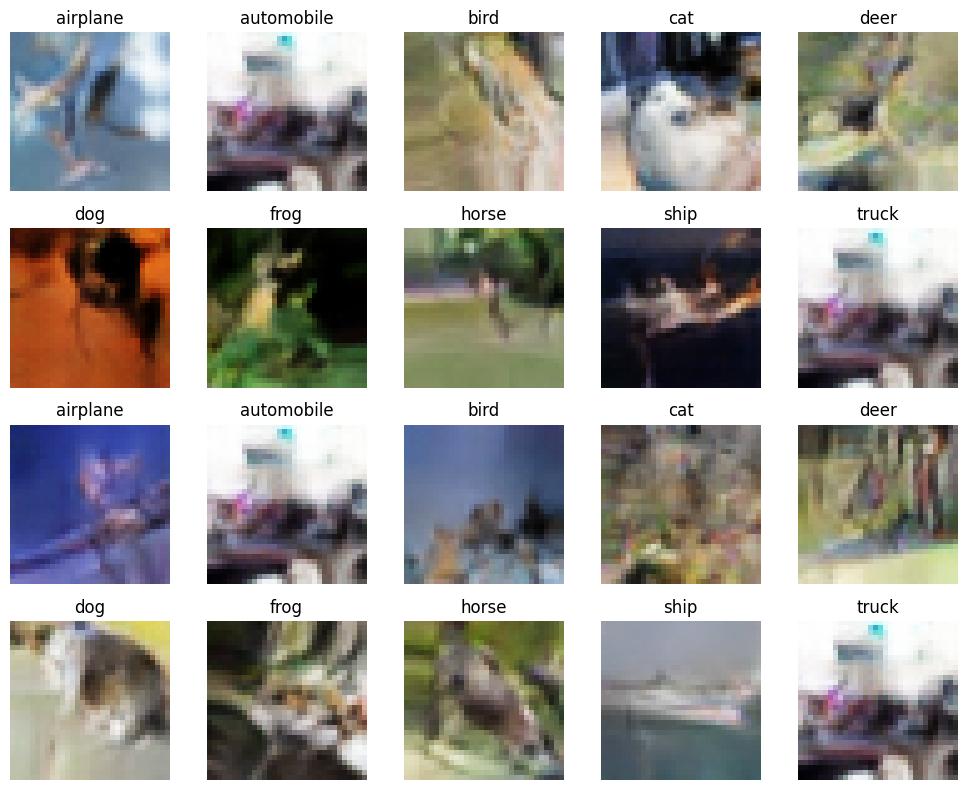

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-100.h5
Epoch 101/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.0574 - g_loss: 8.6559 - D(x|y): 0.5002 - D(G(z|y)): 0.0271 - KL Divergence: 4.0309 - acc.: 98.0161
Epoch 102/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.0606 - g_loss: 8.3719 - D(x|y): 0.5004 - D(G(z|y)): 0.0283 - KL Divergence: 4.7851 - acc.: 97.8628
Epoch 103/110
782/782 [==============================] - 41s 53ms/step - d_loss: 0.0634 - g_loss: 8.2998 - D(x|y): 0.5003 - D(G(z|y)): 0.0289 - KL Divergence: 5.1179 - acc.: 97.8002
Epoch 104/110
782/782 [==============================] - 41s 52ms/step - d_loss: 0.0682 - g_loss: 8.6337 - D(x|y): 0.5005 - D(G(z|y)): 0.0296 - KL Divergence: 4.8060 - acc.: 97.5451
Epoch 105/110
782/782 [==============================] - 42s 53ms/step - d_loss: 0.0591 - g_loss: 8.3482 - D(x|y): 0.5002 - D(G(z|y)): 0.0281 - KL Divergence: 4.2867 - acc.: 97.9078
Epoch 106/110
782/782 [=======

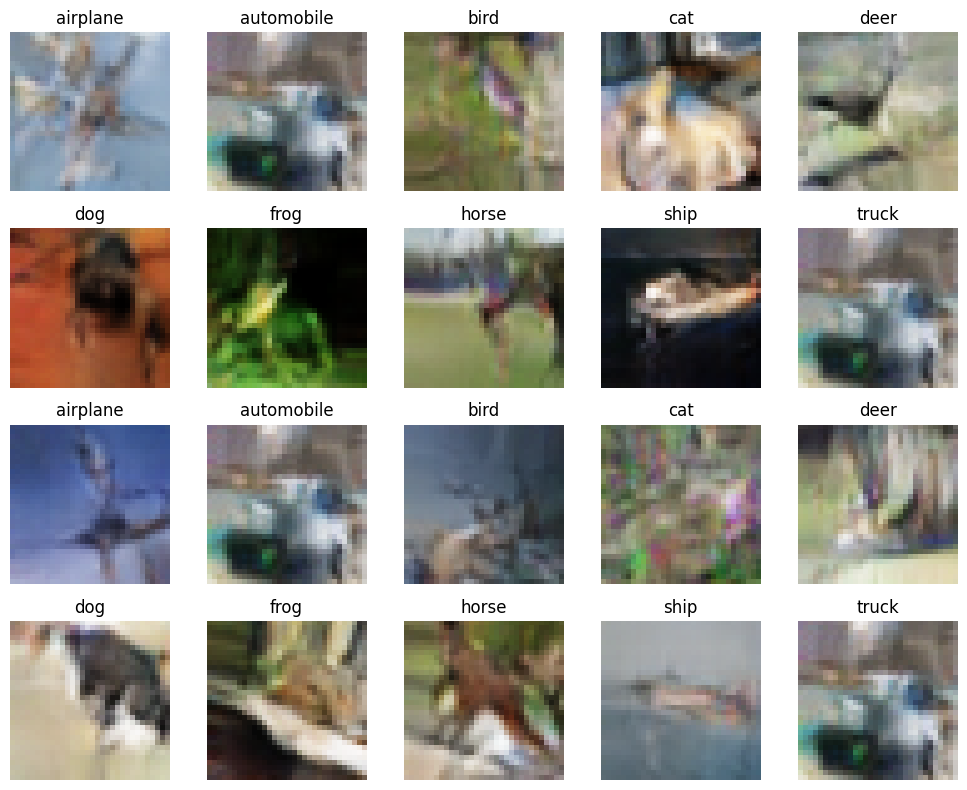

Generator Checkpoint - Img/C_Gan_Aug/generator-epoch-Full Train.h5
CPU times: user 1h 17min 14s, sys: 21 s, total: 1h 17min 35s
Wall time: 1h 16min 27s


In [ ]:
%%time
# Reseting Graph variables
tf.keras.backend.clear_session()

c_gan=CGAN_model()
# Preparing the Dataset with `tf.data`
dataset = tf.data.Dataset.from_tensor_slices((X_train_aug, y_train_aug))
dataset = dataset.shuffle(buffer_size=1024).batch(128, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

# Starting the Train Process
hist = c_gan.fit(dataset, epochs=110, use_multiprocessing=True, workers=16, callbacks=callbacks)

# CGAN with Augmented Data Evaluation

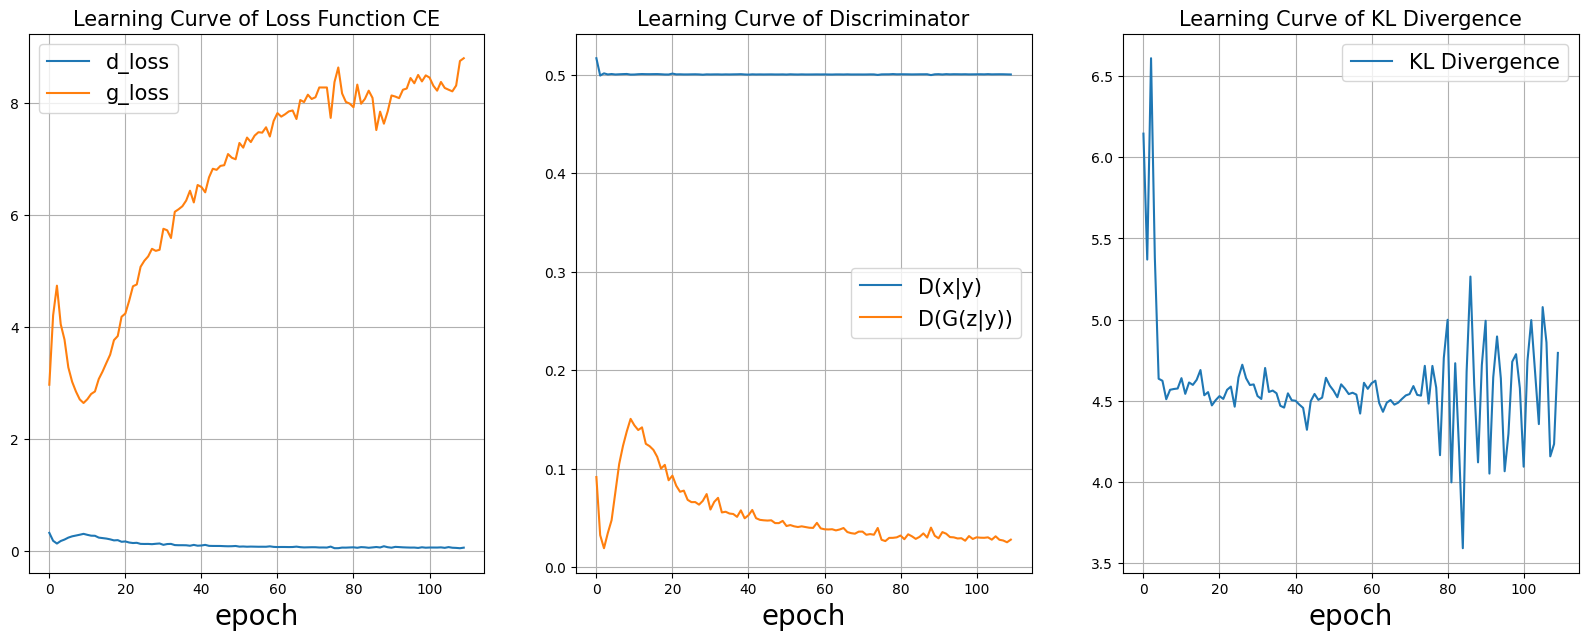

In [ ]:
plot_results(hist.history)

In [ ]:
# Loading Weights for best Generator
saved_weights = 'Img/C_Gan_Aug/generator-epoch-50.h5'
c_gan.generator.load_weights(saved_weights)
c_gan.generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2048)         284672      ['concatenate[0][0]']    

32/32 [==============================] - 0s 7ms/step
Latent Vector Dim: (1024, 128)	Generated Images Dim: (1024, 32, 32, 3)


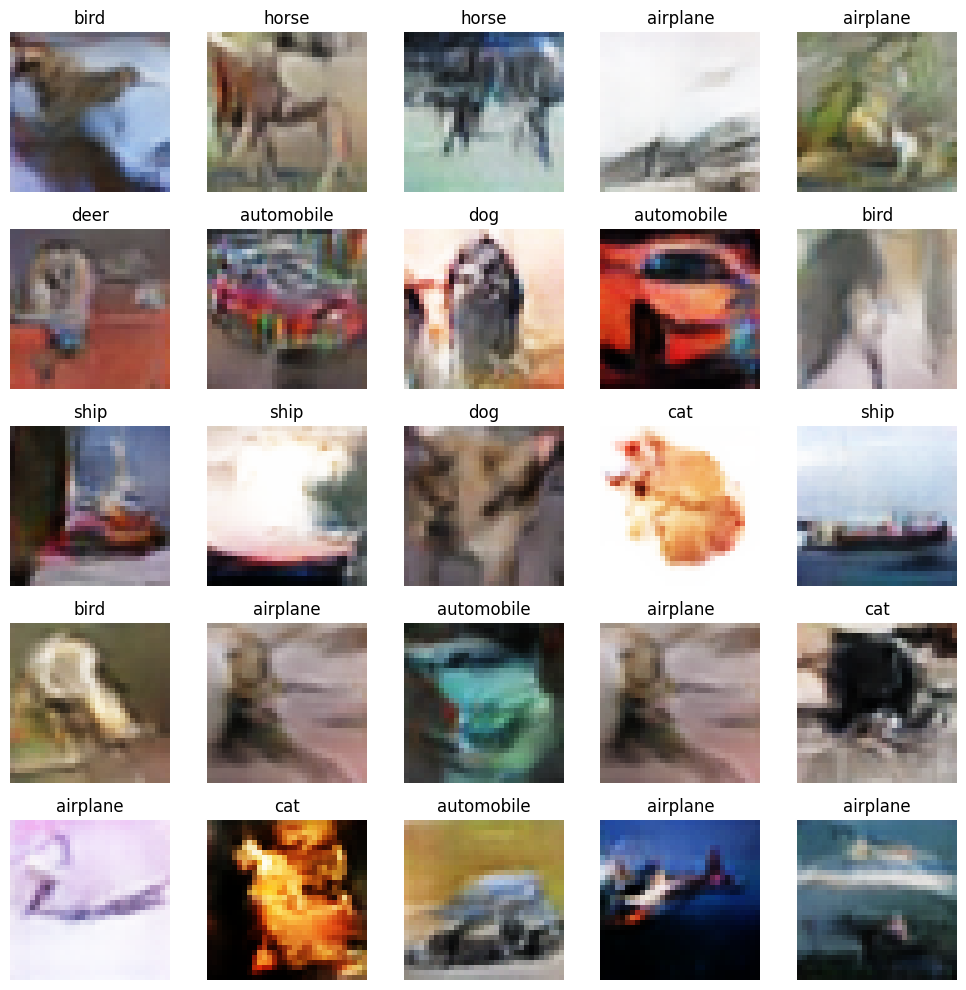

In [ ]:
# generating labels
labels = np.random.randint(low=0, high=10, size=1024)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(1024, 128))

synthetic_images = gan.generator.predict([random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_names[labels[rand_idx]])
    ax.axis('off')
plt.show()

In [ ]:
%%time
fid_class = GAN_FID(batch_size=512, latent_dim=128, sample_size=10000, buffer_size=1024)
fid_class.fit(generator=c_gan.generator, train_data=X_train_aug)
fid_score = fid_class.evaluate()

Computing Real Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 79ms/step
Computing Generated Image Embeddings


  0%|          | 0/20 [00:00<?, ?it/s]

16/16 [==============================] - 1s 74ms/step
Computed Embeddings	Real Images Embedding Shape: (10240, 2048)	Generated Images Embedding Shape
The computed FID score is: 103.5706992331531
CPU times: user 8min 1s, sys: 7min 3s, total: 15min 5s
Wall time: 2min 23s


In [ ]:
%%time
one_hot_labels = to_categorical(np.tile(np.arange(10), 1000))
random_noise = tf.random.normal(shape=(10000, 128))

avg_is, std_is= inception_score(c_gan.generator.predict([random_noise, one_hot_labels]))
print('The Average Inception Score is:', avg_is)
print('The Standard Deviation is:', std_is)

313/313 [==============================] - 2s 6ms/step
The Average Inception Score is: 5.514636
The Standard Deviation is: 0.14956772
CPU times: user 29.2 s, sys: 8.41 s, total: 37.6 s
Wall time: 29.7 s


# Conclusion
- The best model was CGAN without Data Augmentation with the highest inception_score 6.50 and FID of 91.33
- Data Augmentation helps if the data is augmented correctly, in this case the basemodel has improved (generating better images and scores) while the CGAN model has deproved (generating worse images and scores). The numper of layers (deepness of the model) also contributes to this as the basemodel has less layer than the CGAN model, and is less likely to be affected.

# Further Improvements
 - Train models with different types of Data Augmentation 
 - Adding Labels into training could improve training and identification
 - Testing out more GAN Models (WGAN, ACGAN)